In [3]:
import os
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import os
import torch
import numpy as np
import pandas as pd
from natsort import natsorted
from torch.utils.data import Dataset, DataLoader as TorchDataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from torch.utils.data import random_split, DataLoader as TorchDataLoader
from torch.utils.data import Dataset
import torch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from models import Simple1DCNN
import matplotlib.pyplot as plt
import argparse
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

featidx = list(range(0, 8))  # use all features
transform = StandardScaler()

## Loading all files

In [2]:
# data_rock = {}
# data_paper = {}
# data_scissor = {}
# data_none = {}

# for sub in ['subject01', 'subject02', 'subject03', 'subject04', 'subject05', 'subject06', 'subject07', 'subject08', 'subject09', 'subject10']:

#     data_rock[sub] = []
#     data_paper[sub] = []
#     data_scissor[sub] = []
#     data_none[sub] = []
    
#     for ses in ['session01', 'session02', 'session03']:
        
#         data        = np.load(rf'C:\0_Working\PhD\Papers\SP7_RoShamBo\roshambo-main\data\{sub}_{ses}_emg.npy', allow_pickle=True)
#         annotation  = np.load(rf'C:\0_Working\PhD\Papers\SP7_RoShamBo\roshambo-main\data\{sub}_{ses}_ann.npy', allow_pickle=True)

#         data = torch.tensor(data, dtype=torch.float32)
#         data = transform.fit_transform(data)
#         data = torch.tensor(data, dtype=torch.float32)

#         for i in range(len(data)):
#             if annotation[i] == b'rock' or annotation[i] == 'rock':
#                 data_rock[sub].append(data[i,:])
#             elif annotation[i] == b'paper' or annotation[i] == 'paper':
#                 data_paper[sub].append(data[i,:])
#             elif annotation[i] == b'scissor' or annotation[i] == 'scissor':
#                 data_scissor[sub].append(data[i,:])
#             elif annotation[i] == b'none' or annotation[i] == 'none':
#                 data_none[sub].append(data[i,:])

# Rock, Paper, Scissor, dNone = [], [], [], []
# for sub in data_rock:
#     Rock += data_rock[sub]

# for sub in data_paper:
#     Paper += data_paper[sub]

# for sub in data_scissor:
#     Scissor += data_scissor[sub]

# for sub in data_none:    
#     dNone += data_none[sub]

# Rock = np.array(Rock)
# Paper = np.array(Paper)
# Scissor = np.array(Scissor)
# dNone = np.array(dNone)

# # setting abnormal data to the neighbouring data
# def set_abnormal_data(data, threshold=5):
#     mean = np.mean(data, axis=0)
#     std = np.std(data, axis=0)
#     for i in range(len(data)):
#         if np.any(np.abs(data[i] - mean) > threshold * std):
#             if i > 0:
#                 data[i] = data[i-1]
#             else:
#                 data[i] = data[i+1]
#     return data

# Scissor_outlier_free = set_abnormal_data(Scissor.copy())
# Rock_outlier_free = set_abnormal_data(Rock.copy())
# Paper_outlier_free = set_abnormal_data(Paper.copy())
# None_outlier_free = set_abnormal_data(dNone.copy())

# min_time = min(Rock_outlier_free.shape[0], Paper_outlier_free.shape[0], Scissor_outlier_free.shape[0], None_outlier_free.shape[0])
# Rock_final = Rock_outlier_free[:min_time]
# Paper_final = Paper_outlier_free[:min_time]
# Scissor_final = Scissor_outlier_free[:min_time]
# None_final = None_outlier_free[:min_time]

In [ ]:
# print(f'Rock: {Rock_final.shape}, Paper: {Paper_final.shape}, Scissor: {Scissor_final.shape}, None: {None_final.shape}')

Rock: (59469, 8), Paper: (59469, 8), Scissor: (59469, 8), None: (59469, 8)


In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class WindowedDataset(Dataset):
    def __init__(self, data_dict, window_size=64, hop_size=32):
        self.samples = []
        self.labels = []

        label_map = {'rock': 0, 'paper': 1, 'scissor': 2, 'none': 3}
        
        for key, data in data_dict.items():
            label = label_map[key.lower()]
            for start in range(0, data.shape[0] - window_size + 1, hop_size):
                window = data[start:start + window_size]  # (window_size, 8)
                window = window.T  # (8, window_size)
                window = np.expand_dims(window, axis=0)  # (1, 8, window_size)
                self.samples.append(window)
                self.labels.append(label)

        self.samples = np.array(self.samples, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx]), torch.tensor(self.labels[idx])

def create_dataloaders(data_dict, window_size=64, hop_size=32, batch_size=64, val_split=0.2):
    dataset = WindowedDataset(data_dict, window_size, hop_size)
    
    val_len = int(len(dataset) * val_split)
    train_len = len(dataset) - val_len
    train_dataset, val_dataset = random_split(dataset, [train_len, val_len])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


# data_dict = {
#     'rock': Rock_final,
#     'paper': Paper_final,
#     'scissor': Scissor_final,
#     'none': None_final
# }

batch_size = 32
# train_loader, val_loader = create_dataloaders(data_dict, window_size=400, hop_size=200, batch_size=batch_size, val_split=0.2)
# dataloader, _ = create_dataloaders(data_dict, window_size=400, hop_size=200, batch_size=batch_size, val_split=0.0)


In [5]:
dataloader = torch.load('dataloader_v1.pth')
train_loader = torch.load('train_loader_v1.pth')
val_loader = torch.load('val_loader_v1.pth')

In [6]:
print("dataloader length", len(dataloader))
print("dataloader length", len(train_loader))
print("dataloader length", len(val_loader))

dataloader length 37
dataloader length 30
dataloader length 8


In [7]:
sample = next(iter(dataloader))
print(f'Sample shape: {sample[0].shape}, Label shape: {sample[1].shape}')

Sample shape: torch.Size([32, 1, 8, 400]), Label shape: torch.Size([32])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


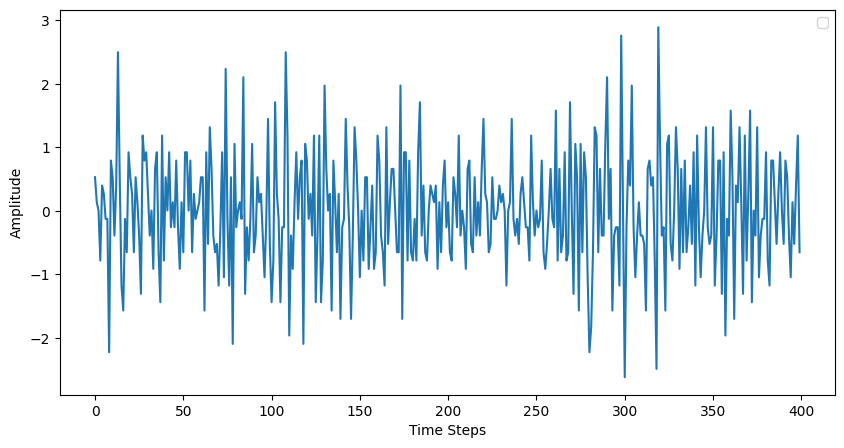

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(sample[0][0, 0, 4, :].numpy())
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Model (Sensor Reconstruction)

In [9]:
import os
import torch
import numpy as np
import pandas as pd
from natsort import natsorted
from torch.utils.data import Dataset, DataLoader as TorchDataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm


def normalize(tensor):
    min_val = tensor.amin(dim=-1, keepdim=True)
    max_val = tensor.amax(dim=-1, keepdim=True)
    return (tensor - min_val) / (max_val - min_val + 1e-8)


class SpectralLoss(nn.Module):
    def __init__(self):
        super(SpectralLoss, self).__init__()

    def forward(self, x, y):
        # Apply FFT along the time dimension (last dim assumed to be time)
        x_fft = torch.fft.rfft(x, dim=-1)
        y_fft = torch.fft.rfft(y, dim=-1)

        # Compare magnitude spectrum
        x_mag = torch.abs(x_fft)
        y_mag = torch.abs(y_fft)

        return F.mse_loss(x_mag, y_mag)

class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        super(CombinedLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.spectral = SpectralLoss()
        self.alpha = alpha  # weight for MSE
        self.beta = beta    # weight for spectral

    def forward(self, recon, target):
        mse_loss = self.mse(recon, target)
        spectral_loss = self.spectral(recon, target)
        return self.alpha * mse_loss + self.beta * spectral_loss


class Encoder_1(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(Encoder_1, self).__init__()

        self.dropout_rate = dropout_rate
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(1, 5), stride=(1,2) ,padding=(0, 0)) 
        self.batchnorm1 = nn.BatchNorm2d(128)  
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=(1, 3), stride=(1,1) ,padding=(0, 0))   
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=(1, 3), stride=(1,2) ,padding=(0, 0))   
        self.batchnorm3 = nn.BatchNorm2d(512)
        self.dropout3 = nn.Dropout(self.dropout_rate)
        self.conv4 = nn.Conv2d(512, 1, kernel_size=(1, 3), stride=(1,1) ,padding=(0, 0))   
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        # print(x.shape)
        x = self.leaky_relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        # print(x.shape)
        x = F.elu(self.conv3(x)); 
        x = self.batchnorm3(x)
        x = self.dropout3(x)
        # print(x.shape)
        x = self.conv4(x); 
        # print(x.shape)
        return x 

class Decoder_1(nn.Module):
    def __init__(self, dropout_rate=0.2):
        self.dropout_rate = dropout_rate

        super(Decoder_1, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(1, 512, kernel_size=(1, 3), stride=(1, 1))   
        self.deconv1_bn = nn.BatchNorm2d(512)
        self.deconv1_dp = nn.Dropout(self.dropout_rate)            
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=(1, 3), stride=(1, 2), output_padding=(0, 1))  # W: 34 → 69
        self.deconv2_bn = nn.BatchNorm2d(256)
        self.deconv2_dp = nn.Dropout(self.dropout_rate)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=(1, 3), stride=(1, 1), output_padding=(0, 0))   # W: 69 → 141
        self.deconv3_bn = nn.BatchNorm2d(128)
        self.deconv3_dp = nn.Dropout(self.dropout_rate)
        self.deconv4 = nn.ConvTranspose2d(128, 1, kernel_size=(1, 5), stride=(1, 2), output_padding=(0, 1))    # W: 141 → 300

    def forward(self, x):
        x = F.relu(self.deconv1(x))         
        x = self.deconv1_bn(x)
        x = self.deconv1_dp(x)
        # print("deconv1:", x.shape)
        x = F.softplus(self.deconv2(x))     # (B, 64, 1, 69)
        x = self.deconv2_bn(x)
        x = self.deconv2_dp(x)
        # print("deconv2:", x.shape)
        x = F.elu(self.deconv3(x))          # (B, 32, 1, 141)
        x = self.deconv3_bn(x)
        x = self.deconv3_dp(x)
        # print("deconv3:", x.shape)
        # x = F.tanh(self.deconv4(x))         # (B, 5, 1, 300)
        x = (self.deconv4(x))         # (B, 5, 1, 300)
        # print("deconv4:", x.shape)
        return x

        
class Autoencoder_type1(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(Autoencoder_type1, self).__init__()
        self.dropout_rate = dropout_rate
        self.encoder = Encoder_1(self.dropout_rate)
        self.decoder = Decoder_1(self.dropout_rate)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


class Encoder_2(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(Encoder_2, self).__init__()

        self.dropout_rate = dropout_rate
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(1, 5), stride=(1,2) ,padding=(0, 0)) 
        self.batchnorm1 = nn.BatchNorm2d(128)  
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=(1, 3), stride=(1,1) ,padding=(0, 0))   
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=(1, 3), stride=(1,2) ,padding=(0, 0))   
        self.batchnorm3 = nn.BatchNorm2d(512)
        self.dropout3 = nn.Dropout(self.dropout_rate)
        self.conv4 = nn.Conv2d(512, 1, kernel_size=(1, 3), stride=(1,1) ,padding=(0, 0))   
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        # print(x.shape)
        x = self.leaky_relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        # print(x.shape)
        x = F.elu(self.conv3(x)); 
        x = self.batchnorm3(x)
        x = self.dropout3(x)
        # print(x.shape)
        x = self.conv4(x); 
        # print(x.shape)
        return x 

class Decoder_2(nn.Module):
    def __init__(self, dropout_rate=0.2):
        self.dropout_rate = dropout_rate

        super(Decoder_2, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(1, 512, kernel_size=(1, 3), stride=(1, 1))   
        self.deconv1_bn = nn.BatchNorm2d(512)
        self.deconv1_dp = nn.Dropout(self.dropout_rate)            
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=(1, 3), stride=(1, 2), output_padding=(0, 0))  # W: 34 → 69
        self.deconv2_bn = nn.BatchNorm2d(256)
        self.deconv2_dp = nn.Dropout(self.dropout_rate)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=(1, 3), stride=(1, 1), output_padding=(0, 0))   # W: 69 → 141
        self.deconv3_bn = nn.BatchNorm2d(128)
        self.deconv3_dp = nn.Dropout(self.dropout_rate)
        self.deconv4 = nn.ConvTranspose2d(128, 1, kernel_size=(1, 7), stride=(1, 2), output_padding=(0, 1))    # W: 141 → 300

    def forward(self, x):
        x = F.relu(self.deconv1(x))         
        x = self.deconv1_bn(x)
        x = self.deconv1_dp(x)
        # print("deconv1:", x.shape)
        x = F.softplus(self.deconv2(x))     # (B, 64, 1, 69)
        x = self.deconv2_bn(x)
        x = self.deconv2_dp(x)
        # print("deconv2:", x.shape)
        x = F.elu(self.deconv3(x))          # (B, 32, 1, 141)
        x = self.deconv3_bn(x)
        x = self.deconv3_dp(x)
        # print("deconv3:", x.shape)
        # x = F.tanh(self.deconv4(x))         # (B, 5, 1, 300)
        x = self.deconv4(x)         # (B, 5, 1, 300)
        # print("deconv4:", x.shape)
        return x

        
class Autoencoder_type2(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(Autoencoder_type2, self).__init__()
        self.dropout_rate = dropout_rate
        self.encoder = Encoder_2(self.dropout_rate)
        self.decoder = Decoder_2(self.dropout_rate)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

class Encoder2D_n(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(Encoder2D_n, self).__init__()

        self.dropout_rate = dropout_rate
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(1, 5), stride=(1,2) ,padding=(0, 0)) 
        self.batchnorm1 = nn.BatchNorm2d(128)  
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=(1, 3), stride=(1,2) ,padding=(0, 0))   
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=(1, 3), stride=(1,2) ,padding=(0, 0))   
        self.batchnorm3 = nn.BatchNorm2d(512)
        self.dropout3 = nn.Dropout(self.dropout_rate)
        self.conv4 = nn.Conv2d(512, 1, kernel_size=(1, 3), stride=(1,2) ,padding=(0, 0))   
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        # print(x.shape)
        x = self.leaky_relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        # print(x.shape)
        x = F.elu(self.conv3(x)); 
        x = self.batchnorm3(x)
        x = self.dropout3(x)
        # print(x.shape)
        x = self.conv4(x); 
        # print(x.shape)
        return x 

class Decoder2D_n(nn.Module):
    def __init__(self, dropout_rate=0.2):
        self.dropout_rate = dropout_rate

        super(Decoder2D_n, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(1, 512, kernel_size=(1, 3), stride=(1, 2), output_padding=(0, 1))   
        self.deconv1_bn = nn.BatchNorm2d(512)
        self.deconv1_dp = nn.Dropout(self.dropout_rate)            
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=(1, 3), stride=(1, 2), output_padding=(0, 0))  # W: 34 → 69
        self.deconv2_bn = nn.BatchNorm2d(256)
        self.deconv2_dp = nn.Dropout(self.dropout_rate)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=(1, 3), stride=(1, 2), output_padding=(0, 1))   # W: 69 → 141
        self.deconv3_bn = nn.BatchNorm2d(128)
        self.deconv3_dp = nn.Dropout(self.dropout_rate)
        self.deconv4 = nn.ConvTranspose2d(128, 1, kernel_size=(1, 5), stride=(1, 2), output_padding=(0, 1))    # W: 141 → 300

    def forward(self, x):
        x = F.relu(self.deconv1(x))         
        x = self.deconv1_bn(x)
        x = self.deconv1_dp(x)
        # print("deconv1:", x.shape)
        # x = F.softplus(self.deconv2(x))     # (B, 64, 1, 69)
        x = (self.deconv2(x))     # (B, 64, 1, 69)
        x = self.deconv2_bn(x)
        x = self.deconv2_dp(x)
        # print("deconv2:", x.shape)
        # x = F.elu(self.deconv3(x))          # (B, 32, 1, 141)
        x = (self.deconv3(x))          # (B, 32, 1, 141)
        x = self.deconv3_bn(x)
        x = self.deconv3_dp(x)
        # print("deconv3:", x.shape)
        # x = F.tanh(self.deconv4(x))         # (B, 5, 1, 300)
        x = (self.deconv4(x))         # (B, 5, 1, 300)
        # print("deconv4:", x.shape)
        return x

        
class Autoencoder2D_n(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(Autoencoder2D_n, self).__init__()
        self.dropout_rate = dropout_rate
        self.encoder = Encoder2D_n(self.dropout_rate)
        self.decoder = Decoder2D_n(self.dropout_rate)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


if __name__ == "__main__":
    x = torch.randn(133, 1, 8, 400)# Example input (B=1, C=1, H=1, W=200)
    model1 = Autoencoder_type1(dropout_rate=0.2)
    reconstructed, latent = model1(x)
    print("Input shape:", x.shape)
    print("Reconstructed shape:", reconstructed.shape) 
    print("Latent shape:", latent.shape) 
    # model2 = Autoencoder_type2(dropout_rate=0.2)
    # reconstructed2, latent2 = model2(x)
    # print("Reconstructed shape:", reconstructed2.shape)  
    # print("Latent shape:", latent2.shape)  

    # x = torch.randn(133, 1, 8, 400)
    # model3 = Autoencoder2D_n(dropout_rate=0.2)
    # reconstructed3, latent3 = model3(x)
    # print("Reconstructed shape:", reconstructed3.shape) 
    # print("Latent shape:", latent3.shape)  

Input shape: torch.Size([133, 1, 8, 400])
Reconstructed shape: torch.Size([133, 1, 8, 400])
Latent shape: torch.Size([133, 1, 8, 95])


## Train the autoencoder

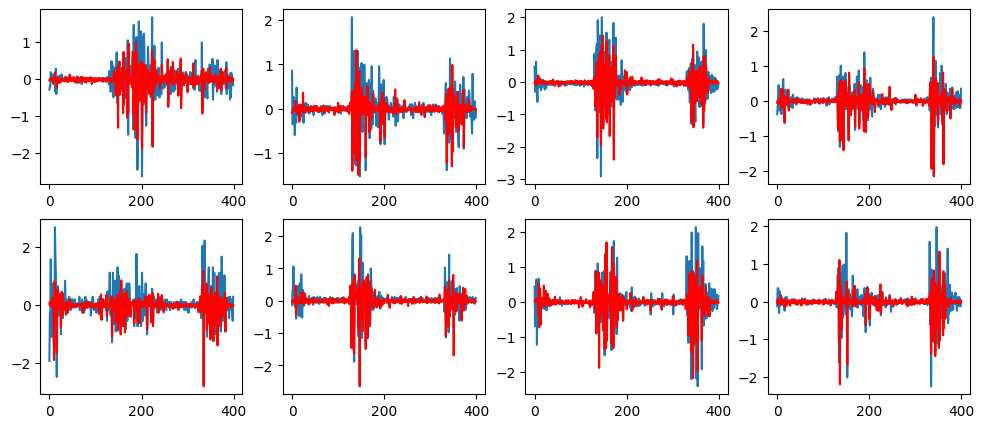

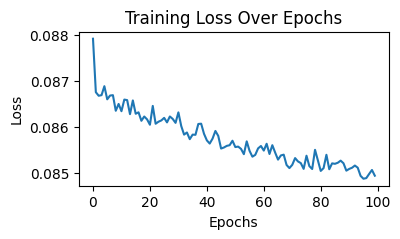

Epoch 100 Avg Loss: 0.0849


In [ ]:
from IPython.display import clear_output


model_path1 = f"param_autoencoder.pth"  # Path to save the model
model = Autoencoder_type1(dropout_rate=0.3).cuda()
model.load_state_dict(torch.load(model_path1))

model_path = f"param_autoencoder.pth"  # Path to save the model

criterion = nn.HuberLoss(delta=0.25)  # delta is the threshold for switching between MSE and MAE
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

model.train()
epoch_loss_best = 0.0868

loss_log = []
for epoch in range(100):
    epoch_loss = 0.0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)

    for batch,_ in loop:
        
        input = torch.tensor(batch.cuda(), dtype=torch.float32)
        output, _ = model(input)  
        loss = criterion(output, input)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        
    avg_loss = epoch_loss / len(dataloader)

    loss_log.append(avg_loss)

    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            sample_input = input[0].squeeze(0).detach().cpu().numpy()     # (channels, time)
            sample_output = output[0].squeeze(0).detach().cpu().numpy()   # (channels, time)

            clear_output(wait=True)  # <-- this clears the previous plots

            fig, ax = plt.subplots(2, 4, figsize=(12, 5))
            ax[0,0].plot(sample_input[0])
            ax[0,0].plot(sample_output[0], '-' , color='red')
            ax[0,1].plot(sample_input[1])
            ax[0,1].plot(sample_output[1], '-', color='red')
            ax[0,2].plot(sample_input[2])
            ax[0,2].plot(sample_output[2], '-', color='red')
            ax[0,3].plot(sample_input[3])
            ax[0,3].plot(sample_output[3], '-', color='red')
            ax[1,0].plot(sample_input[4])
            ax[1,0].plot(sample_output[4], '-', color='red')
            ax[1,1].plot(sample_input[5])
            ax[1,1].plot(sample_output[5], '-', color='red')
            ax[1,2].plot(sample_input[6])
            ax[1,2].plot(sample_output[6], '-', color='red')   
            ax[1,3].plot(sample_input[7])
            ax[1,3].plot(sample_output[7], '-', color='red')
            plt.show()            

            fig, ax = plt.subplots(figsize=(4, 2))
            ax.plot(loss_log)
            ax.set_title('Training Loss Over Epochs')   
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Loss')
            plt.show()

    if avg_loss < epoch_loss_best:
        epoch_loss_best = avg_loss
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at epoch {epoch+1} with loss: {avg_loss:.4f}")
    else:
        print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")


## Testing the Reconstruction

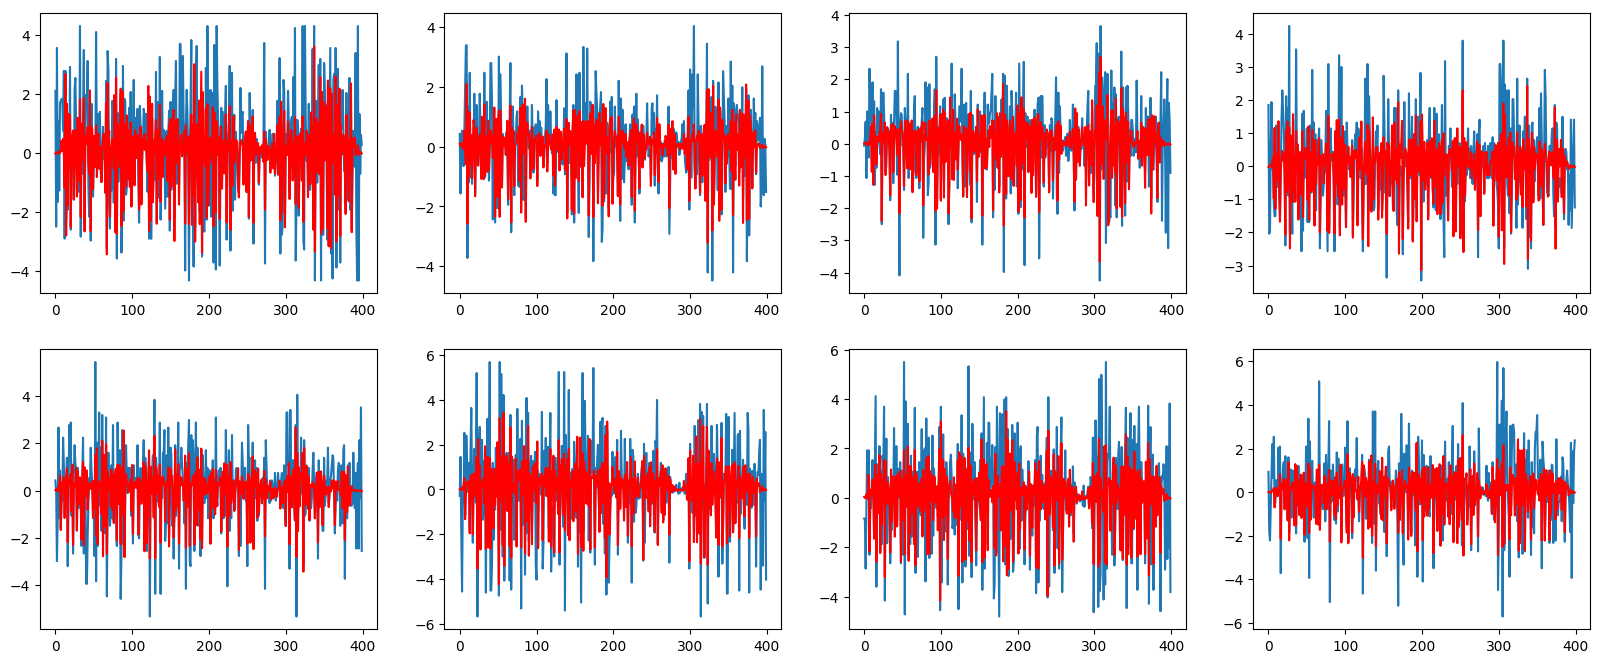

In [10]:
model_path = f"param_autoencoder.pth"  # Path to save the model
model = Autoencoder_type1(dropout_rate=0.2).cuda()
model.load_state_dict(torch.load(model_path))

model.eval()
with torch.no_grad():
    for batch in dataloader:
        inputs, label = batch
        batch_reshaped = inputs.cuda()
        output, _ = model(batch_reshaped)
        sample_input = inputs[0].squeeze(0).detach().cpu().numpy()     # (channels, time)
        sample_output = output[0].squeeze(0).detach().cpu().numpy()
        fig, ax = plt.subplots(2, 4, figsize=(20, 8))
        ax[0,0].plot(sample_input[0])
        ax[0,0].plot(sample_output[0], alpha=1.0 , color='red')
        ax[0,1].plot(sample_input[1])
        ax[0,1].plot(sample_output[1], alpha=1.0 , color='red')
        ax[0,2].plot(sample_input[2])
        ax[0,2].plot(sample_output[2], alpha=1.0 , color='red')
        ax[0,3].plot(sample_input[3])
        ax[0,3].plot(sample_output[3], alpha=1.0 , color='red')
        ax[1,0].plot(sample_input[4])
        ax[1,0].plot(sample_output[4], alpha=1.0 , color='red')
        ax[1,1].plot(sample_input[5])
        ax[1,1].plot(sample_output[5], alpha=1.0 , color='red')
        ax[1,2].plot(sample_input[6])
        ax[1,2].plot(sample_output[6], alpha=1.0 , color='red')   
        ax[1,3].plot(sample_input[7])
        ax[1,3].plot(sample_output[7], alpha=1.0 , color='red')
        plt.show()  
        break                

## Classification Model

In [11]:
from models import Simple1DCNN

featidx = list(range(0, 8))  # use all features
model_class = Simple1DCNN(num_sensors=len(featidx), num_classes=4).to('cuda')
dummy_input = torch.randn(batch_size, len(featidx), 95).to('cuda')  # Example input
print("Input shape:", dummy_input.shape)  # Should be (B, num_sensors, W)
output = model_class(dummy_input)
print("Output shape:", output.shape)  # Should be (B, num_classes)


Input shape: torch.Size([32, 8, 95])
Output shape: torch.Size([32, 4])


## Training the Classifier

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

model_path = f"param_autoencoder.pth"  # Path to save the model
model = Autoencoder_type1(dropout_rate=0.2).cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

model_class_path = "param_classifier.pth" 
featidx = list(range(0, 8)) 
model_class = Simple1DCNN(num_sensors=len(featidx), num_classes=4).to('cuda')
# model_class.load_state_dict(torch.load(model_class_path))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model_class.parameters(),
    lr=2e-4,
    weight_decay=1e-4,
)

# Training setup
num_epochs = 500
best_val_loss = 0
loss_log = []
best_val_acc = 0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []

for epoch in range(num_epochs):
    model_class.train()
    train_loss, train_total = 0, 0
    train_correct = 0
    all_train_preds, all_train_targets = [], []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{batch_size}")

    for batch in pbar:
        X, y = batch
        X, y = (
            X.to('cuda'),
            y.to('cuda'),
        )
        batch_reshaped = X.cuda()        

        with torch.no_grad():
            _, latent_1 = model(batch_reshaped)

        input = latent_1.squeeze(1).cuda()

        outputs = model_class(input)

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_total += y.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == y).sum().item()

        # Store predictions and targets for F1 score
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_targets.extend(y.cpu().numpy())

        # Calculate metrics
        train_acc = train_correct / train_total
        train_f1 = f1_score(all_train_targets, all_train_preds, average="weighted")

        # Update progress bar
        pbar.set_postfix(
            {
                "loss": f"{train_loss/train_total:.4f}",
                "acc": f"{train_acc:.4f}",
                "f1": f"{train_f1:.4f}",
            }
        )

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    train_f1 = f1_score(all_train_targets, all_train_preds, average="weighted")

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)

    # Validation
    model_class.eval()
    val_loss, val_total = 0, 0
    val_correct = 0
    all_val_preds, all_val_targets = [], []


    with torch.no_grad():
        for batch in val_loader:
            X_v, y_y = batch
            X_v, y_y = (
                X_v.to('cuda'),
                y_y.to('cuda'),
            )
            val_batch_reshaped = X_v.cuda()        

            with torch.no_grad():
                _, latent_ = model(val_batch_reshaped)

            input_vl = latent_.squeeze(1).cuda()

            outputs = model_class(input_vl)
            loss = criterion(outputs, y_y)

            val_loss += loss.item()
            val_total += y_y.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == y_y).sum().item()

            # Store predictions and targets for F1 score
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_targets.extend(y_y.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(all_val_targets, all_val_preds, average="weighted")

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_class.state_dict(), "param_classifier.pth")

Epoch 1/32: 100%|██████████| 30/30 [00:01<00:00, 25.59it/s, loss=0.0398, acc=0.4135, f1=0.3996]


Epoch [1/500], Train Loss: 1.2587, Train Acc: 0.4135, Train F1: 0.3996, Val Loss: 0.9858, Val Acc: 0.5720, Val F1: 0.5134


Epoch 2/32: 100%|██████████| 30/30 [00:00<00:00, 30.84it/s, loss=0.0336, acc=0.5359, f1=0.4735]


Epoch [2/500], Train Loss: 1.0630, Train Acc: 0.5359, Train F1: 0.4735, Val Loss: 0.9348, Val Acc: 0.5932, Val F1: 0.5376


Epoch 3/32: 100%|██████████| 30/30 [00:00<00:00, 31.89it/s, loss=0.0305, acc=0.5643, f1=0.5080]


Epoch [3/500], Train Loss: 0.9642, Train Acc: 0.5643, Train F1: 0.5080, Val Loss: 0.8366, Val Acc: 0.6186, Val F1: 0.5769


Epoch 4/32: 100%|██████████| 30/30 [00:00<00:00, 31.51it/s, loss=0.0284, acc=0.5981, f1=0.5724]


Epoch [4/500], Train Loss: 0.8978, Train Acc: 0.5981, Train F1: 0.5724, Val Loss: 0.7394, Val Acc: 0.6525, Val F1: 0.6287


Epoch 5/32: 100%|██████████| 30/30 [00:00<00:00, 31.71it/s, loss=0.0268, acc=0.6297, f1=0.6152]


Epoch [5/500], Train Loss: 0.8454, Train Acc: 0.6297, Train F1: 0.6152, Val Loss: 0.6805, Val Acc: 0.6907, Val F1: 0.6771


Epoch 6/32: 100%|██████████| 30/30 [00:00<00:00, 30.73it/s, loss=0.0251, acc=0.6498, f1=0.6381]


Epoch [6/500], Train Loss: 0.7940, Train Acc: 0.6498, Train F1: 0.6381, Val Loss: 0.6373, Val Acc: 0.7161, Val F1: 0.7009


Epoch 7/32: 100%|██████████| 30/30 [00:00<00:00, 31.95it/s, loss=0.0230, acc=0.6825, f1=0.6743]


Epoch [7/500], Train Loss: 0.7278, Train Acc: 0.6825, Train F1: 0.6743, Val Loss: 0.5977, Val Acc: 0.7458, Val F1: 0.7327


Epoch 8/32: 100%|██████████| 30/30 [00:00<00:00, 31.14it/s, loss=0.0220, acc=0.6983, f1=0.6917]


Epoch [8/500], Train Loss: 0.6958, Train Acc: 0.6983, Train F1: 0.6917, Val Loss: 0.5526, Val Acc: 0.7458, Val F1: 0.7343


Epoch 9/32: 100%|██████████| 30/30 [00:00<00:00, 32.13it/s, loss=0.0204, acc=0.7120, f1=0.7045]


Epoch [9/500], Train Loss: 0.6447, Train Acc: 0.7120, Train F1: 0.7045, Val Loss: 0.5155, Val Acc: 0.7627, Val F1: 0.7532


Epoch 10/32: 100%|██████████| 30/30 [00:00<00:00, 31.09it/s, loss=0.0212, acc=0.6983, f1=0.6915]


Epoch [10/500], Train Loss: 0.6705, Train Acc: 0.6983, Train F1: 0.6915, Val Loss: 0.4951, Val Acc: 0.7797, Val F1: 0.7733


Epoch 11/32: 100%|██████████| 30/30 [00:00<00:00, 31.40it/s, loss=0.0200, acc=0.7057, f1=0.6978]


Epoch [11/500], Train Loss: 0.6316, Train Acc: 0.7057, Train F1: 0.6978, Val Loss: 0.4971, Val Acc: 0.7797, Val F1: 0.7726


Epoch 12/32: 100%|██████████| 30/30 [00:00<00:00, 31.27it/s, loss=0.0210, acc=0.7089, f1=0.7034]


Epoch [12/500], Train Loss: 0.6637, Train Acc: 0.7089, Train F1: 0.7034, Val Loss: 0.5023, Val Acc: 0.7881, Val F1: 0.7827


Epoch 13/32: 100%|██████████| 30/30 [00:00<00:00, 31.06it/s, loss=0.0232, acc=0.7131, f1=0.7078]


Epoch [13/500], Train Loss: 0.7319, Train Acc: 0.7131, Train F1: 0.7078, Val Loss: 0.4984, Val Acc: 0.7924, Val F1: 0.7874


Epoch 14/32: 100%|██████████| 30/30 [00:00<00:00, 31.46it/s, loss=0.0193, acc=0.7352, f1=0.7318]


Epoch [14/500], Train Loss: 0.6112, Train Acc: 0.7352, Train F1: 0.7318, Val Loss: 0.4923, Val Acc: 0.7966, Val F1: 0.7930


Epoch 15/32: 100%|██████████| 30/30 [00:00<00:00, 31.75it/s, loss=0.0181, acc=0.7553, f1=0.7512]


Epoch [15/500], Train Loss: 0.5735, Train Acc: 0.7553, Train F1: 0.7512, Val Loss: 0.4843, Val Acc: 0.7881, Val F1: 0.7831


Epoch 16/32: 100%|██████████| 30/30 [00:00<00:00, 31.56it/s, loss=0.0183, acc=0.7447, f1=0.7419]


Epoch [16/500], Train Loss: 0.5794, Train Acc: 0.7447, Train F1: 0.7419, Val Loss: 0.4821, Val Acc: 0.8093, Val F1: 0.8048


Epoch 17/32: 100%|██████████| 30/30 [00:00<00:00, 31.01it/s, loss=0.0191, acc=0.7373, f1=0.7341]


Epoch [17/500], Train Loss: 0.6042, Train Acc: 0.7373, Train F1: 0.7341, Val Loss: 0.4838, Val Acc: 0.8093, Val F1: 0.8051


Epoch 18/32: 100%|██████████| 30/30 [00:00<00:00, 31.42it/s, loss=0.0176, acc=0.7500, f1=0.7453]


Epoch [18/500], Train Loss: 0.5575, Train Acc: 0.7500, Train F1: 0.7453, Val Loss: 0.4915, Val Acc: 0.8051, Val F1: 0.8011


Epoch 19/32: 100%|██████████| 30/30 [00:00<00:00, 31.08it/s, loss=0.0166, acc=0.7669, f1=0.7609]


Epoch [19/500], Train Loss: 0.5261, Train Acc: 0.7669, Train F1: 0.7609, Val Loss: 0.5026, Val Acc: 0.8263, Val F1: 0.8246


Epoch 20/32: 100%|██████████| 30/30 [00:00<00:00, 31.57it/s, loss=0.0175, acc=0.7690, f1=0.7678]


Epoch [20/500], Train Loss: 0.5520, Train Acc: 0.7690, Train F1: 0.7678, Val Loss: 0.4989, Val Acc: 0.8178, Val F1: 0.8156


Epoch 21/32: 100%|██████████| 30/30 [00:00<00:00, 31.78it/s, loss=0.0174, acc=0.7658, f1=0.7616]


Epoch [21/500], Train Loss: 0.5496, Train Acc: 0.7658, Train F1: 0.7616, Val Loss: 0.4752, Val Acc: 0.8220, Val F1: 0.8203


Epoch 22/32: 100%|██████████| 30/30 [00:00<00:00, 32.04it/s, loss=0.0194, acc=0.7595, f1=0.7552]


Epoch [22/500], Train Loss: 0.6118, Train Acc: 0.7595, Train F1: 0.7552, Val Loss: 0.4510, Val Acc: 0.8051, Val F1: 0.8000


Epoch 23/32: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s, loss=0.0179, acc=0.7627, f1=0.7572]


Epoch [23/500], Train Loss: 0.5653, Train Acc: 0.7627, Train F1: 0.7572, Val Loss: 0.4361, Val Acc: 0.8008, Val F1: 0.7948


Epoch 24/32: 100%|██████████| 30/30 [00:00<00:00, 31.55it/s, loss=0.0178, acc=0.7395, f1=0.7292]


Epoch [24/500], Train Loss: 0.5620, Train Acc: 0.7395, Train F1: 0.7292, Val Loss: 0.4295, Val Acc: 0.8093, Val F1: 0.8045


Epoch 25/32: 100%|██████████| 30/30 [00:00<00:00, 31.53it/s, loss=0.0158, acc=0.7785, f1=0.7735]


Epoch [25/500], Train Loss: 0.4987, Train Acc: 0.7785, Train F1: 0.7735, Val Loss: 0.4304, Val Acc: 0.8093, Val F1: 0.8072


Epoch 26/32: 100%|██████████| 30/30 [00:00<00:00, 31.61it/s, loss=0.0168, acc=0.7732, f1=0.7710]


Epoch [26/500], Train Loss: 0.5298, Train Acc: 0.7732, Train F1: 0.7710, Val Loss: 0.4401, Val Acc: 0.8178, Val F1: 0.8170


Epoch 27/32: 100%|██████████| 30/30 [00:00<00:00, 31.50it/s, loss=0.0176, acc=0.7479, f1=0.7477]


Epoch [27/500], Train Loss: 0.5572, Train Acc: 0.7479, Train F1: 0.7477, Val Loss: 0.4495, Val Acc: 0.8093, Val F1: 0.8089


Epoch 28/32: 100%|██████████| 30/30 [00:00<00:00, 31.84it/s, loss=0.0177, acc=0.7584, f1=0.7575]


Epoch [28/500], Train Loss: 0.5599, Train Acc: 0.7584, Train F1: 0.7575, Val Loss: 0.4382, Val Acc: 0.8093, Val F1: 0.8079


Epoch 29/32: 100%|██████████| 30/30 [00:00<00:00, 31.75it/s, loss=0.0166, acc=0.7764, f1=0.7747]


Epoch [29/500], Train Loss: 0.5251, Train Acc: 0.7764, Train F1: 0.7747, Val Loss: 0.4205, Val Acc: 0.8136, Val F1: 0.8101


Epoch 30/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0158, acc=0.7816, f1=0.7770]


Epoch [30/500], Train Loss: 0.5001, Train Acc: 0.7816, Train F1: 0.7770, Val Loss: 0.4168, Val Acc: 0.8051, Val F1: 0.7998


Epoch 31/32: 100%|██████████| 30/30 [00:00<00:00, 32.14it/s, loss=0.0161, acc=0.7669, f1=0.7595]


Epoch [31/500], Train Loss: 0.5089, Train Acc: 0.7669, Train F1: 0.7595, Val Loss: 0.4146, Val Acc: 0.8136, Val F1: 0.8085


Epoch 32/32: 100%|██████████| 30/30 [00:00<00:00, 31.64it/s, loss=0.0158, acc=0.7637, f1=0.7582]


Epoch [32/500], Train Loss: 0.4986, Train Acc: 0.7637, Train F1: 0.7582, Val Loss: 0.4171, Val Acc: 0.8051, Val F1: 0.7996


Epoch 33/32: 100%|██████████| 30/30 [00:00<00:00, 31.29it/s, loss=0.0161, acc=0.7838, f1=0.7783]


Epoch [33/500], Train Loss: 0.5080, Train Acc: 0.7838, Train F1: 0.7783, Val Loss: 0.4259, Val Acc: 0.8051, Val F1: 0.8019


Epoch 34/32: 100%|██████████| 30/30 [00:00<00:00, 31.89it/s, loss=0.0144, acc=0.7985, f1=0.7965]


Epoch [34/500], Train Loss: 0.4554, Train Acc: 0.7985, Train F1: 0.7965, Val Loss: 0.4453, Val Acc: 0.8178, Val F1: 0.8170


Epoch 35/32: 100%|██████████| 30/30 [00:00<00:00, 31.60it/s, loss=0.0162, acc=0.7795, f1=0.7772]


Epoch [35/500], Train Loss: 0.5107, Train Acc: 0.7795, Train F1: 0.7772, Val Loss: 0.4668, Val Acc: 0.8178, Val F1: 0.8162


Epoch 36/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0173, acc=0.7605, f1=0.7575]


Epoch [36/500], Train Loss: 0.5482, Train Acc: 0.7605, Train F1: 0.7575, Val Loss: 0.4607, Val Acc: 0.8136, Val F1: 0.8114


Epoch 37/32: 100%|██████████| 30/30 [00:00<00:00, 31.80it/s, loss=0.0157, acc=0.7880, f1=0.7828]


Epoch [37/500], Train Loss: 0.4956, Train Acc: 0.7880, Train F1: 0.7828, Val Loss: 0.4304, Val Acc: 0.8220, Val F1: 0.8200


Epoch 38/32: 100%|██████████| 30/30 [00:00<00:00, 31.53it/s, loss=0.0169, acc=0.7722, f1=0.7655]


Epoch [38/500], Train Loss: 0.5343, Train Acc: 0.7722, Train F1: 0.7655, Val Loss: 0.4132, Val Acc: 0.8263, Val F1: 0.8226


Epoch 39/32: 100%|██████████| 30/30 [00:00<00:00, 31.92it/s, loss=0.0142, acc=0.7996, f1=0.7938]


Epoch [39/500], Train Loss: 0.4478, Train Acc: 0.7996, Train F1: 0.7938, Val Loss: 0.4071, Val Acc: 0.8136, Val F1: 0.8083


Epoch 40/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0154, acc=0.7764, f1=0.7686]


Epoch [40/500], Train Loss: 0.4869, Train Acc: 0.7764, Train F1: 0.7686, Val Loss: 0.4018, Val Acc: 0.8136, Val F1: 0.8083


Epoch 41/32: 100%|██████████| 30/30 [00:00<00:00, 31.89it/s, loss=0.0152, acc=0.7922, f1=0.7857]


Epoch [41/500], Train Loss: 0.4817, Train Acc: 0.7922, Train F1: 0.7857, Val Loss: 0.3971, Val Acc: 0.8390, Val F1: 0.8365


Epoch 42/32: 100%|██████████| 30/30 [00:00<00:00, 31.94it/s, loss=0.0146, acc=0.7954, f1=0.7890]


Epoch [42/500], Train Loss: 0.4621, Train Acc: 0.7954, Train F1: 0.7890, Val Loss: 0.4031, Val Acc: 0.8305, Val F1: 0.8279


Epoch 43/32: 100%|██████████| 30/30 [00:00<00:00, 32.34it/s, loss=0.0147, acc=0.7869, f1=0.7790]


Epoch [43/500], Train Loss: 0.4652, Train Acc: 0.7869, Train F1: 0.7790, Val Loss: 0.4256, Val Acc: 0.8178, Val F1: 0.8160


Epoch 44/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0145, acc=0.8017, f1=0.7960]


Epoch [44/500], Train Loss: 0.4596, Train Acc: 0.8017, Train F1: 0.7960, Val Loss: 0.4425, Val Acc: 0.8136, Val F1: 0.8127


Epoch 45/32: 100%|██████████| 30/30 [00:00<00:00, 31.80it/s, loss=0.0152, acc=0.7848, f1=0.7829]


Epoch [45/500], Train Loss: 0.4808, Train Acc: 0.7848, Train F1: 0.7829, Val Loss: 0.4357, Val Acc: 0.8136, Val F1: 0.8135


Epoch 46/32: 100%|██████████| 30/30 [00:00<00:00, 32.31it/s, loss=0.0158, acc=0.7943, f1=0.7932]


Epoch [46/500], Train Loss: 0.4987, Train Acc: 0.7943, Train F1: 0.7932, Val Loss: 0.4063, Val Acc: 0.8178, Val F1: 0.8178


Epoch 47/32: 100%|██████████| 30/30 [00:00<00:00, 31.70it/s, loss=0.0159, acc=0.8133, f1=0.8097]


Epoch [47/500], Train Loss: 0.5013, Train Acc: 0.8133, Train F1: 0.8097, Val Loss: 0.3824, Val Acc: 0.8390, Val F1: 0.8391


Epoch 48/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0146, acc=0.7932, f1=0.7888]


Epoch [48/500], Train Loss: 0.4624, Train Acc: 0.7932, Train F1: 0.7888, Val Loss: 0.3652, Val Acc: 0.8390, Val F1: 0.8372


Epoch 49/32: 100%|██████████| 30/30 [00:00<00:00, 32.25it/s, loss=0.0146, acc=0.8059, f1=0.8018]


Epoch [49/500], Train Loss: 0.4607, Train Acc: 0.8059, Train F1: 0.8018, Val Loss: 0.3599, Val Acc: 0.8390, Val F1: 0.8369


Epoch 50/32: 100%|██████████| 30/30 [00:00<00:00, 31.80it/s, loss=0.0149, acc=0.8027, f1=0.7969]


Epoch [50/500], Train Loss: 0.4710, Train Acc: 0.8027, Train F1: 0.7969, Val Loss: 0.3592, Val Acc: 0.8432, Val F1: 0.8415


Epoch 51/32: 100%|██████████| 30/30 [00:00<00:00, 32.43it/s, loss=0.0137, acc=0.8112, f1=0.8067]


Epoch [51/500], Train Loss: 0.4344, Train Acc: 0.8112, Train F1: 0.8067, Val Loss: 0.3608, Val Acc: 0.8475, Val F1: 0.8463


Epoch 52/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0139, acc=0.8133, f1=0.8093]


Epoch [52/500], Train Loss: 0.4404, Train Acc: 0.8133, Train F1: 0.8093, Val Loss: 0.3730, Val Acc: 0.8432, Val F1: 0.8438


Epoch 53/32: 100%|██████████| 30/30 [00:00<00:00, 32.40it/s, loss=0.0128, acc=0.8196, f1=0.8180]


Epoch [53/500], Train Loss: 0.4047, Train Acc: 0.8196, Train F1: 0.8180, Val Loss: 0.3930, Val Acc: 0.8475, Val F1: 0.8491


Epoch 54/32: 100%|██████████| 30/30 [00:00<00:00, 31.83it/s, loss=0.0142, acc=0.7922, f1=0.7919]


Epoch [54/500], Train Loss: 0.4496, Train Acc: 0.7922, Train F1: 0.7919, Val Loss: 0.4092, Val Acc: 0.8475, Val F1: 0.8490


Epoch 55/32: 100%|██████████| 30/30 [00:00<00:00, 32.56it/s, loss=0.0142, acc=0.8165, f1=0.8178]


Epoch [55/500], Train Loss: 0.4485, Train Acc: 0.8165, Train F1: 0.8178, Val Loss: 0.4048, Val Acc: 0.8432, Val F1: 0.8446


Epoch 56/32: 100%|██████████| 30/30 [00:00<00:00, 31.97it/s, loss=0.0141, acc=0.8091, f1=0.8083]


Epoch [56/500], Train Loss: 0.4463, Train Acc: 0.8091, Train F1: 0.8083, Val Loss: 0.3795, Val Acc: 0.8475, Val F1: 0.8487


Epoch 57/32: 100%|██████████| 30/30 [00:00<00:00, 32.59it/s, loss=0.0147, acc=0.8175, f1=0.8158]


Epoch [57/500], Train Loss: 0.4630, Train Acc: 0.8175, Train F1: 0.8158, Val Loss: 0.3489, Val Acc: 0.8559, Val F1: 0.8560


Epoch 58/32: 100%|██████████| 30/30 [00:00<00:00, 32.24it/s, loss=0.0131, acc=0.8154, f1=0.8123]


Epoch [58/500], Train Loss: 0.4151, Train Acc: 0.8154, Train F1: 0.8123, Val Loss: 0.3351, Val Acc: 0.8602, Val F1: 0.8586


Epoch 59/32: 100%|██████████| 30/30 [00:00<00:00, 32.16it/s, loss=0.0127, acc=0.8302, f1=0.8267]


Epoch [59/500], Train Loss: 0.4021, Train Acc: 0.8302, Train F1: 0.8267, Val Loss: 0.3340, Val Acc: 0.8644, Val F1: 0.8630


Epoch 60/32: 100%|██████████| 30/30 [00:00<00:00, 31.76it/s, loss=0.0139, acc=0.8270, f1=0.8240]


Epoch [60/500], Train Loss: 0.4392, Train Acc: 0.8270, Train F1: 0.8240, Val Loss: 0.3345, Val Acc: 0.8686, Val F1: 0.8673


Epoch 61/32: 100%|██████████| 30/30 [00:00<00:00, 32.54it/s, loss=0.0126, acc=0.8291, f1=0.8247]


Epoch [61/500], Train Loss: 0.3970, Train Acc: 0.8291, Train F1: 0.8247, Val Loss: 0.3382, Val Acc: 0.8686, Val F1: 0.8675


Epoch 62/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0131, acc=0.8354, f1=0.8319]


Epoch [62/500], Train Loss: 0.4148, Train Acc: 0.8354, Train F1: 0.8319, Val Loss: 0.3512, Val Acc: 0.8644, Val F1: 0.8635


Epoch 63/32: 100%|██████████| 30/30 [00:00<00:00, 31.77it/s, loss=0.0129, acc=0.8217, f1=0.8179]


Epoch [63/500], Train Loss: 0.4066, Train Acc: 0.8217, Train F1: 0.8179, Val Loss: 0.3751, Val Acc: 0.8559, Val F1: 0.8558


Epoch 64/32: 100%|██████████| 30/30 [00:00<00:00, 31.75it/s, loss=0.0136, acc=0.8186, f1=0.8170]


Epoch [64/500], Train Loss: 0.4287, Train Acc: 0.8186, Train F1: 0.8170, Val Loss: 0.4012, Val Acc: 0.8517, Val F1: 0.8516


Epoch 65/32: 100%|██████████| 30/30 [00:00<00:00, 31.84it/s, loss=0.0135, acc=0.8312, f1=0.8301]


Epoch [65/500], Train Loss: 0.4271, Train Acc: 0.8312, Train F1: 0.8301, Val Loss: 0.4100, Val Acc: 0.8475, Val F1: 0.8477


Epoch 66/32: 100%|██████████| 30/30 [00:00<00:00, 32.50it/s, loss=0.0135, acc=0.8312, f1=0.8275]


Epoch [66/500], Train Loss: 0.4251, Train Acc: 0.8312, Train F1: 0.8275, Val Loss: 0.3985, Val Acc: 0.8517, Val F1: 0.8508


Epoch 67/32: 100%|██████████| 30/30 [00:00<00:00, 32.54it/s, loss=0.0124, acc=0.8344, f1=0.8317]


Epoch [67/500], Train Loss: 0.3917, Train Acc: 0.8344, Train F1: 0.8317, Val Loss: 0.3743, Val Acc: 0.8644, Val F1: 0.8638


Epoch 68/32: 100%|██████████| 30/30 [00:00<00:00, 31.71it/s, loss=0.0122, acc=0.8386, f1=0.8333]


Epoch [68/500], Train Loss: 0.3867, Train Acc: 0.8386, Train F1: 0.8333, Val Loss: 0.3507, Val Acc: 0.8686, Val F1: 0.8673


Epoch 69/32: 100%|██████████| 30/30 [00:00<00:00, 31.99it/s, loss=0.0139, acc=0.8217, f1=0.8173]


Epoch [69/500], Train Loss: 0.4390, Train Acc: 0.8217, Train F1: 0.8173, Val Loss: 0.3342, Val Acc: 0.8771, Val F1: 0.8761


Epoch 70/32: 100%|██████████| 30/30 [00:00<00:00, 32.04it/s, loss=0.0135, acc=0.8101, f1=0.8057]


Epoch [70/500], Train Loss: 0.4274, Train Acc: 0.8101, Train F1: 0.8057, Val Loss: 0.3265, Val Acc: 0.8771, Val F1: 0.8761


Epoch 71/32: 100%|██████████| 30/30 [00:00<00:00, 31.43it/s, loss=0.0130, acc=0.8365, f1=0.8346]


Epoch [71/500], Train Loss: 0.4112, Train Acc: 0.8365, Train F1: 0.8346, Val Loss: 0.3231, Val Acc: 0.8771, Val F1: 0.8761


Epoch 72/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0132, acc=0.8291, f1=0.8266]


Epoch [72/500], Train Loss: 0.4171, Train Acc: 0.8291, Train F1: 0.8266, Val Loss: 0.3219, Val Acc: 0.8814, Val F1: 0.8804


Epoch 73/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0125, acc=0.8333, f1=0.8308]


Epoch [73/500], Train Loss: 0.3955, Train Acc: 0.8333, Train F1: 0.8308, Val Loss: 0.3234, Val Acc: 0.8856, Val F1: 0.8850


Epoch 74/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0120, acc=0.8376, f1=0.8352]


Epoch [74/500], Train Loss: 0.3807, Train Acc: 0.8376, Train F1: 0.8352, Val Loss: 0.3315, Val Acc: 0.8856, Val F1: 0.8855


Epoch 75/32: 100%|██████████| 30/30 [00:00<00:00, 31.99it/s, loss=0.0122, acc=0.8333, f1=0.8327]


Epoch [75/500], Train Loss: 0.3845, Train Acc: 0.8333, Train F1: 0.8327, Val Loss: 0.3505, Val Acc: 0.8856, Val F1: 0.8861


Epoch 76/32: 100%|██████████| 30/30 [00:00<00:00, 31.74it/s, loss=0.0125, acc=0.8249, f1=0.8248]


Epoch [76/500], Train Loss: 0.3949, Train Acc: 0.8249, Train F1: 0.8248, Val Loss: 0.3732, Val Acc: 0.8814, Val F1: 0.8815


Epoch 77/32: 100%|██████████| 30/30 [00:00<00:00, 31.97it/s, loss=0.0119, acc=0.8397, f1=0.8385]


Epoch [77/500], Train Loss: 0.3752, Train Acc: 0.8397, Train F1: 0.8385, Val Loss: 0.3755, Val Acc: 0.8771, Val F1: 0.8772


Epoch 78/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0132, acc=0.8312, f1=0.8317]


Epoch [78/500], Train Loss: 0.4159, Train Acc: 0.8312, Train F1: 0.8317, Val Loss: 0.3582, Val Acc: 0.8814, Val F1: 0.8813


Epoch 79/32: 100%|██████████| 30/30 [00:00<00:00, 31.75it/s, loss=0.0111, acc=0.8492, f1=0.8462]


Epoch [79/500], Train Loss: 0.3493, Train Acc: 0.8492, Train F1: 0.8462, Val Loss: 0.3379, Val Acc: 0.8856, Val F1: 0.8852


Epoch 80/32: 100%|██████████| 30/30 [00:00<00:00, 32.16it/s, loss=0.0115, acc=0.8513, f1=0.8495]


Epoch [80/500], Train Loss: 0.3645, Train Acc: 0.8513, Train F1: 0.8495, Val Loss: 0.3265, Val Acc: 0.8941, Val F1: 0.8936


Epoch 81/32: 100%|██████████| 30/30 [00:00<00:00, 32.14it/s, loss=0.0117, acc=0.8492, f1=0.8473]


Epoch [81/500], Train Loss: 0.3690, Train Acc: 0.8492, Train F1: 0.8473, Val Loss: 0.3250, Val Acc: 0.8941, Val F1: 0.8933


Epoch 82/32: 100%|██████████| 30/30 [00:00<00:00, 32.07it/s, loss=0.0126, acc=0.8312, f1=0.8282]


Epoch [82/500], Train Loss: 0.3979, Train Acc: 0.8312, Train F1: 0.8282, Val Loss: 0.3288, Val Acc: 0.8856, Val F1: 0.8847


Epoch 83/32: 100%|██████████| 30/30 [00:00<00:00, 31.84it/s, loss=0.0128, acc=0.8344, f1=0.8301]


Epoch [83/500], Train Loss: 0.4030, Train Acc: 0.8344, Train F1: 0.8301, Val Loss: 0.3356, Val Acc: 0.8729, Val F1: 0.8716


Epoch 84/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0120, acc=0.8428, f1=0.8398]


Epoch [84/500], Train Loss: 0.3784, Train Acc: 0.8428, Train F1: 0.8398, Val Loss: 0.3471, Val Acc: 0.8686, Val F1: 0.8674


Epoch 85/32: 100%|██████████| 30/30 [00:00<00:00, 32.13it/s, loss=0.0106, acc=0.8639, f1=0.8621]


Epoch [85/500], Train Loss: 0.3335, Train Acc: 0.8639, Train F1: 0.8621, Val Loss: 0.3637, Val Acc: 0.8559, Val F1: 0.8550


Epoch 86/32: 100%|██████████| 30/30 [00:00<00:00, 32.37it/s, loss=0.0104, acc=0.8618, f1=0.8601]


Epoch [86/500], Train Loss: 0.3294, Train Acc: 0.8618, Train F1: 0.8601, Val Loss: 0.3869, Val Acc: 0.8517, Val F1: 0.8511


Epoch 87/32: 100%|██████████| 30/30 [00:00<00:00, 31.91it/s, loss=0.0135, acc=0.8291, f1=0.8278]


Epoch [87/500], Train Loss: 0.4252, Train Acc: 0.8291, Train F1: 0.8278, Val Loss: 0.4066, Val Acc: 0.8432, Val F1: 0.8430


Epoch 88/32: 100%|██████████| 30/30 [00:00<00:00, 31.77it/s, loss=0.0119, acc=0.8502, f1=0.8507]


Epoch [88/500], Train Loss: 0.3767, Train Acc: 0.8502, Train F1: 0.8507, Val Loss: 0.4085, Val Acc: 0.8517, Val F1: 0.8511


Epoch 89/32: 100%|██████████| 30/30 [00:00<00:00, 31.91it/s, loss=0.0113, acc=0.8586, f1=0.8573]


Epoch [89/500], Train Loss: 0.3566, Train Acc: 0.8586, Train F1: 0.8573, Val Loss: 0.3930, Val Acc: 0.8517, Val F1: 0.8511


Epoch 90/32: 100%|██████████| 30/30 [00:00<00:00, 32.54it/s, loss=0.0112, acc=0.8439, f1=0.8429]


Epoch [90/500], Train Loss: 0.3529, Train Acc: 0.8439, Train F1: 0.8429, Val Loss: 0.3713, Val Acc: 0.8559, Val F1: 0.8553


Epoch 91/32: 100%|██████████| 30/30 [00:00<00:00, 31.83it/s, loss=0.0110, acc=0.8639, f1=0.8611]


Epoch [91/500], Train Loss: 0.3463, Train Acc: 0.8639, Train F1: 0.8611, Val Loss: 0.3501, Val Acc: 0.8644, Val F1: 0.8632


Epoch 92/32: 100%|██████████| 30/30 [00:00<00:00, 32.26it/s, loss=0.0115, acc=0.8544, f1=0.8517]


Epoch [92/500], Train Loss: 0.3624, Train Acc: 0.8544, Train F1: 0.8517, Val Loss: 0.3358, Val Acc: 0.8729, Val F1: 0.8714


Epoch 93/32: 100%|██████████| 30/30 [00:00<00:00, 31.56it/s, loss=0.0113, acc=0.8576, f1=0.8553]


Epoch [93/500], Train Loss: 0.3572, Train Acc: 0.8576, Train F1: 0.8553, Val Loss: 0.3265, Val Acc: 0.8729, Val F1: 0.8712


Epoch 94/32: 100%|██████████| 30/30 [00:00<00:00, 31.53it/s, loss=0.0108, acc=0.8766, f1=0.8743]


Epoch [94/500], Train Loss: 0.3423, Train Acc: 0.8766, Train F1: 0.8743, Val Loss: 0.3192, Val Acc: 0.8686, Val F1: 0.8673


Epoch 95/32: 100%|██████████| 30/30 [00:00<00:00, 31.15it/s, loss=0.0114, acc=0.8597, f1=0.8577]


Epoch [95/500], Train Loss: 0.3614, Train Acc: 0.8597, Train F1: 0.8577, Val Loss: 0.3141, Val Acc: 0.8771, Val F1: 0.8763


Epoch 96/32: 100%|██████████| 30/30 [00:00<00:00, 31.24it/s, loss=0.0124, acc=0.8470, f1=0.8458]


Epoch [96/500], Train Loss: 0.3912, Train Acc: 0.8470, Train F1: 0.8458, Val Loss: 0.3153, Val Acc: 0.8729, Val F1: 0.8720


Epoch 97/32: 100%|██████████| 30/30 [00:00<00:00, 31.34it/s, loss=0.0103, acc=0.8650, f1=0.8638]


Epoch [97/500], Train Loss: 0.3241, Train Acc: 0.8650, Train F1: 0.8638, Val Loss: 0.3276, Val Acc: 0.8729, Val F1: 0.8732


Epoch 98/32: 100%|██████████| 30/30 [00:00<00:00, 30.57it/s, loss=0.0111, acc=0.8565, f1=0.8572]


Epoch [98/500], Train Loss: 0.3507, Train Acc: 0.8565, Train F1: 0.8572, Val Loss: 0.3467, Val Acc: 0.8729, Val F1: 0.8732


Epoch 99/32: 100%|██████████| 30/30 [00:00<00:00, 30.96it/s, loss=0.0103, acc=0.8671, f1=0.8672]


Epoch [99/500], Train Loss: 0.3253, Train Acc: 0.8671, Train F1: 0.8672, Val Loss: 0.3615, Val Acc: 0.8729, Val F1: 0.8727


Epoch 100/32: 100%|██████████| 30/30 [00:00<00:00, 31.48it/s, loss=0.0117, acc=0.8513, f1=0.8518]


Epoch [100/500], Train Loss: 0.3711, Train Acc: 0.8513, Train F1: 0.8518, Val Loss: 0.3604, Val Acc: 0.8729, Val F1: 0.8727


Epoch 101/32: 100%|██████████| 30/30 [00:00<00:00, 31.29it/s, loss=0.0112, acc=0.8608, f1=0.8624]


Epoch [101/500], Train Loss: 0.3524, Train Acc: 0.8608, Train F1: 0.8624, Val Loss: 0.3395, Val Acc: 0.8771, Val F1: 0.8769


Epoch 102/32: 100%|██████████| 30/30 [00:00<00:00, 32.16it/s, loss=0.0109, acc=0.8650, f1=0.8652]


Epoch [102/500], Train Loss: 0.3435, Train Acc: 0.8650, Train F1: 0.8652, Val Loss: 0.3200, Val Acc: 0.8856, Val F1: 0.8853


Epoch 103/32: 100%|██████████| 30/30 [00:00<00:00, 31.39it/s, loss=0.0101, acc=0.8681, f1=0.8678]


Epoch [103/500], Train Loss: 0.3202, Train Acc: 0.8681, Train F1: 0.8678, Val Loss: 0.3083, Val Acc: 0.8898, Val F1: 0.8888


Epoch 104/32: 100%|██████████| 30/30 [00:00<00:00, 31.21it/s, loss=0.0106, acc=0.8650, f1=0.8643]


Epoch [104/500], Train Loss: 0.3339, Train Acc: 0.8650, Train F1: 0.8643, Val Loss: 0.3038, Val Acc: 0.8983, Val F1: 0.8971


Epoch 105/32: 100%|██████████| 30/30 [00:00<00:00, 31.20it/s, loss=0.0108, acc=0.8671, f1=0.8658]


Epoch [105/500], Train Loss: 0.3402, Train Acc: 0.8671, Train F1: 0.8658, Val Loss: 0.3045, Val Acc: 0.9025, Val F1: 0.9015


Epoch 106/32: 100%|██████████| 30/30 [00:00<00:00, 31.56it/s, loss=0.0109, acc=0.8650, f1=0.8628]


Epoch [106/500], Train Loss: 0.3435, Train Acc: 0.8650, Train F1: 0.8628, Val Loss: 0.3073, Val Acc: 0.9025, Val F1: 0.9015


Epoch 107/32: 100%|██████████| 30/30 [00:00<00:00, 31.10it/s, loss=0.0106, acc=0.8724, f1=0.8704]


Epoch [107/500], Train Loss: 0.3358, Train Acc: 0.8724, Train F1: 0.8704, Val Loss: 0.3109, Val Acc: 0.8941, Val F1: 0.8927


Epoch 108/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0106, acc=0.8681, f1=0.8660]


Epoch [108/500], Train Loss: 0.3359, Train Acc: 0.8681, Train F1: 0.8660, Val Loss: 0.3167, Val Acc: 0.8898, Val F1: 0.8882


Epoch 109/32: 100%|██████████| 30/30 [00:00<00:00, 30.98it/s, loss=0.0105, acc=0.8639, f1=0.8611]


Epoch [109/500], Train Loss: 0.3318, Train Acc: 0.8639, Train F1: 0.8611, Val Loss: 0.3257, Val Acc: 0.8814, Val F1: 0.8795


Epoch 110/32: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s, loss=0.0098, acc=0.8861, f1=0.8839]


Epoch [110/500], Train Loss: 0.3110, Train Acc: 0.8861, Train F1: 0.8839, Val Loss: 0.3423, Val Acc: 0.8771, Val F1: 0.8755


Epoch 111/32: 100%|██████████| 30/30 [00:00<00:00, 31.25it/s, loss=0.0096, acc=0.8829, f1=0.8810]


Epoch [111/500], Train Loss: 0.3035, Train Acc: 0.8829, Train F1: 0.8810, Val Loss: 0.3658, Val Acc: 0.8856, Val F1: 0.8850


Epoch 112/32: 100%|██████████| 30/30 [00:00<00:00, 31.24it/s, loss=0.0103, acc=0.8692, f1=0.8679]


Epoch [112/500], Train Loss: 0.3240, Train Acc: 0.8692, Train F1: 0.8679, Val Loss: 0.3870, Val Acc: 0.8644, Val F1: 0.8636


Epoch 113/32: 100%|██████████| 30/30 [00:00<00:00, 31.29it/s, loss=0.0115, acc=0.8650, f1=0.8642]


Epoch [113/500], Train Loss: 0.3631, Train Acc: 0.8650, Train F1: 0.8642, Val Loss: 0.3960, Val Acc: 0.8602, Val F1: 0.8600


Epoch 114/32: 100%|██████████| 30/30 [00:00<00:00, 31.40it/s, loss=0.0103, acc=0.8776, f1=0.8778]


Epoch [114/500], Train Loss: 0.3260, Train Acc: 0.8776, Train F1: 0.8778, Val Loss: 0.3912, Val Acc: 0.8559, Val F1: 0.8560


Epoch 115/32: 100%|██████████| 30/30 [00:00<00:00, 30.77it/s, loss=0.0107, acc=0.8639, f1=0.8646]


Epoch [115/500], Train Loss: 0.3383, Train Acc: 0.8639, Train F1: 0.8646, Val Loss: 0.3717, Val Acc: 0.8559, Val F1: 0.8553


Epoch 116/32: 100%|██████████| 30/30 [00:00<00:00, 31.04it/s, loss=0.0101, acc=0.8766, f1=0.8764]


Epoch [116/500], Train Loss: 0.3180, Train Acc: 0.8766, Train F1: 0.8764, Val Loss: 0.3459, Val Acc: 0.8686, Val F1: 0.8678


Epoch 117/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0108, acc=0.8618, f1=0.8604]


Epoch [117/500], Train Loss: 0.3398, Train Acc: 0.8618, Train F1: 0.8604, Val Loss: 0.3212, Val Acc: 0.8814, Val F1: 0.8809


Epoch 118/32: 100%|██████████| 30/30 [00:00<00:00, 30.70it/s, loss=0.0097, acc=0.8629, f1=0.8605]


Epoch [118/500], Train Loss: 0.3074, Train Acc: 0.8629, Train F1: 0.8605, Val Loss: 0.3024, Val Acc: 0.8856, Val F1: 0.8851


Epoch 119/32: 100%|██████████| 30/30 [00:00<00:00, 31.29it/s, loss=0.0094, acc=0.8935, f1=0.8917]


Epoch [119/500], Train Loss: 0.2980, Train Acc: 0.8935, Train F1: 0.8917, Val Loss: 0.2904, Val Acc: 0.8941, Val F1: 0.8934


Epoch 120/32: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s, loss=0.0109, acc=0.8882, f1=0.8868]


Epoch [120/500], Train Loss: 0.3430, Train Acc: 0.8882, Train F1: 0.8868, Val Loss: 0.2831, Val Acc: 0.8941, Val F1: 0.8934


Epoch 121/32: 100%|██████████| 30/30 [00:00<00:00, 32.31it/s, loss=0.0106, acc=0.8797, f1=0.8781]


Epoch [121/500], Train Loss: 0.3343, Train Acc: 0.8797, Train F1: 0.8781, Val Loss: 0.2792, Val Acc: 0.8941, Val F1: 0.8939


Epoch 122/32: 100%|██████████| 30/30 [00:00<00:00, 31.84it/s, loss=0.0091, acc=0.8903, f1=0.8892]


Epoch [122/500], Train Loss: 0.2861, Train Acc: 0.8903, Train F1: 0.8892, Val Loss: 0.2767, Val Acc: 0.8941, Val F1: 0.8939


Epoch 123/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0296, acc=0.8586, f1=0.8566]


Epoch [123/500], Train Loss: 0.9345, Train Acc: 0.8586, Train F1: 0.8566, Val Loss: 0.2764, Val Acc: 0.8941, Val F1: 0.8939


Epoch 124/32: 100%|██████████| 30/30 [00:00<00:00, 31.19it/s, loss=0.0101, acc=0.8871, f1=0.8858]


Epoch [124/500], Train Loss: 0.3197, Train Acc: 0.8871, Train F1: 0.8858, Val Loss: 0.2790, Val Acc: 0.8898, Val F1: 0.8897


Epoch 125/32: 100%|██████████| 30/30 [00:00<00:00, 31.49it/s, loss=0.0093, acc=0.8871, f1=0.8861]


Epoch [125/500], Train Loss: 0.2927, Train Acc: 0.8871, Train F1: 0.8861, Val Loss: 0.2860, Val Acc: 0.8941, Val F1: 0.8943


Epoch 126/32: 100%|██████████| 30/30 [00:00<00:00, 31.60it/s, loss=0.0096, acc=0.8808, f1=0.8796]


Epoch [126/500], Train Loss: 0.3031, Train Acc: 0.8808, Train F1: 0.8796, Val Loss: 0.2977, Val Acc: 0.8941, Val F1: 0.8944


Epoch 127/32: 100%|██████████| 30/30 [00:00<00:00, 31.37it/s, loss=0.0097, acc=0.8692, f1=0.8699]


Epoch [127/500], Train Loss: 0.3070, Train Acc: 0.8692, Train F1: 0.8699, Val Loss: 0.3128, Val Acc: 0.8898, Val F1: 0.8903


Epoch 128/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0108, acc=0.8713, f1=0.8724]


Epoch [128/500], Train Loss: 0.3418, Train Acc: 0.8713, Train F1: 0.8724, Val Loss: 0.3285, Val Acc: 0.8856, Val F1: 0.8859


Epoch 129/32: 100%|██████████| 30/30 [00:00<00:00, 31.73it/s, loss=0.0100, acc=0.8713, f1=0.8724]


Epoch [129/500], Train Loss: 0.3163, Train Acc: 0.8713, Train F1: 0.8724, Val Loss: 0.3408, Val Acc: 0.8856, Val F1: 0.8859


Epoch 130/32: 100%|██████████| 30/30 [00:00<00:00, 31.56it/s, loss=0.0110, acc=0.8629, f1=0.8647]


Epoch [130/500], Train Loss: 0.3466, Train Acc: 0.8629, Train F1: 0.8647, Val Loss: 0.3454, Val Acc: 0.8814, Val F1: 0.8812


Epoch 131/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0113, acc=0.8660, f1=0.8676]


Epoch [131/500], Train Loss: 0.3578, Train Acc: 0.8660, Train F1: 0.8676, Val Loss: 0.3394, Val Acc: 0.8771, Val F1: 0.8767


Epoch 132/32: 100%|██████████| 30/30 [00:00<00:00, 31.54it/s, loss=0.0100, acc=0.8745, f1=0.8744]


Epoch [132/500], Train Loss: 0.3157, Train Acc: 0.8745, Train F1: 0.8744, Val Loss: 0.3297, Val Acc: 0.8771, Val F1: 0.8767


Epoch 133/32: 100%|██████████| 30/30 [00:00<00:00, 31.80it/s, loss=0.0106, acc=0.8629, f1=0.8626]


Epoch [133/500], Train Loss: 0.3342, Train Acc: 0.8629, Train F1: 0.8626, Val Loss: 0.3192, Val Acc: 0.8729, Val F1: 0.8716


Epoch 134/32: 100%|██████████| 30/30 [00:00<00:00, 31.91it/s, loss=0.0098, acc=0.8819, f1=0.8818]


Epoch [134/500], Train Loss: 0.3082, Train Acc: 0.8819, Train F1: 0.8818, Val Loss: 0.3115, Val Acc: 0.8729, Val F1: 0.8717


Epoch 135/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0093, acc=0.8945, f1=0.8937]


Epoch [135/500], Train Loss: 0.2941, Train Acc: 0.8945, Train F1: 0.8937, Val Loss: 0.3094, Val Acc: 0.8729, Val F1: 0.8719


Epoch 136/32: 100%|██████████| 30/30 [00:00<00:00, 31.57it/s, loss=0.0098, acc=0.8882, f1=0.8863]


Epoch [136/500], Train Loss: 0.3095, Train Acc: 0.8882, Train F1: 0.8863, Val Loss: 0.3114, Val Acc: 0.8729, Val F1: 0.8714


Epoch 137/32: 100%|██████████| 30/30 [00:00<00:00, 32.08it/s, loss=0.0096, acc=0.8914, f1=0.8895]


Epoch [137/500], Train Loss: 0.3046, Train Acc: 0.8914, Train F1: 0.8895, Val Loss: 0.3127, Val Acc: 0.8814, Val F1: 0.8802


Epoch 138/32: 100%|██████████| 30/30 [00:00<00:00, 31.84it/s, loss=0.0114, acc=0.8597, f1=0.8567]


Epoch [138/500], Train Loss: 0.3609, Train Acc: 0.8597, Train F1: 0.8567, Val Loss: 0.3122, Val Acc: 0.8729, Val F1: 0.8712


Epoch 139/32: 100%|██████████| 30/30 [00:00<00:00, 31.84it/s, loss=0.0105, acc=0.8819, f1=0.8796]


Epoch [139/500], Train Loss: 0.3313, Train Acc: 0.8819, Train F1: 0.8796, Val Loss: 0.3112, Val Acc: 0.8686, Val F1: 0.8672


Epoch 140/32: 100%|██████████| 30/30 [00:00<00:00, 32.01it/s, loss=0.0098, acc=0.8840, f1=0.8825]


Epoch [140/500], Train Loss: 0.3083, Train Acc: 0.8840, Train F1: 0.8825, Val Loss: 0.3131, Val Acc: 0.8644, Val F1: 0.8628


Epoch 141/32: 100%|██████████| 30/30 [00:00<00:00, 32.12it/s, loss=0.0083, acc=0.9051, f1=0.9039]


Epoch [141/500], Train Loss: 0.2614, Train Acc: 0.9051, Train F1: 0.9039, Val Loss: 0.3168, Val Acc: 0.8686, Val F1: 0.8672


Epoch 142/32: 100%|██████████| 30/30 [00:00<00:00, 31.91it/s, loss=0.0095, acc=0.8871, f1=0.8858]


Epoch [142/500], Train Loss: 0.2992, Train Acc: 0.8871, Train F1: 0.8858, Val Loss: 0.3215, Val Acc: 0.8686, Val F1: 0.8672


Epoch 143/32: 100%|██████████| 30/30 [00:00<00:00, 32.06it/s, loss=0.0099, acc=0.8713, f1=0.8693]


Epoch [143/500], Train Loss: 0.3130, Train Acc: 0.8713, Train F1: 0.8693, Val Loss: 0.3277, Val Acc: 0.8602, Val F1: 0.8583


Epoch 144/32: 100%|██████████| 30/30 [00:00<00:00, 32.14it/s, loss=0.0097, acc=0.8650, f1=0.8653]


Epoch [144/500], Train Loss: 0.3078, Train Acc: 0.8650, Train F1: 0.8653, Val Loss: 0.3320, Val Acc: 0.8602, Val F1: 0.8588


Epoch 145/32: 100%|██████████| 30/30 [00:00<00:00, 32.00it/s, loss=0.0093, acc=0.8766, f1=0.8763]


Epoch [145/500], Train Loss: 0.2953, Train Acc: 0.8766, Train F1: 0.8763, Val Loss: 0.3284, Val Acc: 0.8686, Val F1: 0.8680


Epoch 146/32: 100%|██████████| 30/30 [00:00<00:00, 32.30it/s, loss=0.0093, acc=0.8766, f1=0.8757]


Epoch [146/500], Train Loss: 0.2936, Train Acc: 0.8766, Train F1: 0.8757, Val Loss: 0.3177, Val Acc: 0.8729, Val F1: 0.8724


Epoch 147/32: 100%|██████████| 30/30 [00:00<00:00, 32.09it/s, loss=0.0096, acc=0.8755, f1=0.8756]


Epoch [147/500], Train Loss: 0.3035, Train Acc: 0.8755, Train F1: 0.8756, Val Loss: 0.3029, Val Acc: 0.8686, Val F1: 0.8683


Epoch 148/32: 100%|██████████| 30/30 [00:00<00:00, 31.32it/s, loss=0.0092, acc=0.8829, f1=0.8827]


Epoch [148/500], Train Loss: 0.2897, Train Acc: 0.8829, Train F1: 0.8827, Val Loss: 0.2888, Val Acc: 0.8729, Val F1: 0.8720


Epoch 149/32: 100%|██████████| 30/30 [00:00<00:00, 31.57it/s, loss=0.0088, acc=0.8914, f1=0.8913]


Epoch [149/500], Train Loss: 0.2766, Train Acc: 0.8914, Train F1: 0.8913, Val Loss: 0.2745, Val Acc: 0.8941, Val F1: 0.8940


Epoch 150/32: 100%|██████████| 30/30 [00:00<00:00, 31.61it/s, loss=0.0083, acc=0.8914, f1=0.8908]


Epoch [150/500], Train Loss: 0.2630, Train Acc: 0.8914, Train F1: 0.8908, Val Loss: 0.2636, Val Acc: 0.8983, Val F1: 0.8980


Epoch 151/32: 100%|██████████| 30/30 [00:00<00:00, 31.67it/s, loss=0.0090, acc=0.8861, f1=0.8844]


Epoch [151/500], Train Loss: 0.2846, Train Acc: 0.8861, Train F1: 0.8844, Val Loss: 0.2564, Val Acc: 0.8898, Val F1: 0.8893


Epoch 152/32: 100%|██████████| 30/30 [00:00<00:00, 32.02it/s, loss=0.0085, acc=0.8882, f1=0.8867]


Epoch [152/500], Train Loss: 0.2698, Train Acc: 0.8882, Train F1: 0.8867, Val Loss: 0.2519, Val Acc: 0.8983, Val F1: 0.8979


Epoch 153/32: 100%|██████████| 30/30 [00:00<00:00, 31.33it/s, loss=0.0092, acc=0.9008, f1=0.9004]


Epoch [153/500], Train Loss: 0.2899, Train Acc: 0.9008, Train F1: 0.9004, Val Loss: 0.2491, Val Acc: 0.9025, Val F1: 0.9022


Epoch 154/32: 100%|██████████| 30/30 [00:00<00:00, 32.03it/s, loss=0.0086, acc=0.8945, f1=0.8933]


Epoch [154/500], Train Loss: 0.2725, Train Acc: 0.8945, Train F1: 0.8933, Val Loss: 0.2485, Val Acc: 0.9025, Val F1: 0.9021


Epoch 155/32: 100%|██████████| 30/30 [00:00<00:00, 30.72it/s, loss=0.0087, acc=0.9019, f1=0.9010]


Epoch [155/500], Train Loss: 0.2739, Train Acc: 0.9019, Train F1: 0.9010, Val Loss: 0.2497, Val Acc: 0.8983, Val F1: 0.8978


Epoch 156/32: 100%|██████████| 30/30 [00:00<00:00, 31.64it/s, loss=0.0103, acc=0.8861, f1=0.8847]


Epoch [156/500], Train Loss: 0.3267, Train Acc: 0.8861, Train F1: 0.8847, Val Loss: 0.2527, Val Acc: 0.8983, Val F1: 0.8977


Epoch 157/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0095, acc=0.8840, f1=0.8833]


Epoch [157/500], Train Loss: 0.3012, Train Acc: 0.8840, Train F1: 0.8833, Val Loss: 0.2581, Val Acc: 0.8941, Val F1: 0.8938


Epoch 158/32: 100%|██████████| 30/30 [00:00<00:00, 31.38it/s, loss=0.0085, acc=0.8998, f1=0.8986]


Epoch [158/500], Train Loss: 0.2680, Train Acc: 0.8998, Train F1: 0.8986, Val Loss: 0.2657, Val Acc: 0.8983, Val F1: 0.8980


Epoch 159/32: 100%|██████████| 30/30 [00:00<00:00, 31.21it/s, loss=0.0083, acc=0.9019, f1=0.9010]


Epoch [159/500], Train Loss: 0.2619, Train Acc: 0.9019, Train F1: 0.9010, Val Loss: 0.2743, Val Acc: 0.8983, Val F1: 0.8981


Epoch 160/32: 100%|██████████| 30/30 [00:00<00:00, 32.06it/s, loss=0.0092, acc=0.8882, f1=0.8879]


Epoch [160/500], Train Loss: 0.2900, Train Acc: 0.8882, Train F1: 0.8879, Val Loss: 0.2864, Val Acc: 0.8983, Val F1: 0.8987


Epoch 161/32: 100%|██████████| 30/30 [00:00<00:00, 31.70it/s, loss=0.0082, acc=0.9040, f1=0.9034]


Epoch [161/500], Train Loss: 0.2605, Train Acc: 0.9040, Train F1: 0.9034, Val Loss: 0.3036, Val Acc: 0.8983, Val F1: 0.8991


Epoch 162/32: 100%|██████████| 30/30 [00:00<00:00, 31.57it/s, loss=0.0095, acc=0.8882, f1=0.8882]


Epoch [162/500], Train Loss: 0.3003, Train Acc: 0.8882, Train F1: 0.8882, Val Loss: 0.3205, Val Acc: 0.8856, Val F1: 0.8863


Epoch 163/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0103, acc=0.8861, f1=0.8859]


Epoch [163/500], Train Loss: 0.3239, Train Acc: 0.8861, Train F1: 0.8859, Val Loss: 0.3360, Val Acc: 0.8898, Val F1: 0.8905


Epoch 164/32: 100%|██████████| 30/30 [00:00<00:00, 31.21it/s, loss=0.0116, acc=0.8808, f1=0.8816]


Epoch [164/500], Train Loss: 0.3661, Train Acc: 0.8808, Train F1: 0.8816, Val Loss: 0.3430, Val Acc: 0.8898, Val F1: 0.8907


Epoch 165/32: 100%|██████████| 30/30 [00:00<00:00, 31.58it/s, loss=0.0094, acc=0.8808, f1=0.8812]


Epoch [165/500], Train Loss: 0.2972, Train Acc: 0.8808, Train F1: 0.8812, Val Loss: 0.3390, Val Acc: 0.8898, Val F1: 0.8907


Epoch 166/32: 100%|██████████| 30/30 [00:00<00:00, 31.87it/s, loss=0.0104, acc=0.8829, f1=0.8836]


Epoch [166/500], Train Loss: 0.3271, Train Acc: 0.8829, Train F1: 0.8836, Val Loss: 0.3248, Val Acc: 0.8941, Val F1: 0.8947


Epoch 167/32: 100%|██████████| 30/30 [00:00<00:00, 31.26it/s, loss=0.0155, acc=0.8998, f1=0.8988]


Epoch [167/500], Train Loss: 0.4889, Train Acc: 0.8998, Train F1: 0.8988, Val Loss: 0.3077, Val Acc: 0.8983, Val F1: 0.8987


Epoch 168/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0086, acc=0.8998, f1=0.8992]


Epoch [168/500], Train Loss: 0.2710, Train Acc: 0.8998, Train F1: 0.8992, Val Loss: 0.2929, Val Acc: 0.8983, Val F1: 0.8982


Epoch 169/32: 100%|██████████| 30/30 [00:00<00:00, 30.70it/s, loss=0.0076, acc=0.9103, f1=0.9093]


Epoch [169/500], Train Loss: 0.2387, Train Acc: 0.9103, Train F1: 0.9093, Val Loss: 0.2830, Val Acc: 0.8983, Val F1: 0.8977


Epoch 170/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0083, acc=0.9103, f1=0.9087]


Epoch [170/500], Train Loss: 0.2616, Train Acc: 0.9103, Train F1: 0.9087, Val Loss: 0.2735, Val Acc: 0.8898, Val F1: 0.8892


Epoch 171/32: 100%|██████████| 30/30 [00:00<00:00, 31.60it/s, loss=0.0089, acc=0.8998, f1=0.8977]


Epoch [171/500], Train Loss: 0.2797, Train Acc: 0.8998, Train F1: 0.8977, Val Loss: 0.2655, Val Acc: 0.8941, Val F1: 0.8932


Epoch 172/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0084, acc=0.8935, f1=0.8914]


Epoch [172/500], Train Loss: 0.2650, Train Acc: 0.8935, Train F1: 0.8914, Val Loss: 0.2573, Val Acc: 0.9025, Val F1: 0.9017


Epoch 173/32: 100%|██████████| 30/30 [00:00<00:00, 31.35it/s, loss=0.0164, acc=0.8829, f1=0.8803]


Epoch [173/500], Train Loss: 0.5195, Train Acc: 0.8829, Train F1: 0.8803, Val Loss: 0.2506, Val Acc: 0.8983, Val F1: 0.8971


Epoch 174/32: 100%|██████████| 30/30 [00:00<00:00, 32.04it/s, loss=0.0092, acc=0.8966, f1=0.8954]


Epoch [174/500], Train Loss: 0.2904, Train Acc: 0.8966, Train F1: 0.8954, Val Loss: 0.2477, Val Acc: 0.9025, Val F1: 0.9015


Epoch 175/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0094, acc=0.8966, f1=0.8958]


Epoch [175/500], Train Loss: 0.2978, Train Acc: 0.8966, Train F1: 0.8958, Val Loss: 0.2479, Val Acc: 0.9110, Val F1: 0.9102


Epoch 176/32: 100%|██████████| 30/30 [00:00<00:00, 31.20it/s, loss=0.0085, acc=0.8977, f1=0.8962]


Epoch [176/500], Train Loss: 0.2678, Train Acc: 0.8977, Train F1: 0.8962, Val Loss: 0.2494, Val Acc: 0.9068, Val F1: 0.9064


Epoch 177/32: 100%|██████████| 30/30 [00:00<00:00, 30.46it/s, loss=0.0090, acc=0.8935, f1=0.8930]


Epoch [177/500], Train Loss: 0.2849, Train Acc: 0.8935, Train F1: 0.8930, Val Loss: 0.2536, Val Acc: 0.8983, Val F1: 0.8981


Epoch 178/32: 100%|██████████| 30/30 [00:00<00:00, 31.09it/s, loss=0.0080, acc=0.9135, f1=0.9131]


Epoch [178/500], Train Loss: 0.2526, Train Acc: 0.9135, Train F1: 0.9131, Val Loss: 0.2596, Val Acc: 0.9068, Val F1: 0.9066


Epoch 179/32: 100%|██████████| 30/30 [00:00<00:00, 31.33it/s, loss=0.0085, acc=0.9103, f1=0.9099]


Epoch [179/500], Train Loss: 0.2691, Train Acc: 0.9103, Train F1: 0.9099, Val Loss: 0.2677, Val Acc: 0.9153, Val F1: 0.9150


Epoch 180/32: 100%|██████████| 30/30 [00:00<00:00, 30.67it/s, loss=0.0075, acc=0.9146, f1=0.9140]


Epoch [180/500], Train Loss: 0.2382, Train Acc: 0.9146, Train F1: 0.9140, Val Loss: 0.2768, Val Acc: 0.9068, Val F1: 0.9064


Epoch 181/32: 100%|██████████| 30/30 [00:00<00:00, 31.06it/s, loss=0.0094, acc=0.8924, f1=0.8911]


Epoch [181/500], Train Loss: 0.2974, Train Acc: 0.8924, Train F1: 0.8911, Val Loss: 0.2845, Val Acc: 0.9068, Val F1: 0.9064


Epoch 182/32: 100%|██████████| 30/30 [00:00<00:00, 31.47it/s, loss=0.0099, acc=0.8871, f1=0.8870]


Epoch [182/500], Train Loss: 0.3120, Train Acc: 0.8871, Train F1: 0.8870, Val Loss: 0.2880, Val Acc: 0.9068, Val F1: 0.9068


Epoch 183/32: 100%|██████████| 30/30 [00:00<00:00, 31.87it/s, loss=0.0093, acc=0.8829, f1=0.8833]


Epoch [183/500], Train Loss: 0.2941, Train Acc: 0.8829, Train F1: 0.8833, Val Loss: 0.2830, Val Acc: 0.9068, Val F1: 0.9064


Epoch 184/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0084, acc=0.8924, f1=0.8913]


Epoch [184/500], Train Loss: 0.2644, Train Acc: 0.8924, Train F1: 0.8913, Val Loss: 0.2744, Val Acc: 0.9110, Val F1: 0.9109


Epoch 185/32: 100%|██████████| 30/30 [00:00<00:00, 31.94it/s, loss=0.0080, acc=0.9019, f1=0.9011]


Epoch [185/500], Train Loss: 0.2543, Train Acc: 0.9019, Train F1: 0.9011, Val Loss: 0.2650, Val Acc: 0.9153, Val F1: 0.9149


Epoch 186/32: 100%|██████████| 30/30 [00:00<00:00, 31.78it/s, loss=0.0084, acc=0.8945, f1=0.8943]


Epoch [186/500], Train Loss: 0.2653, Train Acc: 0.8945, Train F1: 0.8943, Val Loss: 0.2588, Val Acc: 0.9153, Val F1: 0.9149


Epoch 187/32: 100%|██████████| 30/30 [00:00<00:00, 32.03it/s, loss=0.0091, acc=0.9030, f1=0.9021]


Epoch [187/500], Train Loss: 0.2862, Train Acc: 0.9030, Train F1: 0.9021, Val Loss: 0.2549, Val Acc: 0.9110, Val F1: 0.9107


Epoch 188/32: 100%|██████████| 30/30 [00:00<00:00, 31.71it/s, loss=0.0079, acc=0.9061, f1=0.9057]


Epoch [188/500], Train Loss: 0.2509, Train Acc: 0.9061, Train F1: 0.9057, Val Loss: 0.2531, Val Acc: 0.9068, Val F1: 0.9063


Epoch 189/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0080, acc=0.9051, f1=0.9044]


Epoch [189/500], Train Loss: 0.2512, Train Acc: 0.9051, Train F1: 0.9044, Val Loss: 0.2515, Val Acc: 0.9195, Val F1: 0.9193


Epoch 190/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0075, acc=0.9103, f1=0.9096]


Epoch [190/500], Train Loss: 0.2377, Train Acc: 0.9103, Train F1: 0.9096, Val Loss: 0.2506, Val Acc: 0.9153, Val F1: 0.9150


Epoch 191/32: 100%|██████████| 30/30 [00:00<00:00, 31.81it/s, loss=0.0092, acc=0.8987, f1=0.8981]


Epoch [191/500], Train Loss: 0.2894, Train Acc: 0.8987, Train F1: 0.8981, Val Loss: 0.2489, Val Acc: 0.9195, Val F1: 0.9191


Epoch 192/32: 100%|██████████| 30/30 [00:00<00:00, 32.12it/s, loss=0.0074, acc=0.9093, f1=0.9081]


Epoch [192/500], Train Loss: 0.2344, Train Acc: 0.9093, Train F1: 0.9081, Val Loss: 0.2493, Val Acc: 0.9153, Val F1: 0.9148


Epoch 193/32: 100%|██████████| 30/30 [00:00<00:00, 32.43it/s, loss=0.0080, acc=0.9030, f1=0.9013]


Epoch [193/500], Train Loss: 0.2537, Train Acc: 0.9030, Train F1: 0.9013, Val Loss: 0.2526, Val Acc: 0.9237, Val F1: 0.9233


Epoch 194/32: 100%|██████████| 30/30 [00:00<00:00, 31.83it/s, loss=0.0094, acc=0.8987, f1=0.8971]


Epoch [194/500], Train Loss: 0.2971, Train Acc: 0.8987, Train F1: 0.8971, Val Loss: 0.2576, Val Acc: 0.9195, Val F1: 0.9190


Epoch 195/32: 100%|██████████| 30/30 [00:00<00:00, 32.12it/s, loss=0.0083, acc=0.9008, f1=0.9002]


Epoch [195/500], Train Loss: 0.2609, Train Acc: 0.9008, Train F1: 0.9002, Val Loss: 0.2634, Val Acc: 0.9153, Val F1: 0.9149


Epoch 196/32: 100%|██████████| 30/30 [00:00<00:00, 32.56it/s, loss=0.0083, acc=0.9072, f1=0.9062]


Epoch [196/500], Train Loss: 0.2619, Train Acc: 0.9072, Train F1: 0.9062, Val Loss: 0.2690, Val Acc: 0.9153, Val F1: 0.9149


Epoch 197/32: 100%|██████████| 30/30 [00:00<00:00, 31.40it/s, loss=0.0088, acc=0.9019, f1=0.9014]


Epoch [197/500], Train Loss: 0.2778, Train Acc: 0.9019, Train F1: 0.9014, Val Loss: 0.2739, Val Acc: 0.9153, Val F1: 0.9149


Epoch 198/32: 100%|██████████| 30/30 [00:00<00:00, 30.59it/s, loss=0.0072, acc=0.9177, f1=0.9169]


Epoch [198/500], Train Loss: 0.2287, Train Acc: 0.9177, Train F1: 0.9169, Val Loss: 0.2801, Val Acc: 0.9195, Val F1: 0.9192


Epoch 199/32: 100%|██████████| 30/30 [00:00<00:00, 30.84it/s, loss=0.0074, acc=0.9209, f1=0.9205]


Epoch [199/500], Train Loss: 0.2353, Train Acc: 0.9209, Train F1: 0.9205, Val Loss: 0.2880, Val Acc: 0.9237, Val F1: 0.9236


Epoch 200/32: 100%|██████████| 30/30 [00:00<00:00, 30.71it/s, loss=0.0079, acc=0.9146, f1=0.9142]


Epoch [200/500], Train Loss: 0.2500, Train Acc: 0.9146, Train F1: 0.9142, Val Loss: 0.2971, Val Acc: 0.9195, Val F1: 0.9198


Epoch 201/32: 100%|██████████| 30/30 [00:00<00:00, 31.17it/s, loss=0.0081, acc=0.9124, f1=0.9124]


Epoch [201/500], Train Loss: 0.2545, Train Acc: 0.9124, Train F1: 0.9124, Val Loss: 0.3084, Val Acc: 0.9195, Val F1: 0.9198


Epoch 202/32: 100%|██████████| 30/30 [00:00<00:00, 30.46it/s, loss=0.0088, acc=0.9040, f1=0.9043]


Epoch [202/500], Train Loss: 0.2796, Train Acc: 0.9040, Train F1: 0.9043, Val Loss: 0.3155, Val Acc: 0.9195, Val F1: 0.9198


Epoch 203/32: 100%|██████████| 30/30 [00:00<00:00, 30.58it/s, loss=0.0077, acc=0.9040, f1=0.9044]


Epoch [203/500], Train Loss: 0.2443, Train Acc: 0.9040, Train F1: 0.9044, Val Loss: 0.3198, Val Acc: 0.9068, Val F1: 0.9071


Epoch 204/32: 100%|██████████| 30/30 [00:00<00:00, 30.95it/s, loss=0.0077, acc=0.9156, f1=0.9163]


Epoch [204/500], Train Loss: 0.2418, Train Acc: 0.9156, Train F1: 0.9163, Val Loss: 0.3170, Val Acc: 0.9068, Val F1: 0.9071


Epoch 205/32: 100%|██████████| 30/30 [00:00<00:00, 31.26it/s, loss=0.0070, acc=0.9198, f1=0.9196]


Epoch [205/500], Train Loss: 0.2212, Train Acc: 0.9198, Train F1: 0.9196, Val Loss: 0.3080, Val Acc: 0.9110, Val F1: 0.9112


Epoch 206/32: 100%|██████████| 30/30 [00:00<00:00, 30.80it/s, loss=0.0074, acc=0.9177, f1=0.9178]


Epoch [206/500], Train Loss: 0.2333, Train Acc: 0.9177, Train F1: 0.9178, Val Loss: 0.2955, Val Acc: 0.9068, Val F1: 0.9070


Epoch 207/32: 100%|██████████| 30/30 [00:00<00:00, 30.99it/s, loss=0.0067, acc=0.9198, f1=0.9199]


Epoch [207/500], Train Loss: 0.2132, Train Acc: 0.9198, Train F1: 0.9199, Val Loss: 0.2810, Val Acc: 0.9153, Val F1: 0.9153


Epoch 208/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0071, acc=0.9156, f1=0.9158]


Epoch [208/500], Train Loss: 0.2241, Train Acc: 0.9156, Train F1: 0.9158, Val Loss: 0.2658, Val Acc: 0.9195, Val F1: 0.9192


Epoch 209/32: 100%|██████████| 30/30 [00:00<00:00, 30.98it/s, loss=0.0071, acc=0.9177, f1=0.9171]


Epoch [209/500], Train Loss: 0.2242, Train Acc: 0.9177, Train F1: 0.9171, Val Loss: 0.2535, Val Acc: 0.9237, Val F1: 0.9232


Epoch 210/32: 100%|██████████| 30/30 [00:00<00:00, 31.28it/s, loss=0.0066, acc=0.9219, f1=0.9214]


Epoch [210/500], Train Loss: 0.2094, Train Acc: 0.9219, Train F1: 0.9214, Val Loss: 0.2433, Val Acc: 0.9237, Val F1: 0.9232


Epoch 211/32: 100%|██████████| 30/30 [00:00<00:00, 30.78it/s, loss=0.0076, acc=0.9198, f1=0.9194]


Epoch [211/500], Train Loss: 0.2414, Train Acc: 0.9198, Train F1: 0.9194, Val Loss: 0.2346, Val Acc: 0.9237, Val F1: 0.9232


Epoch 212/32: 100%|██████████| 30/30 [00:00<00:00, 30.99it/s, loss=0.0077, acc=0.9051, f1=0.9041]


Epoch [212/500], Train Loss: 0.2420, Train Acc: 0.9051, Train F1: 0.9041, Val Loss: 0.2286, Val Acc: 0.9195, Val F1: 0.9190


Epoch 213/32: 100%|██████████| 30/30 [00:00<00:00, 30.96it/s, loss=0.0085, acc=0.8966, f1=0.8957]


Epoch [213/500], Train Loss: 0.2676, Train Acc: 0.8966, Train F1: 0.8957, Val Loss: 0.2246, Val Acc: 0.9195, Val F1: 0.9190


Epoch 214/32: 100%|██████████| 30/30 [00:00<00:00, 30.67it/s, loss=0.0078, acc=0.9040, f1=0.9027]


Epoch [214/500], Train Loss: 0.2455, Train Acc: 0.9040, Train F1: 0.9027, Val Loss: 0.2227, Val Acc: 0.9195, Val F1: 0.9190


Epoch 215/32: 100%|██████████| 30/30 [00:00<00:00, 30.83it/s, loss=0.0152, acc=0.8861, f1=0.8842]


Epoch [215/500], Train Loss: 0.4790, Train Acc: 0.8861, Train F1: 0.8842, Val Loss: 0.2216, Val Acc: 0.9195, Val F1: 0.9190


Epoch 216/32: 100%|██████████| 30/30 [00:00<00:00, 30.70it/s, loss=0.0089, acc=0.9040, f1=0.9026]


Epoch [216/500], Train Loss: 0.2804, Train Acc: 0.9040, Train F1: 0.9026, Val Loss: 0.2221, Val Acc: 0.9237, Val F1: 0.9233


Epoch 217/32: 100%|██████████| 30/30 [00:00<00:00, 31.00it/s, loss=0.0082, acc=0.9030, f1=0.9011]


Epoch [217/500], Train Loss: 0.2590, Train Acc: 0.9030, Train F1: 0.9011, Val Loss: 0.2243, Val Acc: 0.9237, Val F1: 0.9233


Epoch 218/32: 100%|██████████| 30/30 [00:00<00:00, 31.19it/s, loss=0.0082, acc=0.9040, f1=0.9029]


Epoch [218/500], Train Loss: 0.2584, Train Acc: 0.9040, Train F1: 0.9029, Val Loss: 0.2285, Val Acc: 0.9237, Val F1: 0.9233


Epoch 219/32: 100%|██████████| 30/30 [00:00<00:00, 30.75it/s, loss=0.0078, acc=0.9146, f1=0.9137]


Epoch [219/500], Train Loss: 0.2454, Train Acc: 0.9146, Train F1: 0.9137, Val Loss: 0.2332, Val Acc: 0.9237, Val F1: 0.9233


Epoch 220/32: 100%|██████████| 30/30 [00:00<00:00, 30.96it/s, loss=0.0079, acc=0.9103, f1=0.9098]


Epoch [220/500], Train Loss: 0.2500, Train Acc: 0.9103, Train F1: 0.9098, Val Loss: 0.2397, Val Acc: 0.9195, Val F1: 0.9190


Epoch 221/32: 100%|██████████| 30/30 [00:00<00:00, 30.60it/s, loss=0.0071, acc=0.9283, f1=0.9279]


Epoch [221/500], Train Loss: 0.2251, Train Acc: 0.9283, Train F1: 0.9279, Val Loss: 0.2483, Val Acc: 0.9195, Val F1: 0.9190


Epoch 222/32: 100%|██████████| 30/30 [00:00<00:00, 31.59it/s, loss=0.0089, acc=0.9040, f1=0.9036]


Epoch [222/500], Train Loss: 0.2799, Train Acc: 0.9040, Train F1: 0.9036, Val Loss: 0.2580, Val Acc: 0.9237, Val F1: 0.9235


Epoch 223/32: 100%|██████████| 30/30 [00:00<00:00, 31.39it/s, loss=0.0079, acc=0.9167, f1=0.9163]


Epoch [223/500], Train Loss: 0.2504, Train Acc: 0.9167, Train F1: 0.9163, Val Loss: 0.2649, Val Acc: 0.9237, Val F1: 0.9235


Epoch 224/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0078, acc=0.9188, f1=0.9182]


Epoch [224/500], Train Loss: 0.2466, Train Acc: 0.9188, Train F1: 0.9182, Val Loss: 0.2690, Val Acc: 0.9237, Val F1: 0.9235


Epoch 225/32: 100%|██████████| 30/30 [00:00<00:00, 32.13it/s, loss=0.0075, acc=0.9230, f1=0.9230]


Epoch [225/500], Train Loss: 0.2385, Train Acc: 0.9230, Train F1: 0.9230, Val Loss: 0.2696, Val Acc: 0.9153, Val F1: 0.9153


Epoch 226/32: 100%|██████████| 30/30 [00:00<00:00, 31.90it/s, loss=0.0065, acc=0.9177, f1=0.9174]


Epoch [226/500], Train Loss: 0.2066, Train Acc: 0.9177, Train F1: 0.9174, Val Loss: 0.2661, Val Acc: 0.9153, Val F1: 0.9153


Epoch 227/32: 100%|██████████| 30/30 [00:00<00:00, 31.35it/s, loss=0.0066, acc=0.9241, f1=0.9243]


Epoch [227/500], Train Loss: 0.2094, Train Acc: 0.9241, Train F1: 0.9243, Val Loss: 0.2598, Val Acc: 0.9237, Val F1: 0.9238


Epoch 228/32: 100%|██████████| 30/30 [00:00<00:00, 32.14it/s, loss=0.0078, acc=0.9072, f1=0.9073]


Epoch [228/500], Train Loss: 0.2471, Train Acc: 0.9072, Train F1: 0.9073, Val Loss: 0.2517, Val Acc: 0.9237, Val F1: 0.9238


Epoch 229/32: 100%|██████████| 30/30 [00:00<00:00, 32.03it/s, loss=0.0061, acc=0.9357, f1=0.9356]


Epoch [229/500], Train Loss: 0.1923, Train Acc: 0.9357, Train F1: 0.9356, Val Loss: 0.2441, Val Acc: 0.9280, Val F1: 0.9281


Epoch 230/32: 100%|██████████| 30/30 [00:00<00:00, 31.96it/s, loss=0.0077, acc=0.9124, f1=0.9126]


Epoch [230/500], Train Loss: 0.2434, Train Acc: 0.9124, Train F1: 0.9126, Val Loss: 0.2380, Val Acc: 0.9322, Val F1: 0.9321


Epoch 231/32: 100%|██████████| 30/30 [00:00<00:00, 31.57it/s, loss=0.0071, acc=0.9146, f1=0.9141]


Epoch [231/500], Train Loss: 0.2248, Train Acc: 0.9146, Train F1: 0.9141, Val Loss: 0.2331, Val Acc: 0.9280, Val F1: 0.9278


Epoch 232/32: 100%|██████████| 30/30 [00:00<00:00, 31.87it/s, loss=0.0072, acc=0.9167, f1=0.9166]


Epoch [232/500], Train Loss: 0.2262, Train Acc: 0.9167, Train F1: 0.9166, Val Loss: 0.2303, Val Acc: 0.9280, Val F1: 0.9278


Epoch 233/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0067, acc=0.9103, f1=0.9097]


Epoch [233/500], Train Loss: 0.2113, Train Acc: 0.9103, Train F1: 0.9097, Val Loss: 0.2281, Val Acc: 0.9280, Val F1: 0.9278


Epoch 234/32: 100%|██████████| 30/30 [00:00<00:00, 31.34it/s, loss=0.0072, acc=0.9124, f1=0.9122]


Epoch [234/500], Train Loss: 0.2266, Train Acc: 0.9124, Train F1: 0.9122, Val Loss: 0.2278, Val Acc: 0.9280, Val F1: 0.9278


Epoch 235/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0082, acc=0.9156, f1=0.9150]


Epoch [235/500], Train Loss: 0.2586, Train Acc: 0.9156, Train F1: 0.9150, Val Loss: 0.2275, Val Acc: 0.9237, Val F1: 0.9235


Epoch 236/32: 100%|██████████| 30/30 [00:00<00:00, 31.95it/s, loss=0.0066, acc=0.9241, f1=0.9235]


Epoch [236/500], Train Loss: 0.2087, Train Acc: 0.9241, Train F1: 0.9235, Val Loss: 0.2280, Val Acc: 0.9237, Val F1: 0.9235


Epoch 237/32: 100%|██████████| 30/30 [00:00<00:00, 32.13it/s, loss=0.0075, acc=0.8966, f1=0.8961]


Epoch [237/500], Train Loss: 0.2379, Train Acc: 0.8966, Train F1: 0.8961, Val Loss: 0.2302, Val Acc: 0.9280, Val F1: 0.9277


Epoch 238/32: 100%|██████████| 30/30 [00:00<00:00, 30.88it/s, loss=0.0081, acc=0.9051, f1=0.9043]


Epoch [238/500], Train Loss: 0.2547, Train Acc: 0.9051, Train F1: 0.9043, Val Loss: 0.2339, Val Acc: 0.9237, Val F1: 0.9235


Epoch 239/32: 100%|██████████| 30/30 [00:00<00:00, 30.74it/s, loss=0.0079, acc=0.9040, f1=0.9031]


Epoch [239/500], Train Loss: 0.2485, Train Acc: 0.9040, Train F1: 0.9031, Val Loss: 0.2394, Val Acc: 0.9237, Val F1: 0.9235


Epoch 240/32: 100%|██████████| 30/30 [00:00<00:00, 31.42it/s, loss=0.0073, acc=0.9251, f1=0.9251]


Epoch [240/500], Train Loss: 0.2304, Train Acc: 0.9251, Train F1: 0.9251, Val Loss: 0.2457, Val Acc: 0.9195, Val F1: 0.9193


Epoch 241/32: 100%|██████████| 30/30 [00:00<00:00, 32.09it/s, loss=0.0065, acc=0.9188, f1=0.9187]


Epoch [241/500], Train Loss: 0.2050, Train Acc: 0.9188, Train F1: 0.9187, Val Loss: 0.2484, Val Acc: 0.9195, Val F1: 0.9193


Epoch 242/32: 100%|██████████| 30/30 [00:00<00:00, 31.61it/s, loss=0.0081, acc=0.9051, f1=0.9047]


Epoch [242/500], Train Loss: 0.2560, Train Acc: 0.9051, Train F1: 0.9047, Val Loss: 0.2463, Val Acc: 0.9153, Val F1: 0.9151


Epoch 243/32: 100%|██████████| 30/30 [00:00<00:00, 31.42it/s, loss=0.0086, acc=0.9082, f1=0.9086]


Epoch [243/500], Train Loss: 0.2718, Train Acc: 0.9082, Train F1: 0.9086, Val Loss: 0.2421, Val Acc: 0.9195, Val F1: 0.9192


Epoch 244/32: 100%|██████████| 30/30 [00:00<00:00, 31.29it/s, loss=0.0092, acc=0.8987, f1=0.8980]


Epoch [244/500], Train Loss: 0.2907, Train Acc: 0.8987, Train F1: 0.8980, Val Loss: 0.2391, Val Acc: 0.9237, Val F1: 0.9235


Epoch 245/32: 100%|██████████| 30/30 [00:00<00:00, 31.82it/s, loss=0.0074, acc=0.9146, f1=0.9138]


Epoch [245/500], Train Loss: 0.2326, Train Acc: 0.9146, Train F1: 0.9138, Val Loss: 0.2376, Val Acc: 0.9237, Val F1: 0.9235


Epoch 246/32: 100%|██████████| 30/30 [00:00<00:00, 31.68it/s, loss=0.0068, acc=0.9293, f1=0.9288]


Epoch [246/500], Train Loss: 0.2153, Train Acc: 0.9293, Train F1: 0.9288, Val Loss: 0.2372, Val Acc: 0.9237, Val F1: 0.9235


Epoch 247/32: 100%|██████████| 30/30 [00:00<00:00, 31.95it/s, loss=0.0073, acc=0.9167, f1=0.9158]


Epoch [247/500], Train Loss: 0.2307, Train Acc: 0.9167, Train F1: 0.9158, Val Loss: 0.2386, Val Acc: 0.9237, Val F1: 0.9235


Epoch 248/32: 100%|██████████| 30/30 [00:00<00:00, 31.44it/s, loss=0.0069, acc=0.9283, f1=0.9281]


Epoch [248/500], Train Loss: 0.2172, Train Acc: 0.9283, Train F1: 0.9281, Val Loss: 0.2414, Val Acc: 0.9280, Val F1: 0.9278


Epoch 249/32: 100%|██████████| 30/30 [00:00<00:00, 31.66it/s, loss=0.0064, acc=0.9188, f1=0.9184]


Epoch [249/500], Train Loss: 0.2026, Train Acc: 0.9188, Train F1: 0.9184, Val Loss: 0.2456, Val Acc: 0.9280, Val F1: 0.9278


Epoch 250/32: 100%|██████████| 30/30 [00:00<00:00, 30.94it/s, loss=0.0067, acc=0.9219, f1=0.9215]


Epoch [250/500], Train Loss: 0.2120, Train Acc: 0.9219, Train F1: 0.9215, Val Loss: 0.2509, Val Acc: 0.9237, Val F1: 0.9236


Epoch 251/32: 100%|██████████| 30/30 [00:00<00:00, 30.66it/s, loss=0.0066, acc=0.9293, f1=0.9292]


Epoch [251/500], Train Loss: 0.2080, Train Acc: 0.9293, Train F1: 0.9292, Val Loss: 0.2562, Val Acc: 0.9280, Val F1: 0.9281


Epoch 252/32: 100%|██████████| 30/30 [00:00<00:00, 31.57it/s, loss=0.0066, acc=0.9283, f1=0.9280]


Epoch [252/500], Train Loss: 0.2095, Train Acc: 0.9283, Train F1: 0.9280, Val Loss: 0.2625, Val Acc: 0.9280, Val F1: 0.9281


Epoch 253/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0074, acc=0.9378, f1=0.9378]


Epoch [253/500], Train Loss: 0.2343, Train Acc: 0.9378, Train F1: 0.9378, Val Loss: 0.2688, Val Acc: 0.9322, Val F1: 0.9326


Epoch 254/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0066, acc=0.9241, f1=0.9240]


Epoch [254/500], Train Loss: 0.2088, Train Acc: 0.9241, Train F1: 0.9240, Val Loss: 0.2761, Val Acc: 0.9280, Val F1: 0.9285


Epoch 255/32: 100%|██████████| 30/30 [00:00<00:00, 31.84it/s, loss=0.0061, acc=0.9357, f1=0.9358]


Epoch [255/500], Train Loss: 0.1924, Train Acc: 0.9357, Train F1: 0.9358, Val Loss: 0.2813, Val Acc: 0.9195, Val F1: 0.9201


Epoch 256/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0067, acc=0.9230, f1=0.9232]


Epoch [256/500], Train Loss: 0.2125, Train Acc: 0.9230, Train F1: 0.9232, Val Loss: 0.2837, Val Acc: 0.9195, Val F1: 0.9201


Epoch 257/32: 100%|██████████| 30/30 [00:00<00:00, 31.67it/s, loss=0.0076, acc=0.9146, f1=0.9144]


Epoch [257/500], Train Loss: 0.2409, Train Acc: 0.9146, Train F1: 0.9144, Val Loss: 0.2841, Val Acc: 0.9195, Val F1: 0.9198


Epoch 258/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0068, acc=0.9198, f1=0.9198]


Epoch [258/500], Train Loss: 0.2137, Train Acc: 0.9198, Train F1: 0.9198, Val Loss: 0.2807, Val Acc: 0.9237, Val F1: 0.9238


Epoch 259/32: 100%|██████████| 30/30 [00:00<00:00, 32.15it/s, loss=0.0068, acc=0.9293, f1=0.9285]


Epoch [259/500], Train Loss: 0.2156, Train Acc: 0.9293, Train F1: 0.9285, Val Loss: 0.2746, Val Acc: 0.9237, Val F1: 0.9238


Epoch 260/32: 100%|██████████| 30/30 [00:00<00:00, 31.45it/s, loss=0.0066, acc=0.9335, f1=0.9330]


Epoch [260/500], Train Loss: 0.2101, Train Acc: 0.9335, Train F1: 0.9330, Val Loss: 0.2690, Val Acc: 0.9195, Val F1: 0.9197


Epoch 261/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0060, acc=0.9241, f1=0.9239]


Epoch [261/500], Train Loss: 0.1890, Train Acc: 0.9241, Train F1: 0.9239, Val Loss: 0.2633, Val Acc: 0.9195, Val F1: 0.9193


Epoch 262/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0057, acc=0.9388, f1=0.9383]


Epoch [262/500], Train Loss: 0.1813, Train Acc: 0.9388, Train F1: 0.9383, Val Loss: 0.2591, Val Acc: 0.9110, Val F1: 0.9104


Epoch 263/32: 100%|██████████| 30/30 [00:00<00:00, 31.98it/s, loss=0.0075, acc=0.9219, f1=0.9216]


Epoch [263/500], Train Loss: 0.2374, Train Acc: 0.9219, Train F1: 0.9216, Val Loss: 0.2569, Val Acc: 0.8983, Val F1: 0.8970


Epoch 264/32: 100%|██████████| 30/30 [00:00<00:00, 31.61it/s, loss=0.0060, acc=0.9304, f1=0.9296]


Epoch [264/500], Train Loss: 0.1886, Train Acc: 0.9304, Train F1: 0.9296, Val Loss: 0.2549, Val Acc: 0.8983, Val F1: 0.8970


Epoch 265/32: 100%|██████████| 30/30 [00:00<00:00, 30.56it/s, loss=0.0068, acc=0.9272, f1=0.9264]


Epoch [265/500], Train Loss: 0.2156, Train Acc: 0.9272, Train F1: 0.9264, Val Loss: 0.2539, Val Acc: 0.8983, Val F1: 0.8969


Epoch 266/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0067, acc=0.9335, f1=0.9329]


Epoch [266/500], Train Loss: 0.2122, Train Acc: 0.9335, Train F1: 0.9329, Val Loss: 0.2535, Val Acc: 0.8983, Val F1: 0.8969


Epoch 267/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0067, acc=0.9219, f1=0.9208]


Epoch [267/500], Train Loss: 0.2116, Train Acc: 0.9219, Train F1: 0.9208, Val Loss: 0.2539, Val Acc: 0.9025, Val F1: 0.9012


Epoch 268/32: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s, loss=0.0062, acc=0.9325, f1=0.9316]


Epoch [268/500], Train Loss: 0.1961, Train Acc: 0.9325, Train F1: 0.9316, Val Loss: 0.2559, Val Acc: 0.9153, Val F1: 0.9149


Epoch 269/32: 100%|██████████| 30/30 [00:00<00:00, 31.48it/s, loss=0.0075, acc=0.9103, f1=0.9093]


Epoch [269/500], Train Loss: 0.2365, Train Acc: 0.9103, Train F1: 0.9093, Val Loss: 0.2586, Val Acc: 0.9195, Val F1: 0.9196


Epoch 270/32: 100%|██████████| 30/30 [00:00<00:00, 31.08it/s, loss=0.0070, acc=0.9241, f1=0.9227]


Epoch [270/500], Train Loss: 0.2216, Train Acc: 0.9241, Train F1: 0.9227, Val Loss: 0.2636, Val Acc: 0.9195, Val F1: 0.9196


Epoch 271/32: 100%|██████████| 30/30 [00:00<00:00, 31.54it/s, loss=0.0079, acc=0.9230, f1=0.9224]


Epoch [271/500], Train Loss: 0.2482, Train Acc: 0.9230, Train F1: 0.9224, Val Loss: 0.2716, Val Acc: 0.9237, Val F1: 0.9238


Epoch 272/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0058, acc=0.9251, f1=0.9243]


Epoch [272/500], Train Loss: 0.1839, Train Acc: 0.9251, Train F1: 0.9243, Val Loss: 0.2822, Val Acc: 0.9237, Val F1: 0.9238


Epoch 273/32: 100%|██████████| 30/30 [00:00<00:00, 31.99it/s, loss=0.0058, acc=0.9399, f1=0.9394]


Epoch [273/500], Train Loss: 0.1833, Train Acc: 0.9399, Train F1: 0.9394, Val Loss: 0.2939, Val Acc: 0.9195, Val F1: 0.9200


Epoch 274/32: 100%|██████████| 30/30 [00:00<00:00, 31.55it/s, loss=0.0064, acc=0.9304, f1=0.9302]


Epoch [274/500], Train Loss: 0.2037, Train Acc: 0.9304, Train F1: 0.9302, Val Loss: 0.3040, Val Acc: 0.9195, Val F1: 0.9200


Epoch 275/32: 100%|██████████| 30/30 [00:00<00:00, 31.35it/s, loss=0.0066, acc=0.9293, f1=0.9293]


Epoch [275/500], Train Loss: 0.2097, Train Acc: 0.9293, Train F1: 0.9293, Val Loss: 0.3108, Val Acc: 0.9195, Val F1: 0.9200


Epoch 276/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0075, acc=0.9378, f1=0.9376]


Epoch [276/500], Train Loss: 0.2371, Train Acc: 0.9378, Train F1: 0.9376, Val Loss: 0.3169, Val Acc: 0.9237, Val F1: 0.9242


Epoch 277/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0060, acc=0.9357, f1=0.9359]


Epoch [277/500], Train Loss: 0.1895, Train Acc: 0.9357, Train F1: 0.9359, Val Loss: 0.3213, Val Acc: 0.9322, Val F1: 0.9326


Epoch 278/32: 100%|██████████| 30/30 [00:00<00:00, 31.95it/s, loss=0.0064, acc=0.9272, f1=0.9271]


Epoch [278/500], Train Loss: 0.2021, Train Acc: 0.9272, Train F1: 0.9271, Val Loss: 0.3252, Val Acc: 0.9322, Val F1: 0.9324


Epoch 279/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0062, acc=0.9251, f1=0.9248]


Epoch [279/500], Train Loss: 0.1946, Train Acc: 0.9251, Train F1: 0.9248, Val Loss: 0.3281, Val Acc: 0.9280, Val F1: 0.9284


Epoch 280/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0061, acc=0.9409, f1=0.9412]


Epoch [280/500], Train Loss: 0.1925, Train Acc: 0.9409, Train F1: 0.9412, Val Loss: 0.3306, Val Acc: 0.9280, Val F1: 0.9284


Epoch 281/32: 100%|██████████| 30/30 [00:00<00:00, 33.38it/s, loss=0.0075, acc=0.9156, f1=0.9160]


Epoch [281/500], Train Loss: 0.2361, Train Acc: 0.9156, Train F1: 0.9160, Val Loss: 0.3324, Val Acc: 0.9280, Val F1: 0.9284


Epoch 282/32: 100%|██████████| 30/30 [00:00<00:00, 33.18it/s, loss=0.0062, acc=0.9293, f1=0.9293]


Epoch [282/500], Train Loss: 0.1959, Train Acc: 0.9293, Train F1: 0.9293, Val Loss: 0.3337, Val Acc: 0.9280, Val F1: 0.9284


Epoch 283/32: 100%|██████████| 30/30 [00:00<00:00, 33.71it/s, loss=0.0076, acc=0.9251, f1=0.9249]


Epoch [283/500], Train Loss: 0.2416, Train Acc: 0.9251, Train F1: 0.9249, Val Loss: 0.3339, Val Acc: 0.9280, Val F1: 0.9284


Epoch 284/32: 100%|██████████| 30/30 [00:00<00:00, 33.50it/s, loss=0.0066, acc=0.9304, f1=0.9298]


Epoch [284/500], Train Loss: 0.2100, Train Acc: 0.9304, Train F1: 0.9298, Val Loss: 0.3352, Val Acc: 0.9322, Val F1: 0.9326


Epoch 285/32: 100%|██████████| 30/30 [00:00<00:00, 33.39it/s, loss=0.0066, acc=0.9188, f1=0.9183]


Epoch [285/500], Train Loss: 0.2090, Train Acc: 0.9188, Train F1: 0.9183, Val Loss: 0.3376, Val Acc: 0.9364, Val F1: 0.9368


Epoch 286/32: 100%|██████████| 30/30 [00:00<00:00, 33.38it/s, loss=0.0067, acc=0.9251, f1=0.9244]


Epoch [286/500], Train Loss: 0.2104, Train Acc: 0.9251, Train F1: 0.9244, Val Loss: 0.3419, Val Acc: 0.9322, Val F1: 0.9326


Epoch 287/32: 100%|██████████| 30/30 [00:00<00:00, 32.88it/s, loss=0.0068, acc=0.9262, f1=0.9253]


Epoch [287/500], Train Loss: 0.2153, Train Acc: 0.9262, Train F1: 0.9253, Val Loss: 0.3477, Val Acc: 0.9322, Val F1: 0.9326


Epoch 288/32: 100%|██████████| 30/30 [00:00<00:00, 33.75it/s, loss=0.0078, acc=0.9198, f1=0.9188]


Epoch [288/500], Train Loss: 0.2459, Train Acc: 0.9198, Train F1: 0.9188, Val Loss: 0.3539, Val Acc: 0.9322, Val F1: 0.9326


Epoch 289/32: 100%|██████████| 30/30 [00:00<00:00, 33.47it/s, loss=0.0066, acc=0.9293, f1=0.9288]


Epoch [289/500], Train Loss: 0.2072, Train Acc: 0.9293, Train F1: 0.9288, Val Loss: 0.3594, Val Acc: 0.9195, Val F1: 0.9191


Epoch 290/32: 100%|██████████| 30/30 [00:00<00:00, 33.15it/s, loss=0.0069, acc=0.9135, f1=0.9120]


Epoch [290/500], Train Loss: 0.2170, Train Acc: 0.9135, Train F1: 0.9120, Val Loss: 0.3637, Val Acc: 0.9153, Val F1: 0.9145


Epoch 291/32: 100%|██████████| 30/30 [00:00<00:00, 33.76it/s, loss=0.0069, acc=0.9209, f1=0.9200]


Epoch [291/500], Train Loss: 0.2189, Train Acc: 0.9209, Train F1: 0.9200, Val Loss: 0.3681, Val Acc: 0.8983, Val F1: 0.8981


Epoch 292/32: 100%|██████████| 30/30 [00:00<00:00, 33.11it/s, loss=0.0066, acc=0.9188, f1=0.9179]


Epoch [292/500], Train Loss: 0.2087, Train Acc: 0.9188, Train F1: 0.9179, Val Loss: 0.3730, Val Acc: 0.8983, Val F1: 0.8981


Epoch 293/32: 100%|██████████| 30/30 [00:00<00:00, 33.31it/s, loss=0.0070, acc=0.9167, f1=0.9160]


Epoch [293/500], Train Loss: 0.2197, Train Acc: 0.9167, Train F1: 0.9160, Val Loss: 0.3741, Val Acc: 0.9025, Val F1: 0.9025


Epoch 294/32: 100%|██████████| 30/30 [00:00<00:00, 33.39it/s, loss=0.0070, acc=0.9167, f1=0.9157]


Epoch [294/500], Train Loss: 0.2216, Train Acc: 0.9167, Train F1: 0.9157, Val Loss: 0.3709, Val Acc: 0.9110, Val F1: 0.9112


Epoch 295/32: 100%|██████████| 30/30 [00:00<00:00, 33.27it/s, loss=0.0072, acc=0.9262, f1=0.9257]


Epoch [295/500], Train Loss: 0.2287, Train Acc: 0.9262, Train F1: 0.9257, Val Loss: 0.3636, Val Acc: 0.9110, Val F1: 0.9112


Epoch 296/32: 100%|██████████| 30/30 [00:00<00:00, 33.63it/s, loss=0.0066, acc=0.9262, f1=0.9260]


Epoch [296/500], Train Loss: 0.2098, Train Acc: 0.9262, Train F1: 0.9260, Val Loss: 0.3535, Val Acc: 0.9110, Val F1: 0.9112


Epoch 297/32: 100%|██████████| 30/30 [00:00<00:00, 33.38it/s, loss=0.0058, acc=0.9388, f1=0.9386]


Epoch [297/500], Train Loss: 0.1835, Train Acc: 0.9388, Train F1: 0.9386, Val Loss: 0.3457, Val Acc: 0.9237, Val F1: 0.9236


Epoch 298/32: 100%|██████████| 30/30 [00:00<00:00, 32.68it/s, loss=0.0063, acc=0.9283, f1=0.9278]


Epoch [298/500], Train Loss: 0.1993, Train Acc: 0.9283, Train F1: 0.9278, Val Loss: 0.3396, Val Acc: 0.9195, Val F1: 0.9190


Epoch 299/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0068, acc=0.9188, f1=0.9182]


Epoch [299/500], Train Loss: 0.2144, Train Acc: 0.9188, Train F1: 0.9182, Val Loss: 0.3355, Val Acc: 0.9237, Val F1: 0.9236


Epoch 300/32: 100%|██████████| 30/30 [00:00<00:00, 32.78it/s, loss=0.0059, acc=0.9420, f1=0.9415]


Epoch [300/500], Train Loss: 0.1855, Train Acc: 0.9420, Train F1: 0.9415, Val Loss: 0.3317, Val Acc: 0.9280, Val F1: 0.9281


Epoch 301/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0071, acc=0.9219, f1=0.9214]


Epoch [301/500], Train Loss: 0.2254, Train Acc: 0.9219, Train F1: 0.9214, Val Loss: 0.3262, Val Acc: 0.9280, Val F1: 0.9281


Epoch 302/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0060, acc=0.9399, f1=0.9392]


Epoch [302/500], Train Loss: 0.1905, Train Acc: 0.9399, Train F1: 0.9392, Val Loss: 0.3178, Val Acc: 0.9280, Val F1: 0.9281


Epoch 303/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0057, acc=0.9441, f1=0.9437]


Epoch [303/500], Train Loss: 0.1811, Train Acc: 0.9441, Train F1: 0.9437, Val Loss: 0.3093, Val Acc: 0.9280, Val F1: 0.9281


Epoch 304/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0059, acc=0.9314, f1=0.9309]


Epoch [304/500], Train Loss: 0.1862, Train Acc: 0.9314, Train F1: 0.9309, Val Loss: 0.3035, Val Acc: 0.9195, Val F1: 0.9198


Epoch 305/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0070, acc=0.9209, f1=0.9207]


Epoch [305/500], Train Loss: 0.2212, Train Acc: 0.9209, Train F1: 0.9207, Val Loss: 0.3011, Val Acc: 0.9195, Val F1: 0.9198


Epoch 306/32: 100%|██████████| 30/30 [00:00<00:00, 32.13it/s, loss=0.0060, acc=0.9325, f1=0.9323]


Epoch [306/500], Train Loss: 0.1892, Train Acc: 0.9325, Train F1: 0.9323, Val Loss: 0.3021, Val Acc: 0.9110, Val F1: 0.9114


Epoch 307/32: 100%|██████████| 30/30 [00:00<00:00, 31.97it/s, loss=0.0059, acc=0.9335, f1=0.9332]


Epoch [307/500], Train Loss: 0.1868, Train Acc: 0.9335, Train F1: 0.9332, Val Loss: 0.3025, Val Acc: 0.9110, Val F1: 0.9114


Epoch 308/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0056, acc=0.9357, f1=0.9358]


Epoch [308/500], Train Loss: 0.1769, Train Acc: 0.9357, Train F1: 0.9358, Val Loss: 0.3008, Val Acc: 0.9195, Val F1: 0.9198


Epoch 309/32: 100%|██████████| 30/30 [00:00<00:00, 31.95it/s, loss=0.0068, acc=0.9304, f1=0.9302]


Epoch [309/500], Train Loss: 0.2154, Train Acc: 0.9304, Train F1: 0.9302, Val Loss: 0.2977, Val Acc: 0.9110, Val F1: 0.9109


Epoch 310/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0066, acc=0.9367, f1=0.9366]


Epoch [310/500], Train Loss: 0.2081, Train Acc: 0.9367, Train F1: 0.9366, Val Loss: 0.2947, Val Acc: 0.9153, Val F1: 0.9151


Epoch 311/32: 100%|██████████| 30/30 [00:00<00:00, 31.57it/s, loss=0.0076, acc=0.9241, f1=0.9233]


Epoch [311/500], Train Loss: 0.2389, Train Acc: 0.9241, Train F1: 0.9233, Val Loss: 0.2934, Val Acc: 0.9195, Val F1: 0.9194


Epoch 312/32: 100%|██████████| 30/30 [00:00<00:00, 30.48it/s, loss=0.0057, acc=0.9378, f1=0.9372]


Epoch [312/500], Train Loss: 0.1808, Train Acc: 0.9378, Train F1: 0.9372, Val Loss: 0.2961, Val Acc: 0.9153, Val F1: 0.9149


Epoch 313/32: 100%|██████████| 30/30 [00:00<00:00, 30.21it/s, loss=0.0053, acc=0.9388, f1=0.9384]


Epoch [313/500], Train Loss: 0.1666, Train Acc: 0.9388, Train F1: 0.9384, Val Loss: 0.3037, Val Acc: 0.9110, Val F1: 0.9104


Epoch 314/32: 100%|██████████| 30/30 [00:00<00:00, 31.52it/s, loss=0.0050, acc=0.9409, f1=0.9403]


Epoch [314/500], Train Loss: 0.1587, Train Acc: 0.9409, Train F1: 0.9403, Val Loss: 0.3131, Val Acc: 0.9068, Val F1: 0.9061


Epoch 315/32: 100%|██████████| 30/30 [00:00<00:00, 31.93it/s, loss=0.0062, acc=0.9198, f1=0.9187]


Epoch [315/500], Train Loss: 0.1951, Train Acc: 0.9198, Train F1: 0.9187, Val Loss: 0.3228, Val Acc: 0.9025, Val F1: 0.9017


Epoch 316/32: 100%|██████████| 30/30 [00:00<00:00, 32.36it/s, loss=0.0063, acc=0.9325, f1=0.9319]


Epoch [316/500], Train Loss: 0.1992, Train Acc: 0.9325, Train F1: 0.9319, Val Loss: 0.3306, Val Acc: 0.8856, Val F1: 0.8837


Epoch 317/32: 100%|██████████| 30/30 [00:00<00:00, 32.69it/s, loss=0.0058, acc=0.9409, f1=0.9403]


Epoch [317/500], Train Loss: 0.1818, Train Acc: 0.9409, Train F1: 0.9403, Val Loss: 0.3334, Val Acc: 0.8898, Val F1: 0.8884


Epoch 318/32: 100%|██████████| 30/30 [00:00<00:00, 31.32it/s, loss=0.0061, acc=0.9346, f1=0.9341]


Epoch [318/500], Train Loss: 0.1918, Train Acc: 0.9346, Train F1: 0.9341, Val Loss: 0.3340, Val Acc: 0.8941, Val F1: 0.8928


Epoch 319/32: 100%|██████████| 30/30 [00:00<00:00, 32.03it/s, loss=0.0056, acc=0.9388, f1=0.9386]


Epoch [319/500], Train Loss: 0.1780, Train Acc: 0.9388, Train F1: 0.9386, Val Loss: 0.3369, Val Acc: 0.8941, Val F1: 0.8928


Epoch 320/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0050, acc=0.9399, f1=0.9397]


Epoch [320/500], Train Loss: 0.1572, Train Acc: 0.9399, Train F1: 0.9397, Val Loss: 0.3405, Val Acc: 0.8983, Val F1: 0.8972


Epoch 321/32: 100%|██████████| 30/30 [00:00<00:00, 32.35it/s, loss=0.0069, acc=0.9357, f1=0.9354]


Epoch [321/500], Train Loss: 0.2192, Train Acc: 0.9357, Train F1: 0.9354, Val Loss: 0.3461, Val Acc: 0.9025, Val F1: 0.9018


Epoch 322/32: 100%|██████████| 30/30 [00:00<00:00, 31.44it/s, loss=0.0062, acc=0.9283, f1=0.9280]


Epoch [322/500], Train Loss: 0.1966, Train Acc: 0.9283, Train F1: 0.9280, Val Loss: 0.3504, Val Acc: 0.9025, Val F1: 0.9019


Epoch 323/32: 100%|██████████| 30/30 [00:00<00:00, 32.24it/s, loss=0.0062, acc=0.9293, f1=0.9293]


Epoch [323/500], Train Loss: 0.1972, Train Acc: 0.9293, Train F1: 0.9293, Val Loss: 0.3505, Val Acc: 0.9025, Val F1: 0.9019


Epoch 324/32: 100%|██████████| 30/30 [00:00<00:00, 32.30it/s, loss=0.0054, acc=0.9346, f1=0.9341]


Epoch [324/500], Train Loss: 0.1702, Train Acc: 0.9346, Train F1: 0.9341, Val Loss: 0.3493, Val Acc: 0.9025, Val F1: 0.9019


Epoch 325/32: 100%|██████████| 30/30 [00:00<00:00, 32.46it/s, loss=0.0067, acc=0.9230, f1=0.9229]


Epoch [325/500], Train Loss: 0.2114, Train Acc: 0.9230, Train F1: 0.9229, Val Loss: 0.3463, Val Acc: 0.9068, Val F1: 0.9064


Epoch 326/32: 100%|██████████| 30/30 [00:00<00:00, 31.52it/s, loss=0.0074, acc=0.9262, f1=0.9260]


Epoch [326/500], Train Loss: 0.2335, Train Acc: 0.9262, Train F1: 0.9260, Val Loss: 0.3413, Val Acc: 0.9025, Val F1: 0.9019


Epoch 327/32: 100%|██████████| 30/30 [00:00<00:00, 32.48it/s, loss=0.0060, acc=0.9335, f1=0.9330]


Epoch [327/500], Train Loss: 0.1895, Train Acc: 0.9335, Train F1: 0.9330, Val Loss: 0.3355, Val Acc: 0.9110, Val F1: 0.9108


Epoch 328/32: 100%|██████████| 30/30 [00:00<00:00, 31.83it/s, loss=0.0058, acc=0.9346, f1=0.9338]


Epoch [328/500], Train Loss: 0.1835, Train Acc: 0.9346, Train F1: 0.9338, Val Loss: 0.3325, Val Acc: 0.9068, Val F1: 0.9065


Epoch 329/32: 100%|██████████| 30/30 [00:00<00:00, 31.30it/s, loss=0.0065, acc=0.9304, f1=0.9300]


Epoch [329/500], Train Loss: 0.2043, Train Acc: 0.9304, Train F1: 0.9300, Val Loss: 0.3329, Val Acc: 0.9153, Val F1: 0.9155


Epoch 330/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0061, acc=0.9272, f1=0.9268]


Epoch [330/500], Train Loss: 0.1915, Train Acc: 0.9272, Train F1: 0.9268, Val Loss: 0.3343, Val Acc: 0.9153, Val F1: 0.9155


Epoch 331/32: 100%|██████████| 30/30 [00:00<00:00, 32.55it/s, loss=0.0052, acc=0.9430, f1=0.9425]


Epoch [331/500], Train Loss: 0.1655, Train Acc: 0.9430, Train F1: 0.9425, Val Loss: 0.3348, Val Acc: 0.9153, Val F1: 0.9155


Epoch 332/32: 100%|██████████| 30/30 [00:00<00:00, 32.54it/s, loss=0.0062, acc=0.9325, f1=0.9320]


Epoch [332/500], Train Loss: 0.1959, Train Acc: 0.9325, Train F1: 0.9320, Val Loss: 0.3338, Val Acc: 0.9153, Val F1: 0.9155


Epoch 333/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0055, acc=0.9441, f1=0.9439]


Epoch [333/500], Train Loss: 0.1730, Train Acc: 0.9441, Train F1: 0.9439, Val Loss: 0.3309, Val Acc: 0.9153, Val F1: 0.9155


Epoch 334/32: 100%|██████████| 30/30 [00:00<00:00, 32.29it/s, loss=0.0063, acc=0.9357, f1=0.9353]


Epoch [334/500], Train Loss: 0.2006, Train Acc: 0.9357, Train F1: 0.9353, Val Loss: 0.3284, Val Acc: 0.9153, Val F1: 0.9158


Epoch 335/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0066, acc=0.9293, f1=0.9296]


Epoch [335/500], Train Loss: 0.2089, Train Acc: 0.9293, Train F1: 0.9296, Val Loss: 0.3229, Val Acc: 0.9110, Val F1: 0.9116


Epoch 336/32: 100%|██████████| 30/30 [00:00<00:00, 33.00it/s, loss=0.0070, acc=0.9262, f1=0.9263]


Epoch [336/500], Train Loss: 0.2208, Train Acc: 0.9262, Train F1: 0.9263, Val Loss: 0.3193, Val Acc: 0.9195, Val F1: 0.9200


Epoch 337/32: 100%|██████████| 30/30 [00:00<00:00, 32.76it/s, loss=0.0057, acc=0.9430, f1=0.9433]


Epoch [337/500], Train Loss: 0.1786, Train Acc: 0.9430, Train F1: 0.9433, Val Loss: 0.3166, Val Acc: 0.9280, Val F1: 0.9284


Epoch 338/32: 100%|██████████| 30/30 [00:00<00:00, 32.15it/s, loss=0.0074, acc=0.9230, f1=0.9228]


Epoch [338/500], Train Loss: 0.2354, Train Acc: 0.9230, Train F1: 0.9228, Val Loss: 0.3155, Val Acc: 0.9195, Val F1: 0.9200


Epoch 339/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0062, acc=0.9293, f1=0.9294]


Epoch [339/500], Train Loss: 0.1948, Train Acc: 0.9293, Train F1: 0.9294, Val Loss: 0.3147, Val Acc: 0.9195, Val F1: 0.9200


Epoch 340/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0063, acc=0.9346, f1=0.9347]


Epoch [340/500], Train Loss: 0.1977, Train Acc: 0.9346, Train F1: 0.9347, Val Loss: 0.3118, Val Acc: 0.9195, Val F1: 0.9200


Epoch 341/32: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s, loss=0.0066, acc=0.9304, f1=0.9302]


Epoch [341/500], Train Loss: 0.2091, Train Acc: 0.9304, Train F1: 0.9302, Val Loss: 0.3107, Val Acc: 0.9280, Val F1: 0.9284


Epoch 342/32: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s, loss=0.0064, acc=0.9367, f1=0.9368]


Epoch [342/500], Train Loss: 0.2015, Train Acc: 0.9367, Train F1: 0.9368, Val Loss: 0.3106, Val Acc: 0.9195, Val F1: 0.9200


Epoch 343/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0066, acc=0.9262, f1=0.9259]


Epoch [343/500], Train Loss: 0.2081, Train Acc: 0.9262, Train F1: 0.9259, Val Loss: 0.3106, Val Acc: 0.9153, Val F1: 0.9158


Epoch 344/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0060, acc=0.9272, f1=0.9270]


Epoch [344/500], Train Loss: 0.1893, Train Acc: 0.9272, Train F1: 0.9270, Val Loss: 0.3150, Val Acc: 0.9025, Val F1: 0.9032


Epoch 345/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0056, acc=0.9314, f1=0.9311]


Epoch [345/500], Train Loss: 0.1770, Train Acc: 0.9314, Train F1: 0.9311, Val Loss: 0.3203, Val Acc: 0.9110, Val F1: 0.9114


Epoch 346/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0056, acc=0.9399, f1=0.9392]


Epoch [346/500], Train Loss: 0.1758, Train Acc: 0.9399, Train F1: 0.9392, Val Loss: 0.3252, Val Acc: 0.9110, Val F1: 0.9113


Epoch 347/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0068, acc=0.9230, f1=0.9209]


Epoch [347/500], Train Loss: 0.2143, Train Acc: 0.9230, Train F1: 0.9209, Val Loss: 0.3317, Val Acc: 0.9110, Val F1: 0.9113


Epoch 348/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0072, acc=0.9219, f1=0.9208]


Epoch [348/500], Train Loss: 0.2285, Train Acc: 0.9219, Train F1: 0.9208, Val Loss: 0.3335, Val Acc: 0.9068, Val F1: 0.9074


Epoch 349/32: 100%|██████████| 30/30 [00:00<00:00, 31.96it/s, loss=0.0066, acc=0.9219, f1=0.9216]


Epoch [349/500], Train Loss: 0.2073, Train Acc: 0.9219, Train F1: 0.9216, Val Loss: 0.3286, Val Acc: 0.9068, Val F1: 0.9074


Epoch 350/32: 100%|██████████| 30/30 [00:00<00:00, 31.96it/s, loss=0.0079, acc=0.9219, f1=0.9211]


Epoch [350/500], Train Loss: 0.2491, Train Acc: 0.9219, Train F1: 0.9211, Val Loss: 0.3162, Val Acc: 0.9110, Val F1: 0.9116


Epoch 351/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0064, acc=0.9283, f1=0.9275]


Epoch [351/500], Train Loss: 0.2031, Train Acc: 0.9283, Train F1: 0.9275, Val Loss: 0.2987, Val Acc: 0.9110, Val F1: 0.9114


Epoch 352/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0056, acc=0.9314, f1=0.9307]


Epoch [352/500], Train Loss: 0.1774, Train Acc: 0.9314, Train F1: 0.9307, Val Loss: 0.2834, Val Acc: 0.9110, Val F1: 0.9116


Epoch 353/32: 100%|██████████| 30/30 [00:00<00:00, 32.05it/s, loss=0.0060, acc=0.9314, f1=0.9307]


Epoch [353/500], Train Loss: 0.1892, Train Acc: 0.9314, Train F1: 0.9307, Val Loss: 0.2709, Val Acc: 0.9195, Val F1: 0.9200


Epoch 354/32: 100%|██████████| 30/30 [00:00<00:00, 32.43it/s, loss=0.0057, acc=0.9378, f1=0.9376]


Epoch [354/500], Train Loss: 0.1816, Train Acc: 0.9378, Train F1: 0.9376, Val Loss: 0.2630, Val Acc: 0.9237, Val F1: 0.9242


Epoch 355/32: 100%|██████████| 30/30 [00:00<00:00, 31.94it/s, loss=0.0060, acc=0.9325, f1=0.9319]


Epoch [355/500], Train Loss: 0.1891, Train Acc: 0.9325, Train F1: 0.9319, Val Loss: 0.2606, Val Acc: 0.9153, Val F1: 0.9156


Epoch 356/32: 100%|██████████| 30/30 [00:00<00:00, 31.97it/s, loss=0.0070, acc=0.9251, f1=0.9245]


Epoch [356/500], Train Loss: 0.2197, Train Acc: 0.9251, Train F1: 0.9245, Val Loss: 0.2601, Val Acc: 0.9195, Val F1: 0.9197


Epoch 357/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0055, acc=0.9430, f1=0.9428]


Epoch [357/500], Train Loss: 0.1723, Train Acc: 0.9430, Train F1: 0.9428, Val Loss: 0.2611, Val Acc: 0.9237, Val F1: 0.9242


Epoch 358/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0056, acc=0.9420, f1=0.9419]


Epoch [358/500], Train Loss: 0.1767, Train Acc: 0.9420, Train F1: 0.9419, Val Loss: 0.2647, Val Acc: 0.9195, Val F1: 0.9200


Epoch 359/32: 100%|██████████| 30/30 [00:00<00:00, 32.44it/s, loss=0.0061, acc=0.9177, f1=0.9177]


Epoch [359/500], Train Loss: 0.1918, Train Acc: 0.9177, Train F1: 0.9177, Val Loss: 0.2688, Val Acc: 0.9110, Val F1: 0.9117


Epoch 360/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0055, acc=0.9367, f1=0.9366]


Epoch [360/500], Train Loss: 0.1728, Train Acc: 0.9367, Train F1: 0.9366, Val Loss: 0.2768, Val Acc: 0.9153, Val F1: 0.9158


Epoch 361/32: 100%|██████████| 30/30 [00:00<00:00, 32.53it/s, loss=0.0061, acc=0.9293, f1=0.9292]


Epoch [361/500], Train Loss: 0.1940, Train Acc: 0.9293, Train F1: 0.9292, Val Loss: 0.2862, Val Acc: 0.9237, Val F1: 0.9242


Epoch 362/32: 100%|██████████| 30/30 [00:00<00:00, 31.96it/s, loss=0.0058, acc=0.9388, f1=0.9387]


Epoch [362/500], Train Loss: 0.1819, Train Acc: 0.9388, Train F1: 0.9387, Val Loss: 0.2957, Val Acc: 0.9237, Val F1: 0.9242


Epoch 363/32: 100%|██████████| 30/30 [00:00<00:00, 31.64it/s, loss=0.0071, acc=0.9262, f1=0.9258]


Epoch [363/500], Train Loss: 0.2238, Train Acc: 0.9262, Train F1: 0.9258, Val Loss: 0.3052, Val Acc: 0.9280, Val F1: 0.9283


Epoch 364/32: 100%|██████████| 30/30 [00:00<00:00, 32.53it/s, loss=0.0065, acc=0.9346, f1=0.9344]


Epoch [364/500], Train Loss: 0.2068, Train Acc: 0.9346, Train F1: 0.9344, Val Loss: 0.3124, Val Acc: 0.9280, Val F1: 0.9283


Epoch 365/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0061, acc=0.9378, f1=0.9374]


Epoch [365/500], Train Loss: 0.1942, Train Acc: 0.9378, Train F1: 0.9374, Val Loss: 0.3174, Val Acc: 0.9280, Val F1: 0.9283


Epoch 366/32: 100%|██████████| 30/30 [00:00<00:00, 32.53it/s, loss=0.0062, acc=0.9335, f1=0.9331]


Epoch [366/500], Train Loss: 0.1972, Train Acc: 0.9335, Train F1: 0.9331, Val Loss: 0.3209, Val Acc: 0.9280, Val F1: 0.9283


Epoch 367/32: 100%|██████████| 30/30 [00:00<00:00, 31.97it/s, loss=0.0064, acc=0.9283, f1=0.9278]


Epoch [367/500], Train Loss: 0.2024, Train Acc: 0.9283, Train F1: 0.9278, Val Loss: 0.3241, Val Acc: 0.9195, Val F1: 0.9200


Epoch 368/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0068, acc=0.9198, f1=0.9189]


Epoch [368/500], Train Loss: 0.2135, Train Acc: 0.9198, Train F1: 0.9189, Val Loss: 0.3261, Val Acc: 0.9195, Val F1: 0.9200


Epoch 369/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0058, acc=0.9346, f1=0.9345]


Epoch [369/500], Train Loss: 0.1826, Train Acc: 0.9346, Train F1: 0.9345, Val Loss: 0.3250, Val Acc: 0.9237, Val F1: 0.9242


Epoch 370/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0058, acc=0.9346, f1=0.9346]


Epoch [370/500], Train Loss: 0.1824, Train Acc: 0.9346, Train F1: 0.9346, Val Loss: 0.3203, Val Acc: 0.9237, Val F1: 0.9242


Epoch 371/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0058, acc=0.9357, f1=0.9355]


Epoch [371/500], Train Loss: 0.1840, Train Acc: 0.9357, Train F1: 0.9355, Val Loss: 0.3137, Val Acc: 0.9237, Val F1: 0.9242


Epoch 372/32: 100%|██████████| 30/30 [00:00<00:00, 31.30it/s, loss=0.0048, acc=0.9441, f1=0.9439]


Epoch [372/500], Train Loss: 0.1521, Train Acc: 0.9441, Train F1: 0.9439, Val Loss: 0.3064, Val Acc: 0.9153, Val F1: 0.9155


Epoch 373/32: 100%|██████████| 30/30 [00:00<00:00, 32.21it/s, loss=0.0134, acc=0.9367, f1=0.9363]


Epoch [373/500], Train Loss: 0.4235, Train Acc: 0.9367, Train F1: 0.9363, Val Loss: 0.3011, Val Acc: 0.9153, Val F1: 0.9155


Epoch 374/32: 100%|██████████| 30/30 [00:00<00:00, 32.55it/s, loss=0.0045, acc=0.9525, f1=0.9521]


Epoch [374/500], Train Loss: 0.1425, Train Acc: 0.9525, Train F1: 0.9521, Val Loss: 0.2969, Val Acc: 0.9195, Val F1: 0.9197


Epoch 375/32: 100%|██████████| 30/30 [00:00<00:00, 31.97it/s, loss=0.0069, acc=0.9293, f1=0.9288]


Epoch [375/500], Train Loss: 0.2168, Train Acc: 0.9293, Train F1: 0.9288, Val Loss: 0.2946, Val Acc: 0.9195, Val F1: 0.9197


Epoch 376/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0052, acc=0.9304, f1=0.9295]


Epoch [376/500], Train Loss: 0.1650, Train Acc: 0.9304, Train F1: 0.9295, Val Loss: 0.2935, Val Acc: 0.9195, Val F1: 0.9197


Epoch 377/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0070, acc=0.9293, f1=0.9288]


Epoch [377/500], Train Loss: 0.2217, Train Acc: 0.9293, Train F1: 0.9288, Val Loss: 0.2941, Val Acc: 0.9195, Val F1: 0.9197


Epoch 378/32: 100%|██████████| 30/30 [00:00<00:00, 32.76it/s, loss=0.0057, acc=0.9335, f1=0.9333]


Epoch [378/500], Train Loss: 0.1801, Train Acc: 0.9335, Train F1: 0.9333, Val Loss: 0.2939, Val Acc: 0.9195, Val F1: 0.9197


Epoch 379/32: 100%|██████████| 30/30 [00:00<00:00, 32.53it/s, loss=0.0054, acc=0.9430, f1=0.9426]


Epoch [379/500], Train Loss: 0.1719, Train Acc: 0.9430, Train F1: 0.9426, Val Loss: 0.2943, Val Acc: 0.9195, Val F1: 0.9197


Epoch 380/32: 100%|██████████| 30/30 [00:00<00:00, 32.73it/s, loss=0.0164, acc=0.9177, f1=0.9168]


Epoch [380/500], Train Loss: 0.5198, Train Acc: 0.9177, Train F1: 0.9168, Val Loss: 0.2949, Val Acc: 0.9153, Val F1: 0.9155


Epoch 381/32: 100%|██████████| 30/30 [00:00<00:00, 32.04it/s, loss=0.0066, acc=0.9293, f1=0.9293]


Epoch [381/500], Train Loss: 0.2095, Train Acc: 0.9293, Train F1: 0.9293, Val Loss: 0.2960, Val Acc: 0.9195, Val F1: 0.9200


Epoch 382/32: 100%|██████████| 30/30 [00:00<00:00, 32.57it/s, loss=0.0053, acc=0.9346, f1=0.9346]


Epoch [382/500], Train Loss: 0.1684, Train Acc: 0.9346, Train F1: 0.9346, Val Loss: 0.2937, Val Acc: 0.9322, Val F1: 0.9326


Epoch 383/32: 100%|██████████| 30/30 [00:00<00:00, 31.97it/s, loss=0.0053, acc=0.9430, f1=0.9423]


Epoch [383/500], Train Loss: 0.1678, Train Acc: 0.9430, Train F1: 0.9423, Val Loss: 0.2908, Val Acc: 0.9322, Val F1: 0.9326


Epoch 384/32: 100%|██████████| 30/30 [00:00<00:00, 31.95it/s, loss=0.0044, acc=0.9451, f1=0.9445]


Epoch [384/500], Train Loss: 0.1404, Train Acc: 0.9451, Train F1: 0.9445, Val Loss: 0.2878, Val Acc: 0.9280, Val F1: 0.9283


Epoch 385/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0066, acc=0.9314, f1=0.9304]


Epoch [385/500], Train Loss: 0.2097, Train Acc: 0.9314, Train F1: 0.9304, Val Loss: 0.2856, Val Acc: 0.9280, Val F1: 0.9283


Epoch 386/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0066, acc=0.9378, f1=0.9372]


Epoch [386/500], Train Loss: 0.2093, Train Acc: 0.9378, Train F1: 0.9372, Val Loss: 0.2841, Val Acc: 0.9280, Val F1: 0.9283


Epoch 387/32: 100%|██████████| 30/30 [00:00<00:00, 33.15it/s, loss=0.0051, acc=0.9314, f1=0.9315]


Epoch [387/500], Train Loss: 0.1618, Train Acc: 0.9314, Train F1: 0.9315, Val Loss: 0.2814, Val Acc: 0.9280, Val F1: 0.9283


Epoch 388/32: 100%|██████████| 30/30 [00:00<00:00, 32.78it/s, loss=0.0065, acc=0.9335, f1=0.9333]


Epoch [388/500], Train Loss: 0.2048, Train Acc: 0.9335, Train F1: 0.9333, Val Loss: 0.2783, Val Acc: 0.9195, Val F1: 0.9200


Epoch 389/32: 100%|██████████| 30/30 [00:00<00:00, 33.36it/s, loss=0.0138, acc=0.9262, f1=0.9257]


Epoch [389/500], Train Loss: 0.4364, Train Acc: 0.9262, Train F1: 0.9257, Val Loss: 0.2760, Val Acc: 0.9195, Val F1: 0.9200


Epoch 390/32: 100%|██████████| 30/30 [00:00<00:00, 33.39it/s, loss=0.0055, acc=0.9399, f1=0.9401]


Epoch [390/500], Train Loss: 0.1731, Train Acc: 0.9399, Train F1: 0.9401, Val Loss: 0.2747, Val Acc: 0.9110, Val F1: 0.9117


Epoch 391/32: 100%|██████████| 30/30 [00:00<00:00, 33.38it/s, loss=0.0061, acc=0.9367, f1=0.9369]


Epoch [391/500], Train Loss: 0.1924, Train Acc: 0.9367, Train F1: 0.9369, Val Loss: 0.2718, Val Acc: 0.9153, Val F1: 0.9158


Epoch 392/32: 100%|██████████| 30/30 [00:00<00:00, 33.38it/s, loss=0.0063, acc=0.9283, f1=0.9287]


Epoch [392/500], Train Loss: 0.1981, Train Acc: 0.9283, Train F1: 0.9287, Val Loss: 0.2674, Val Acc: 0.9195, Val F1: 0.9198


Epoch 393/32: 100%|██████████| 30/30 [00:00<00:00, 33.40it/s, loss=0.0042, acc=0.9441, f1=0.9441]


Epoch [393/500], Train Loss: 0.1341, Train Acc: 0.9441, Train F1: 0.9441, Val Loss: 0.2651, Val Acc: 0.9153, Val F1: 0.9154


Epoch 394/32: 100%|██████████| 30/30 [00:00<00:00, 33.63it/s, loss=0.0058, acc=0.9420, f1=0.9418]


Epoch [394/500], Train Loss: 0.1832, Train Acc: 0.9420, Train F1: 0.9418, Val Loss: 0.2655, Val Acc: 0.9153, Val F1: 0.9154


Epoch 395/32: 100%|██████████| 30/30 [00:00<00:00, 33.27it/s, loss=0.0056, acc=0.9325, f1=0.9322]


Epoch [395/500], Train Loss: 0.1760, Train Acc: 0.9325, Train F1: 0.9322, Val Loss: 0.2660, Val Acc: 0.9153, Val F1: 0.9154


Epoch 396/32: 100%|██████████| 30/30 [00:00<00:00, 33.39it/s, loss=0.0053, acc=0.9473, f1=0.9472]


Epoch [396/500], Train Loss: 0.1672, Train Acc: 0.9473, Train F1: 0.9472, Val Loss: 0.2659, Val Acc: 0.9153, Val F1: 0.9154


Epoch 397/32: 100%|██████████| 30/30 [00:00<00:00, 33.39it/s, loss=0.0051, acc=0.9409, f1=0.9406]


Epoch [397/500], Train Loss: 0.1622, Train Acc: 0.9409, Train F1: 0.9406, Val Loss: 0.2676, Val Acc: 0.9153, Val F1: 0.9154


Epoch 398/32: 100%|██████████| 30/30 [00:00<00:00, 33.15it/s, loss=0.0055, acc=0.9367, f1=0.9367]


Epoch [398/500], Train Loss: 0.1726, Train Acc: 0.9367, Train F1: 0.9367, Val Loss: 0.2721, Val Acc: 0.9195, Val F1: 0.9196


Epoch 399/32: 100%|██████████| 30/30 [00:00<00:00, 33.02it/s, loss=0.0056, acc=0.9367, f1=0.9363]


Epoch [399/500], Train Loss: 0.1774, Train Acc: 0.9367, Train F1: 0.9363, Val Loss: 0.2784, Val Acc: 0.9237, Val F1: 0.9240


Epoch 400/32: 100%|██████████| 30/30 [00:00<00:00, 33.15it/s, loss=0.0055, acc=0.9441, f1=0.9442]


Epoch [400/500], Train Loss: 0.1728, Train Acc: 0.9441, Train F1: 0.9442, Val Loss: 0.2867, Val Acc: 0.9237, Val F1: 0.9240


Epoch 401/32: 100%|██████████| 30/30 [00:00<00:00, 33.77it/s, loss=0.0042, acc=0.9546, f1=0.9543]


Epoch [401/500], Train Loss: 0.1324, Train Acc: 0.9546, Train F1: 0.9543, Val Loss: 0.2968, Val Acc: 0.9195, Val F1: 0.9196


Epoch 402/32: 100%|██████████| 30/30 [00:00<00:00, 33.38it/s, loss=0.0047, acc=0.9483, f1=0.9482]


Epoch [402/500], Train Loss: 0.1477, Train Acc: 0.9483, Train F1: 0.9482, Val Loss: 0.3088, Val Acc: 0.9237, Val F1: 0.9238


Epoch 403/32: 100%|██████████| 30/30 [00:00<00:00, 33.54it/s, loss=0.0062, acc=0.9388, f1=0.9390]


Epoch [403/500], Train Loss: 0.1967, Train Acc: 0.9388, Train F1: 0.9390, Val Loss: 0.3187, Val Acc: 0.9195, Val F1: 0.9195


Epoch 404/32: 100%|██████████| 30/30 [00:00<00:00, 33.14it/s, loss=0.0047, acc=0.9515, f1=0.9513]


Epoch [404/500], Train Loss: 0.1490, Train Acc: 0.9515, Train F1: 0.9513, Val Loss: 0.3280, Val Acc: 0.9153, Val F1: 0.9153


Epoch 405/32: 100%|██████████| 30/30 [00:00<00:00, 33.02it/s, loss=0.0062, acc=0.9357, f1=0.9352]


Epoch [405/500], Train Loss: 0.1950, Train Acc: 0.9357, Train F1: 0.9352, Val Loss: 0.3361, Val Acc: 0.9153, Val F1: 0.9153


Epoch 406/32: 100%|██████████| 30/30 [00:00<00:00, 32.78it/s, loss=0.0064, acc=0.9367, f1=0.9362]


Epoch [406/500], Train Loss: 0.2027, Train Acc: 0.9367, Train F1: 0.9362, Val Loss: 0.3415, Val Acc: 0.9153, Val F1: 0.9148


Epoch 407/32: 100%|██████████| 30/30 [00:00<00:00, 33.01it/s, loss=0.0046, acc=0.9546, f1=0.9545]


Epoch [407/500], Train Loss: 0.1446, Train Acc: 0.9546, Train F1: 0.9545, Val Loss: 0.3449, Val Acc: 0.9110, Val F1: 0.9107


Epoch 408/32: 100%|██████████| 30/30 [00:00<00:00, 33.14it/s, loss=0.0054, acc=0.9430, f1=0.9429]


Epoch [408/500], Train Loss: 0.1692, Train Acc: 0.9430, Train F1: 0.9429, Val Loss: 0.3457, Val Acc: 0.9153, Val F1: 0.9152


Epoch 409/32: 100%|██████████| 30/30 [00:00<00:00, 33.38it/s, loss=0.0044, acc=0.9504, f1=0.9501]


Epoch [409/500], Train Loss: 0.1384, Train Acc: 0.9504, Train F1: 0.9501, Val Loss: 0.3431, Val Acc: 0.9153, Val F1: 0.9152


Epoch 410/32: 100%|██████████| 30/30 [00:00<00:00, 33.15it/s, loss=0.0060, acc=0.9346, f1=0.9338]


Epoch [410/500], Train Loss: 0.1896, Train Acc: 0.9346, Train F1: 0.9338, Val Loss: 0.3414, Val Acc: 0.9110, Val F1: 0.9107


Epoch 411/32: 100%|██████████| 30/30 [00:00<00:00, 32.43it/s, loss=0.0059, acc=0.9283, f1=0.9279]


Epoch [411/500], Train Loss: 0.1878, Train Acc: 0.9283, Train F1: 0.9279, Val Loss: 0.3393, Val Acc: 0.9195, Val F1: 0.9192


Epoch 412/32: 100%|██████████| 30/30 [00:00<00:00, 31.64it/s, loss=0.0050, acc=0.9430, f1=0.9426]


Epoch [412/500], Train Loss: 0.1582, Train Acc: 0.9430, Train F1: 0.9426, Val Loss: 0.3365, Val Acc: 0.9195, Val F1: 0.9192


Epoch 413/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0054, acc=0.9441, f1=0.9438]


Epoch [413/500], Train Loss: 0.1722, Train Acc: 0.9441, Train F1: 0.9438, Val Loss: 0.3353, Val Acc: 0.9153, Val F1: 0.9151


Epoch 414/32: 100%|██████████| 30/30 [00:00<00:00, 32.54it/s, loss=0.0059, acc=0.9473, f1=0.9470]


Epoch [414/500], Train Loss: 0.1860, Train Acc: 0.9473, Train F1: 0.9470, Val Loss: 0.3350, Val Acc: 0.9110, Val F1: 0.9109


Epoch 415/32: 100%|██████████| 30/30 [00:00<00:00, 31.96it/s, loss=0.0056, acc=0.9420, f1=0.9417]


Epoch [415/500], Train Loss: 0.1760, Train Acc: 0.9420, Train F1: 0.9417, Val Loss: 0.3355, Val Acc: 0.9195, Val F1: 0.9195


Epoch 416/32: 100%|██████████| 30/30 [00:00<00:00, 32.55it/s, loss=0.0047, acc=0.9515, f1=0.9513]


Epoch [416/500], Train Loss: 0.1481, Train Acc: 0.9515, Train F1: 0.9513, Val Loss: 0.3361, Val Acc: 0.9237, Val F1: 0.9237


Epoch 417/32: 100%|██████████| 30/30 [00:00<00:00, 31.40it/s, loss=0.0081, acc=0.9167, f1=0.9161]


Epoch [417/500], Train Loss: 0.2557, Train Acc: 0.9167, Train F1: 0.9161, Val Loss: 0.3381, Val Acc: 0.9237, Val F1: 0.9237


Epoch 418/32: 100%|██████████| 30/30 [00:00<00:00, 32.40it/s, loss=0.0054, acc=0.9388, f1=0.9388]


Epoch [418/500], Train Loss: 0.1717, Train Acc: 0.9388, Train F1: 0.9388, Val Loss: 0.3391, Val Acc: 0.9280, Val F1: 0.9280


Epoch 419/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0046, acc=0.9546, f1=0.9545]


Epoch [419/500], Train Loss: 0.1465, Train Acc: 0.9546, Train F1: 0.9545, Val Loss: 0.3380, Val Acc: 0.9237, Val F1: 0.9238


Epoch 420/32: 100%|██████████| 30/30 [00:00<00:00, 32.17it/s, loss=0.0050, acc=0.9430, f1=0.9430]


Epoch [420/500], Train Loss: 0.1577, Train Acc: 0.9430, Train F1: 0.9430, Val Loss: 0.3368, Val Acc: 0.9280, Val F1: 0.9282


Epoch 421/32: 100%|██████████| 30/30 [00:00<00:00, 32.78it/s, loss=0.0041, acc=0.9451, f1=0.9450]


Epoch [421/500], Train Loss: 0.1291, Train Acc: 0.9451, Train F1: 0.9450, Val Loss: 0.3336, Val Acc: 0.9280, Val F1: 0.9282


Epoch 422/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0052, acc=0.9378, f1=0.9377]


Epoch [422/500], Train Loss: 0.1658, Train Acc: 0.9378, Train F1: 0.9377, Val Loss: 0.3301, Val Acc: 0.9322, Val F1: 0.9324


Epoch 423/32: 100%|██████████| 30/30 [00:00<00:00, 32.10it/s, loss=0.0052, acc=0.9473, f1=0.9468]


Epoch [423/500], Train Loss: 0.1637, Train Acc: 0.9473, Train F1: 0.9468, Val Loss: 0.3270, Val Acc: 0.9237, Val F1: 0.9240


Epoch 424/32: 100%|██████████| 30/30 [00:00<00:00, 31.96it/s, loss=0.0051, acc=0.9462, f1=0.9458]


Epoch [424/500], Train Loss: 0.1603, Train Acc: 0.9462, Train F1: 0.9458, Val Loss: 0.3304, Val Acc: 0.9195, Val F1: 0.9198


Epoch 425/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0060, acc=0.9420, f1=0.9418]


Epoch [425/500], Train Loss: 0.1882, Train Acc: 0.9420, Train F1: 0.9418, Val Loss: 0.3341, Val Acc: 0.9237, Val F1: 0.9239


Epoch 426/32: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s, loss=0.0060, acc=0.9420, f1=0.9418]


Epoch [426/500], Train Loss: 0.1911, Train Acc: 0.9420, Train F1: 0.9418, Val Loss: 0.3394, Val Acc: 0.9195, Val F1: 0.9198


Epoch 427/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0049, acc=0.9504, f1=0.9500]


Epoch [427/500], Train Loss: 0.1557, Train Acc: 0.9504, Train F1: 0.9500, Val Loss: 0.3441, Val Acc: 0.9237, Val F1: 0.9240


Epoch 428/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0051, acc=0.9483, f1=0.9479]


Epoch [428/500], Train Loss: 0.1605, Train Acc: 0.9483, Train F1: 0.9479, Val Loss: 0.3480, Val Acc: 0.9195, Val F1: 0.9198


Epoch 429/32: 100%|██████████| 30/30 [00:00<00:00, 32.43it/s, loss=0.0057, acc=0.9335, f1=0.9326]


Epoch [429/500], Train Loss: 0.1804, Train Acc: 0.9335, Train F1: 0.9326, Val Loss: 0.3535, Val Acc: 0.9195, Val F1: 0.9198


Epoch 430/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0059, acc=0.9399, f1=0.9396]


Epoch [430/500], Train Loss: 0.1875, Train Acc: 0.9399, Train F1: 0.9396, Val Loss: 0.3585, Val Acc: 0.9195, Val F1: 0.9198


Epoch 431/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0050, acc=0.9483, f1=0.9478]


Epoch [431/500], Train Loss: 0.1584, Train Acc: 0.9483, Train F1: 0.9478, Val Loss: 0.3625, Val Acc: 0.9195, Val F1: 0.9198


Epoch 432/32: 100%|██████████| 30/30 [00:00<00:00, 32.54it/s, loss=0.0053, acc=0.9483, f1=0.9482]


Epoch [432/500], Train Loss: 0.1665, Train Acc: 0.9483, Train F1: 0.9482, Val Loss: 0.3647, Val Acc: 0.9195, Val F1: 0.9198


Epoch 433/32: 100%|██████████| 30/30 [00:00<00:00, 31.61it/s, loss=0.0062, acc=0.9430, f1=0.9428]


Epoch [433/500], Train Loss: 0.1954, Train Acc: 0.9430, Train F1: 0.9428, Val Loss: 0.3642, Val Acc: 0.9153, Val F1: 0.9157


Epoch 434/32: 100%|██████████| 30/30 [00:00<00:00, 31.97it/s, loss=0.0064, acc=0.9293, f1=0.9288]


Epoch [434/500], Train Loss: 0.2037, Train Acc: 0.9293, Train F1: 0.9288, Val Loss: 0.3611, Val Acc: 0.9068, Val F1: 0.9069


Epoch 435/32: 100%|██████████| 30/30 [00:00<00:00, 33.04it/s, loss=0.0068, acc=0.9283, f1=0.9277]


Epoch [435/500], Train Loss: 0.2140, Train Acc: 0.9283, Train F1: 0.9277, Val Loss: 0.3563, Val Acc: 0.9025, Val F1: 0.9028


Epoch 436/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0055, acc=0.9367, f1=0.9362]


Epoch [436/500], Train Loss: 0.1725, Train Acc: 0.9367, Train F1: 0.9362, Val Loss: 0.3562, Val Acc: 0.9068, Val F1: 0.9070


Epoch 437/32: 100%|██████████| 30/30 [00:00<00:00, 32.18it/s, loss=0.0043, acc=0.9515, f1=0.9510]


Epoch [437/500], Train Loss: 0.1345, Train Acc: 0.9515, Train F1: 0.9510, Val Loss: 0.3568, Val Acc: 0.9068, Val F1: 0.9070


Epoch 438/32: 100%|██████████| 30/30 [00:00<00:00, 32.49it/s, loss=0.0054, acc=0.9409, f1=0.9408]


Epoch [438/500], Train Loss: 0.1700, Train Acc: 0.9409, Train F1: 0.9408, Val Loss: 0.3571, Val Acc: 0.9110, Val F1: 0.9115


Epoch 439/32: 100%|██████████| 30/30 [00:00<00:00, 32.50it/s, loss=0.0060, acc=0.9409, f1=0.9407]


Epoch [439/500], Train Loss: 0.1884, Train Acc: 0.9409, Train F1: 0.9407, Val Loss: 0.3563, Val Acc: 0.9110, Val F1: 0.9115


Epoch 440/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0054, acc=0.9325, f1=0.9325]


Epoch [440/500], Train Loss: 0.1693, Train Acc: 0.9325, Train F1: 0.9325, Val Loss: 0.3514, Val Acc: 0.9110, Val F1: 0.9115


Epoch 441/32: 100%|██████████| 30/30 [00:00<00:00, 32.78it/s, loss=0.0047, acc=0.9504, f1=0.9502]


Epoch [441/500], Train Loss: 0.1485, Train Acc: 0.9504, Train F1: 0.9502, Val Loss: 0.3472, Val Acc: 0.9110, Val F1: 0.9115


Epoch 442/32: 100%|██████████| 30/30 [00:00<00:00, 32.78it/s, loss=0.0060, acc=0.9473, f1=0.9469]


Epoch [442/500], Train Loss: 0.1883, Train Acc: 0.9473, Train F1: 0.9469, Val Loss: 0.3447, Val Acc: 0.9025, Val F1: 0.9027


Epoch 443/32: 100%|██████████| 30/30 [00:00<00:00, 32.43it/s, loss=0.0054, acc=0.9367, f1=0.9363]


Epoch [443/500], Train Loss: 0.1712, Train Acc: 0.9367, Train F1: 0.9363, Val Loss: 0.3424, Val Acc: 0.9110, Val F1: 0.9111


Epoch 444/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0053, acc=0.9473, f1=0.9469]


Epoch [444/500], Train Loss: 0.1685, Train Acc: 0.9473, Train F1: 0.9469, Val Loss: 0.3419, Val Acc: 0.9110, Val F1: 0.9111


Epoch 445/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0054, acc=0.9409, f1=0.9406]


Epoch [445/500], Train Loss: 0.1708, Train Acc: 0.9409, Train F1: 0.9406, Val Loss: 0.3440, Val Acc: 0.9153, Val F1: 0.9156


Epoch 446/32: 100%|██████████| 30/30 [00:00<00:00, 32.52it/s, loss=0.0048, acc=0.9409, f1=0.9403]


Epoch [446/500], Train Loss: 0.1503, Train Acc: 0.9409, Train F1: 0.9403, Val Loss: 0.3479, Val Acc: 0.9153, Val F1: 0.9156


Epoch 447/32: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s, loss=0.0044, acc=0.9483, f1=0.9474]


Epoch [447/500], Train Loss: 0.1389, Train Acc: 0.9483, Train F1: 0.9474, Val Loss: 0.3557, Val Acc: 0.9195, Val F1: 0.9198


Epoch 448/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0052, acc=0.9473, f1=0.9466]


Epoch [448/500], Train Loss: 0.1650, Train Acc: 0.9473, Train F1: 0.9466, Val Loss: 0.3655, Val Acc: 0.9195, Val F1: 0.9198


Epoch 449/32: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s, loss=0.0048, acc=0.9441, f1=0.9433]


Epoch [449/500], Train Loss: 0.1519, Train Acc: 0.9441, Train F1: 0.9433, Val Loss: 0.3762, Val Acc: 0.9237, Val F1: 0.9243


Epoch 450/32: 100%|██████████| 30/30 [00:00<00:00, 32.03it/s, loss=0.0056, acc=0.9335, f1=0.9327]


Epoch [450/500], Train Loss: 0.1781, Train Acc: 0.9335, Train F1: 0.9327, Val Loss: 0.3875, Val Acc: 0.9237, Val F1: 0.9243


Epoch 451/32: 100%|██████████| 30/30 [00:00<00:00, 32.79it/s, loss=0.0050, acc=0.9441, f1=0.9439]


Epoch [451/500], Train Loss: 0.1579, Train Acc: 0.9441, Train F1: 0.9439, Val Loss: 0.3977, Val Acc: 0.9195, Val F1: 0.9202


Epoch 452/32: 100%|██████████| 30/30 [00:00<00:00, 32.46it/s, loss=0.0045, acc=0.9462, f1=0.9459]


Epoch [452/500], Train Loss: 0.1409, Train Acc: 0.9462, Train F1: 0.9459, Val Loss: 0.4010, Val Acc: 0.9195, Val F1: 0.9202


Epoch 453/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0045, acc=0.9546, f1=0.9539]


Epoch [453/500], Train Loss: 0.1419, Train Acc: 0.9546, Train F1: 0.9539, Val Loss: 0.4047, Val Acc: 0.9195, Val F1: 0.9202


Epoch 454/32: 100%|██████████| 30/30 [00:00<00:00, 31.91it/s, loss=0.0041, acc=0.9515, f1=0.9513]


Epoch [454/500], Train Loss: 0.1309, Train Acc: 0.9515, Train F1: 0.9513, Val Loss: 0.4126, Val Acc: 0.9153, Val F1: 0.9160


Epoch 455/32: 100%|██████████| 30/30 [00:00<00:00, 32.64it/s, loss=0.0050, acc=0.9462, f1=0.9462]


Epoch [455/500], Train Loss: 0.1590, Train Acc: 0.9462, Train F1: 0.9462, Val Loss: 0.4181, Val Acc: 0.9153, Val F1: 0.9160


Epoch 456/32: 100%|██████████| 30/30 [00:00<00:00, 31.96it/s, loss=0.0051, acc=0.9483, f1=0.9483]


Epoch [456/500], Train Loss: 0.1621, Train Acc: 0.9483, Train F1: 0.9483, Val Loss: 0.4230, Val Acc: 0.9195, Val F1: 0.9201


Epoch 457/32: 100%|██████████| 30/30 [00:00<00:00, 32.44it/s, loss=0.0049, acc=0.9504, f1=0.9505]


Epoch [457/500], Train Loss: 0.1543, Train Acc: 0.9504, Train F1: 0.9505, Val Loss: 0.4230, Val Acc: 0.9237, Val F1: 0.9243


Epoch 458/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0066, acc=0.9399, f1=0.9401]


Epoch [458/500], Train Loss: 0.2094, Train Acc: 0.9399, Train F1: 0.9401, Val Loss: 0.4159, Val Acc: 0.9237, Val F1: 0.9243


Epoch 459/32: 100%|██████████| 30/30 [00:00<00:00, 32.02it/s, loss=0.0065, acc=0.9378, f1=0.9381]


Epoch [459/500], Train Loss: 0.2065, Train Acc: 0.9378, Train F1: 0.9381, Val Loss: 0.4031, Val Acc: 0.9237, Val F1: 0.9243


Epoch 460/32: 100%|██████████| 30/30 [00:00<00:00, 31.54it/s, loss=0.0056, acc=0.9388, f1=0.9391]


Epoch [460/500], Train Loss: 0.1759, Train Acc: 0.9388, Train F1: 0.9391, Val Loss: 0.3851, Val Acc: 0.9153, Val F1: 0.9157


Epoch 461/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0057, acc=0.9357, f1=0.9355]


Epoch [461/500], Train Loss: 0.1800, Train Acc: 0.9357, Train F1: 0.9355, Val Loss: 0.3650, Val Acc: 0.9153, Val F1: 0.9157


Epoch 462/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0055, acc=0.9473, f1=0.9470]


Epoch [462/500], Train Loss: 0.1739, Train Acc: 0.9473, Train F1: 0.9470, Val Loss: 0.3481, Val Acc: 0.9237, Val F1: 0.9241


Epoch 463/32: 100%|██████████| 30/30 [00:00<00:00, 32.43it/s, loss=0.0046, acc=0.9504, f1=0.9502]


Epoch [463/500], Train Loss: 0.1439, Train Acc: 0.9504, Train F1: 0.9502, Val Loss: 0.3318, Val Acc: 0.9153, Val F1: 0.9156


Epoch 464/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0066, acc=0.9441, f1=0.9437]


Epoch [464/500], Train Loss: 0.2074, Train Acc: 0.9441, Train F1: 0.9437, Val Loss: 0.3184, Val Acc: 0.9195, Val F1: 0.9198


Epoch 465/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0053, acc=0.9357, f1=0.9349]


Epoch [465/500], Train Loss: 0.1673, Train Acc: 0.9357, Train F1: 0.9349, Val Loss: 0.3084, Val Acc: 0.9153, Val F1: 0.9152


Epoch 466/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0056, acc=0.9441, f1=0.9432]


Epoch [466/500], Train Loss: 0.1785, Train Acc: 0.9441, Train F1: 0.9432, Val Loss: 0.3002, Val Acc: 0.9195, Val F1: 0.9193


Epoch 467/32: 100%|██████████| 30/30 [00:00<00:00, 32.79it/s, loss=0.0057, acc=0.9325, f1=0.9310]


Epoch [467/500], Train Loss: 0.1793, Train Acc: 0.9325, Train F1: 0.9310, Val Loss: 0.2935, Val Acc: 0.9195, Val F1: 0.9193


Epoch 468/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0046, acc=0.9462, f1=0.9455]


Epoch [468/500], Train Loss: 0.1457, Train Acc: 0.9462, Train F1: 0.9455, Val Loss: 0.2884, Val Acc: 0.9280, Val F1: 0.9279


Epoch 469/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0065, acc=0.9304, f1=0.9295]


Epoch [469/500], Train Loss: 0.2040, Train Acc: 0.9304, Train F1: 0.9295, Val Loss: 0.2819, Val Acc: 0.9237, Val F1: 0.9237


Epoch 470/32: 100%|██████████| 30/30 [00:00<00:00, 33.15it/s, loss=0.0053, acc=0.9399, f1=0.9393]


Epoch [470/500], Train Loss: 0.1688, Train Acc: 0.9399, Train F1: 0.9393, Val Loss: 0.2763, Val Acc: 0.9280, Val F1: 0.9279


Epoch 471/32: 100%|██████████| 30/30 [00:00<00:00, 32.78it/s, loss=0.0055, acc=0.9441, f1=0.9432]


Epoch [471/500], Train Loss: 0.1750, Train Acc: 0.9441, Train F1: 0.9432, Val Loss: 0.2720, Val Acc: 0.9237, Val F1: 0.9237


Epoch 472/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0056, acc=0.9325, f1=0.9316]


Epoch [472/500], Train Loss: 0.1771, Train Acc: 0.9325, Train F1: 0.9316, Val Loss: 0.2719, Val Acc: 0.9153, Val F1: 0.9153


Epoch 473/32: 100%|██████████| 30/30 [00:00<00:00, 32.77it/s, loss=0.0052, acc=0.9568, f1=0.9566]


Epoch [473/500], Train Loss: 0.1659, Train Acc: 0.9568, Train F1: 0.9566, Val Loss: 0.2758, Val Acc: 0.9237, Val F1: 0.9238


Epoch 474/32: 100%|██████████| 30/30 [00:00<00:00, 32.28it/s, loss=0.0067, acc=0.9357, f1=0.9353]


Epoch [474/500], Train Loss: 0.2118, Train Acc: 0.9357, Train F1: 0.9353, Val Loss: 0.2823, Val Acc: 0.9195, Val F1: 0.9196


Epoch 475/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0061, acc=0.9367, f1=0.9366]


Epoch [475/500], Train Loss: 0.1927, Train Acc: 0.9367, Train F1: 0.9366, Val Loss: 0.2906, Val Acc: 0.9110, Val F1: 0.9110


Epoch 476/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0116, acc=0.9357, f1=0.9353]


Epoch [476/500], Train Loss: 0.3678, Train Acc: 0.9357, Train F1: 0.9353, Val Loss: 0.2978, Val Acc: 0.9110, Val F1: 0.9110


Epoch 477/32: 100%|██████████| 30/30 [00:00<00:00, 32.78it/s, loss=0.0053, acc=0.9399, f1=0.9401]


Epoch [477/500], Train Loss: 0.1669, Train Acc: 0.9399, Train F1: 0.9401, Val Loss: 0.3035, Val Acc: 0.9110, Val F1: 0.9110


Epoch 478/32: 100%|██████████| 30/30 [00:00<00:00, 32.43it/s, loss=0.0047, acc=0.9346, f1=0.9345]


Epoch [478/500], Train Loss: 0.1490, Train Acc: 0.9346, Train F1: 0.9345, Val Loss: 0.3092, Val Acc: 0.9110, Val F1: 0.9110


Epoch 479/32: 100%|██████████| 30/30 [00:00<00:00, 32.43it/s, loss=0.0052, acc=0.9378, f1=0.9377]


Epoch [479/500], Train Loss: 0.1651, Train Acc: 0.9378, Train F1: 0.9377, Val Loss: 0.3160, Val Acc: 0.9110, Val F1: 0.9110


Epoch 480/32: 100%|██████████| 30/30 [00:00<00:00, 33.14it/s, loss=0.0051, acc=0.9462, f1=0.9460]


Epoch [480/500], Train Loss: 0.1599, Train Acc: 0.9462, Train F1: 0.9460, Val Loss: 0.3236, Val Acc: 0.9110, Val F1: 0.9110


Epoch 481/32: 100%|██████████| 30/30 [00:00<00:00, 32.06it/s, loss=0.0146, acc=0.9335, f1=0.9332]


Epoch [481/500], Train Loss: 0.4627, Train Acc: 0.9335, Train F1: 0.9332, Val Loss: 0.3319, Val Acc: 0.9110, Val F1: 0.9110


Epoch 482/32: 100%|██████████| 30/30 [00:00<00:00, 32.55it/s, loss=0.0172, acc=0.9230, f1=0.9226]


Epoch [482/500], Train Loss: 0.5439, Train Acc: 0.9230, Train F1: 0.9226, Val Loss: 0.3385, Val Acc: 0.9110, Val F1: 0.9109


Epoch 483/32: 100%|██████████| 30/30 [00:00<00:00, 32.54it/s, loss=0.0070, acc=0.9430, f1=0.9428]


Epoch [483/500], Train Loss: 0.2225, Train Acc: 0.9430, Train F1: 0.9428, Val Loss: 0.3437, Val Acc: 0.9068, Val F1: 0.9066


Epoch 484/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0052, acc=0.9525, f1=0.9520]


Epoch [484/500], Train Loss: 0.1628, Train Acc: 0.9525, Train F1: 0.9520, Val Loss: 0.3493, Val Acc: 0.9110, Val F1: 0.9107


Epoch 485/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0057, acc=0.9430, f1=0.9425]


Epoch [485/500], Train Loss: 0.1800, Train Acc: 0.9430, Train F1: 0.9425, Val Loss: 0.3542, Val Acc: 0.9110, Val F1: 0.9107


Epoch 486/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0063, acc=0.9388, f1=0.9384]


Epoch [486/500], Train Loss: 0.1979, Train Acc: 0.9388, Train F1: 0.9384, Val Loss: 0.3572, Val Acc: 0.9153, Val F1: 0.9150


Epoch 487/32: 100%|██████████| 30/30 [00:00<00:00, 33.39it/s, loss=0.0057, acc=0.9504, f1=0.9500]


Epoch [487/500], Train Loss: 0.1804, Train Acc: 0.9504, Train F1: 0.9500, Val Loss: 0.3566, Val Acc: 0.9153, Val F1: 0.9150


Epoch 488/32: 100%|██████████| 30/30 [00:00<00:00, 32.78it/s, loss=0.0057, acc=0.9430, f1=0.9428]


Epoch [488/500], Train Loss: 0.1812, Train Acc: 0.9430, Train F1: 0.9428, Val Loss: 0.3565, Val Acc: 0.9110, Val F1: 0.9108


Epoch 489/32: 100%|██████████| 30/30 [00:00<00:00, 32.78it/s, loss=0.0054, acc=0.9346, f1=0.9342]


Epoch [489/500], Train Loss: 0.1719, Train Acc: 0.9346, Train F1: 0.9342, Val Loss: 0.3558, Val Acc: 0.9153, Val F1: 0.9152


Epoch 490/32: 100%|██████████| 30/30 [00:00<00:00, 31.28it/s, loss=0.0053, acc=0.9409, f1=0.9406]


Epoch [490/500], Train Loss: 0.1674, Train Acc: 0.9409, Train F1: 0.9406, Val Loss: 0.3570, Val Acc: 0.9153, Val F1: 0.9152


Epoch 491/32: 100%|██████████| 30/30 [00:00<00:00, 31.83it/s, loss=0.0061, acc=0.9420, f1=0.9419]


Epoch [491/500], Train Loss: 0.1932, Train Acc: 0.9420, Train F1: 0.9419, Val Loss: 0.3605, Val Acc: 0.9153, Val F1: 0.9152


Epoch 492/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0050, acc=0.9378, f1=0.9374]


Epoch [492/500], Train Loss: 0.1570, Train Acc: 0.9378, Train F1: 0.9374, Val Loss: 0.3639, Val Acc: 0.9153, Val F1: 0.9152


Epoch 493/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0054, acc=0.9335, f1=0.9338]


Epoch [493/500], Train Loss: 0.1702, Train Acc: 0.9335, Train F1: 0.9338, Val Loss: 0.3668, Val Acc: 0.9153, Val F1: 0.9152


Epoch 494/32: 100%|██████████| 30/30 [00:00<00:00, 32.55it/s, loss=0.0069, acc=0.9293, f1=0.9295]


Epoch [494/500], Train Loss: 0.2187, Train Acc: 0.9293, Train F1: 0.9295, Val Loss: 0.3650, Val Acc: 0.9195, Val F1: 0.9196


Epoch 495/32: 100%|██████████| 30/30 [00:00<00:00, 31.98it/s, loss=0.0052, acc=0.9462, f1=0.9462]


Epoch [495/500], Train Loss: 0.1652, Train Acc: 0.9462, Train F1: 0.9462, Val Loss: 0.3599, Val Acc: 0.9195, Val F1: 0.9196


Epoch 496/32: 100%|██████████| 30/30 [00:00<00:00, 32.55it/s, loss=0.0043, acc=0.9536, f1=0.9535]


Epoch [496/500], Train Loss: 0.1353, Train Acc: 0.9536, Train F1: 0.9535, Val Loss: 0.3526, Val Acc: 0.9153, Val F1: 0.9154


Epoch 497/32: 100%|██████████| 30/30 [00:00<00:00, 32.42it/s, loss=0.0057, acc=0.9325, f1=0.9321]


Epoch [497/500], Train Loss: 0.1800, Train Acc: 0.9325, Train F1: 0.9321, Val Loss: 0.3470, Val Acc: 0.9153, Val F1: 0.9154


Epoch 498/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0062, acc=0.9325, f1=0.9322]


Epoch [498/500], Train Loss: 0.1966, Train Acc: 0.9325, Train F1: 0.9322, Val Loss: 0.3424, Val Acc: 0.9110, Val F1: 0.9110


Epoch 499/32: 100%|██████████| 30/30 [00:00<00:00, 32.55it/s, loss=0.0068, acc=0.9357, f1=0.9355]


Epoch [499/500], Train Loss: 0.2154, Train Acc: 0.9357, Train F1: 0.9355, Val Loss: 0.3393, Val Acc: 0.9110, Val F1: 0.9110


Epoch 500/32: 100%|██████████| 30/30 [00:00<00:00, 31.91it/s, loss=0.0061, acc=0.9325, f1=0.9318]


Epoch [500/500], Train Loss: 0.1939, Train Acc: 0.9325, Train F1: 0.9318, Val Loss: 0.3382, Val Acc: 0.9110, Val F1: 0.9110


In [ ]:
from IPython.display import clear_output
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

model_path = f"param_autoencoder.pth"  # Path to save the model
model = Autoencoder_type1(dropout_rate=0.2).cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

model_class_path = "param_classifier.pth" 
featidx = list(range(0, 8)) 
model_class = Simple1DCNN(num_sensors=len(featidx), num_classes=4).to('cuda')
model_class.load_state_dict(torch.load(model_class_path))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model_class.parameters(),
    lr=5e-4,
    weight_decay=1e-2,
)

# Training setup
num_epochs = 200
best_val_loss = 0
loss_log = []
best_val_acc = 0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []

for epoch in range(num_epochs):
    model_class.train()
    train_loss, train_total = 0, 0
    train_correct = 0
    all_train_preds, all_train_targets = [], []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{batch_size}")

    for batch in pbar:
        X, y = batch
        X, y = (
            X.to('cuda'),
            y.to('cuda'),
        )
        batch_reshaped = X.cuda()        

        with torch.no_grad():
            _, latent_1 = model(batch_reshaped)

        input = latent_1.squeeze(1).cuda()

        outputs = model_class(input)

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_total += y.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == y).sum().item()

        # Store predictions and targets for F1 score
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_targets.extend(y.cpu().numpy())

        # Calculate metrics
        train_acc = train_correct / train_total
        train_f1 = f1_score(all_train_targets, all_train_preds, average="weighted")

        # Update progress bar
        pbar.set_postfix(
            {
                "loss": f"{train_loss/train_total:.4f}",
                "acc": f"{train_acc:.4f}",
                "f1": f"{train_f1:.4f}",
            }
        )

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    train_f1 = f1_score(all_train_targets, all_train_preds, average="weighted")

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)

    # Validation
    model_class.eval()
    val_loss, val_total = 0, 0
    val_correct = 0
    all_val_preds, all_val_targets = [], []


    with torch.no_grad():
        for batch in val_loader:
            X_v, y_y = batch
            X_v, y_y = (
                X_v.to('cuda'),
                y_y.to('cuda'),
            )
            val_batch_reshaped = X_v.cuda()        

            with torch.no_grad():
                _, latent_ = model(val_batch_reshaped)

            input_vl = latent_.squeeze(1).cuda()

            outputs = model_class(input_vl)
            loss = criterion(outputs, y_y)

            val_loss += loss.item()
            val_total += y_y.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == y_y).sum().item()

            # Store predictions and targets for F1 score
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_targets.extend(y_y.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(all_val_targets, all_val_preds, average="weighted")

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_class.state_dict(), "param_classifier.pth")

Epoch 1/32: 100%|██████████| 30/30 [00:01<00:00, 23.99it/s, loss=0.0080, acc=0.9135, f1=0.9132]


Epoch [1/200], Train Loss: 0.2543, Train Acc: 0.9135, Train F1: 0.9132, Val Loss: 0.2001, Val Acc: 0.9322, Val F1: 0.9316


Epoch 2/32: 100%|██████████| 30/30 [00:00<00:00, 31.26it/s, loss=0.0070, acc=0.9283, f1=0.9281]


Epoch [2/200], Train Loss: 0.2215, Train Acc: 0.9283, Train F1: 0.9281, Val Loss: 0.2005, Val Acc: 0.9110, Val F1: 0.9110


Epoch 3/32: 100%|██████████| 30/30 [00:00<00:00, 31.05it/s, loss=0.0070, acc=0.9198, f1=0.9196]


Epoch [3/200], Train Loss: 0.2215, Train Acc: 0.9198, Train F1: 0.9196, Val Loss: 0.2025, Val Acc: 0.9068, Val F1: 0.9069


Epoch 4/32: 100%|██████████| 30/30 [00:00<00:00, 32.02it/s, loss=0.0063, acc=0.9314, f1=0.9312]


Epoch [4/200], Train Loss: 0.1980, Train Acc: 0.9314, Train F1: 0.9312, Val Loss: 0.2075, Val Acc: 0.9110, Val F1: 0.9113


Epoch 5/32: 100%|██████████| 30/30 [00:00<00:00, 31.30it/s, loss=0.0062, acc=0.9293, f1=0.9293]


Epoch [5/200], Train Loss: 0.1964, Train Acc: 0.9293, Train F1: 0.9293, Val Loss: 0.2150, Val Acc: 0.9068, Val F1: 0.9071


Epoch 6/32: 100%|██████████| 30/30 [00:00<00:00, 31.34it/s, loss=0.0076, acc=0.9146, f1=0.9146]


Epoch [6/200], Train Loss: 0.2413, Train Acc: 0.9146, Train F1: 0.9146, Val Loss: 0.2220, Val Acc: 0.9068, Val F1: 0.9071


Epoch 7/32: 100%|██████████| 30/30 [00:00<00:00, 31.25it/s, loss=0.0060, acc=0.9219, f1=0.9221]


Epoch [7/200], Train Loss: 0.1892, Train Acc: 0.9219, Train F1: 0.9221, Val Loss: 0.2258, Val Acc: 0.9025, Val F1: 0.9025


Epoch 8/32: 100%|██████████| 30/30 [00:00<00:00, 31.14it/s, loss=0.0062, acc=0.9167, f1=0.9164]


Epoch [8/200], Train Loss: 0.1974, Train Acc: 0.9167, Train F1: 0.9164, Val Loss: 0.2284, Val Acc: 0.9025, Val F1: 0.9025


Epoch 9/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0063, acc=0.9325, f1=0.9321]


Epoch [9/200], Train Loss: 0.2003, Train Acc: 0.9325, Train F1: 0.9321, Val Loss: 0.2334, Val Acc: 0.9110, Val F1: 0.9107


Epoch 10/32: 100%|██████████| 30/30 [00:00<00:00, 32.77it/s, loss=0.0057, acc=0.9378, f1=0.9376]


Epoch [10/200], Train Loss: 0.1799, Train Acc: 0.9378, Train F1: 0.9376, Val Loss: 0.2400, Val Acc: 0.9025, Val F1: 0.9021


Epoch 11/32: 100%|██████████| 30/30 [00:00<00:00, 31.87it/s, loss=0.0076, acc=0.9146, f1=0.9146]


Epoch [11/200], Train Loss: 0.2410, Train Acc: 0.9146, Train F1: 0.9146, Val Loss: 0.2415, Val Acc: 0.9068, Val F1: 0.9060


Epoch 12/32: 100%|██████████| 30/30 [00:00<00:00, 31.76it/s, loss=0.0056, acc=0.9399, f1=0.9396]


Epoch [12/200], Train Loss: 0.1783, Train Acc: 0.9399, Train F1: 0.9396, Val Loss: 0.2428, Val Acc: 0.9110, Val F1: 0.9101


Epoch 13/32: 100%|██████████| 30/30 [00:00<00:00, 32.44it/s, loss=0.0067, acc=0.9262, f1=0.9257]


Epoch [13/200], Train Loss: 0.2105, Train Acc: 0.9262, Train F1: 0.9257, Val Loss: 0.2408, Val Acc: 0.9025, Val F1: 0.9015


Epoch 14/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0062, acc=0.9314, f1=0.9312]


Epoch [14/200], Train Loss: 0.1961, Train Acc: 0.9314, Train F1: 0.9312, Val Loss: 0.2357, Val Acc: 0.9153, Val F1: 0.9143


Epoch 15/32: 100%|██████████| 30/30 [00:00<00:00, 32.00it/s, loss=0.0061, acc=0.9378, f1=0.9374]


Epoch [15/200], Train Loss: 0.1914, Train Acc: 0.9378, Train F1: 0.9374, Val Loss: 0.2279, Val Acc: 0.9153, Val F1: 0.9143


Epoch 16/32: 100%|██████████| 30/30 [00:00<00:00, 31.79it/s, loss=0.0056, acc=0.9346, f1=0.9346]


Epoch [16/200], Train Loss: 0.1778, Train Acc: 0.9346, Train F1: 0.9346, Val Loss: 0.2183, Val Acc: 0.9153, Val F1: 0.9143


Epoch 17/32: 100%|██████████| 30/30 [00:00<00:00, 31.50it/s, loss=0.0058, acc=0.9209, f1=0.9202]


Epoch [17/200], Train Loss: 0.1848, Train Acc: 0.9209, Train F1: 0.9202, Val Loss: 0.2126, Val Acc: 0.9153, Val F1: 0.9143


Epoch 18/32: 100%|██████████| 30/30 [00:00<00:00, 32.77it/s, loss=0.0065, acc=0.9335, f1=0.9334]


Epoch [18/200], Train Loss: 0.2041, Train Acc: 0.9335, Train F1: 0.9334, Val Loss: 0.2111, Val Acc: 0.9068, Val F1: 0.9059


Epoch 19/32: 100%|██████████| 30/30 [00:00<00:00, 32.44it/s, loss=0.0066, acc=0.9388, f1=0.9386]


Epoch [19/200], Train Loss: 0.2092, Train Acc: 0.9388, Train F1: 0.9386, Val Loss: 0.2097, Val Acc: 0.9195, Val F1: 0.9192


Epoch 20/32: 100%|██████████| 30/30 [00:00<00:00, 32.82it/s, loss=0.0063, acc=0.9378, f1=0.9377]


Epoch [20/200], Train Loss: 0.1980, Train Acc: 0.9378, Train F1: 0.9377, Val Loss: 0.2082, Val Acc: 0.9237, Val F1: 0.9234


Epoch 21/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0057, acc=0.9409, f1=0.9410]


Epoch [21/200], Train Loss: 0.1797, Train Acc: 0.9409, Train F1: 0.9410, Val Loss: 0.2050, Val Acc: 0.9237, Val F1: 0.9234


Epoch 22/32: 100%|██████████| 30/30 [00:00<00:00, 32.65it/s, loss=0.0051, acc=0.9409, f1=0.9407]


Epoch [22/200], Train Loss: 0.1619, Train Acc: 0.9409, Train F1: 0.9407, Val Loss: 0.2023, Val Acc: 0.9110, Val F1: 0.9105


Epoch 23/32: 100%|██████████| 30/30 [00:00<00:00, 31.77it/s, loss=0.0062, acc=0.9367, f1=0.9367]


Epoch [23/200], Train Loss: 0.1952, Train Acc: 0.9367, Train F1: 0.9367, Val Loss: 0.2042, Val Acc: 0.9110, Val F1: 0.9105


Epoch 24/32: 100%|██████████| 30/30 [00:00<00:00, 31.61it/s, loss=0.0062, acc=0.9335, f1=0.9332]


Epoch [24/200], Train Loss: 0.1972, Train Acc: 0.9335, Train F1: 0.9332, Val Loss: 0.2099, Val Acc: 0.9153, Val F1: 0.9148


Epoch 25/32: 100%|██████████| 30/30 [00:00<00:00, 31.68it/s, loss=0.0062, acc=0.9325, f1=0.9322]


Epoch [25/200], Train Loss: 0.1947, Train Acc: 0.9325, Train F1: 0.9322, Val Loss: 0.2136, Val Acc: 0.9153, Val F1: 0.9148


Epoch 26/32: 100%|██████████| 30/30 [00:00<00:00, 31.39it/s, loss=0.0063, acc=0.9346, f1=0.9343]


Epoch [26/200], Train Loss: 0.1988, Train Acc: 0.9346, Train F1: 0.9343, Val Loss: 0.2128, Val Acc: 0.9153, Val F1: 0.9148


Epoch 27/32: 100%|██████████| 30/30 [00:00<00:00, 31.84it/s, loss=0.0065, acc=0.9314, f1=0.9314]


Epoch [27/200], Train Loss: 0.2050, Train Acc: 0.9314, Train F1: 0.9314, Val Loss: 0.2082, Val Acc: 0.9153, Val F1: 0.9148


Epoch 28/32: 100%|██████████| 30/30 [00:00<00:00, 31.70it/s, loss=0.0053, acc=0.9451, f1=0.9449]


Epoch [28/200], Train Loss: 0.1670, Train Acc: 0.9451, Train F1: 0.9449, Val Loss: 0.2031, Val Acc: 0.9153, Val F1: 0.9148


Epoch 29/32: 100%|██████████| 30/30 [00:00<00:00, 31.30it/s, loss=0.0062, acc=0.9335, f1=0.9331]


Epoch [29/200], Train Loss: 0.1953, Train Acc: 0.9335, Train F1: 0.9331, Val Loss: 0.1997, Val Acc: 0.9153, Val F1: 0.9148


Epoch 30/32: 100%|██████████| 30/30 [00:00<00:00, 31.50it/s, loss=0.0068, acc=0.9357, f1=0.9347]


Epoch [30/200], Train Loss: 0.2143, Train Acc: 0.9357, Train F1: 0.9347, Val Loss: 0.1993, Val Acc: 0.9110, Val F1: 0.9101


Epoch 31/32: 100%|██████████| 30/30 [00:00<00:00, 31.73it/s, loss=0.0043, acc=0.9462, f1=0.9458]


Epoch [31/200], Train Loss: 0.1348, Train Acc: 0.9462, Train F1: 0.9458, Val Loss: 0.2016, Val Acc: 0.9110, Val F1: 0.9101


Epoch 32/32: 100%|██████████| 30/30 [00:00<00:00, 31.37it/s, loss=0.0062, acc=0.9304, f1=0.9293]


Epoch [32/200], Train Loss: 0.1955, Train Acc: 0.9304, Train F1: 0.9293, Val Loss: 0.2053, Val Acc: 0.9110, Val F1: 0.9101


Epoch 33/32: 100%|██████████| 30/30 [00:00<00:00, 31.43it/s, loss=0.0057, acc=0.9346, f1=0.9340]


Epoch [33/200], Train Loss: 0.1797, Train Acc: 0.9346, Train F1: 0.9340, Val Loss: 0.2130, Val Acc: 0.9153, Val F1: 0.9145


Epoch 34/32: 100%|██████████| 30/30 [00:00<00:00, 32.12it/s, loss=0.0048, acc=0.9430, f1=0.9430]


Epoch [34/200], Train Loss: 0.1523, Train Acc: 0.9430, Train F1: 0.9430, Val Loss: 0.2260, Val Acc: 0.9153, Val F1: 0.9145


Epoch 35/32: 100%|██████████| 30/30 [00:00<00:00, 31.31it/s, loss=0.0124, acc=0.9241, f1=0.9237]


Epoch [35/200], Train Loss: 0.3921, Train Acc: 0.9241, Train F1: 0.9237, Val Loss: 0.2387, Val Acc: 0.9195, Val F1: 0.9192


Epoch 36/32: 100%|██████████| 30/30 [00:00<00:00, 31.12it/s, loss=0.0048, acc=0.9462, f1=0.9462]


Epoch [36/200], Train Loss: 0.1512, Train Acc: 0.9462, Train F1: 0.9462, Val Loss: 0.2490, Val Acc: 0.9153, Val F1: 0.9148


Epoch 37/32: 100%|██████████| 30/30 [00:00<00:00, 31.45it/s, loss=0.0060, acc=0.9293, f1=0.9294]


Epoch [37/200], Train Loss: 0.1887, Train Acc: 0.9293, Train F1: 0.9294, Val Loss: 0.2548, Val Acc: 0.9110, Val F1: 0.9104


Epoch 38/32: 100%|██████████| 30/30 [00:00<00:00, 31.59it/s, loss=0.0053, acc=0.9378, f1=0.9375]


Epoch [38/200], Train Loss: 0.1681, Train Acc: 0.9378, Train F1: 0.9375, Val Loss: 0.2551, Val Acc: 0.9153, Val F1: 0.9152


Epoch 39/32: 100%|██████████| 30/30 [00:00<00:00, 31.38it/s, loss=0.0072, acc=0.9209, f1=0.9208]


Epoch [39/200], Train Loss: 0.2287, Train Acc: 0.9209, Train F1: 0.9208, Val Loss: 0.2528, Val Acc: 0.9153, Val F1: 0.9152


Epoch 40/32: 100%|██████████| 30/30 [00:00<00:00, 31.98it/s, loss=0.0057, acc=0.9346, f1=0.9344]


Epoch [40/200], Train Loss: 0.1793, Train Acc: 0.9346, Train F1: 0.9344, Val Loss: 0.2467, Val Acc: 0.9153, Val F1: 0.9152


Epoch 41/32: 100%|██████████| 30/30 [00:00<00:00, 31.30it/s, loss=0.0069, acc=0.9230, f1=0.9225]


Epoch [41/200], Train Loss: 0.2194, Train Acc: 0.9230, Train F1: 0.9225, Val Loss: 0.2356, Val Acc: 0.9153, Val F1: 0.9152


Epoch 42/32: 100%|██████████| 30/30 [00:00<00:00, 31.41it/s, loss=0.0058, acc=0.9314, f1=0.9310]


Epoch [42/200], Train Loss: 0.1844, Train Acc: 0.9314, Train F1: 0.9310, Val Loss: 0.2242, Val Acc: 0.9195, Val F1: 0.9195


Epoch 43/32: 100%|██████████| 30/30 [00:00<00:00, 31.59it/s, loss=0.0070, acc=0.9167, f1=0.9159]


Epoch [43/200], Train Loss: 0.2215, Train Acc: 0.9167, Train F1: 0.9159, Val Loss: 0.2160, Val Acc: 0.9110, Val F1: 0.9108


Epoch 44/32: 100%|██████████| 30/30 [00:00<00:00, 31.66it/s, loss=0.0058, acc=0.9272, f1=0.9270]


Epoch [44/200], Train Loss: 0.1841, Train Acc: 0.9272, Train F1: 0.9270, Val Loss: 0.2146, Val Acc: 0.9110, Val F1: 0.9115


Epoch 45/32: 100%|██████████| 30/30 [00:00<00:00, 31.64it/s, loss=0.0059, acc=0.9357, f1=0.9353]


Epoch [45/200], Train Loss: 0.1877, Train Acc: 0.9357, Train F1: 0.9353, Val Loss: 0.2185, Val Acc: 0.9110, Val F1: 0.9115


Epoch 46/32: 100%|██████████| 30/30 [00:00<00:00, 31.20it/s, loss=0.0069, acc=0.9188, f1=0.9184]


Epoch [46/200], Train Loss: 0.2186, Train Acc: 0.9188, Train F1: 0.9184, Val Loss: 0.2244, Val Acc: 0.9153, Val F1: 0.9155


Epoch 47/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0057, acc=0.9388, f1=0.9386]


Epoch [47/200], Train Loss: 0.1813, Train Acc: 0.9388, Train F1: 0.9386, Val Loss: 0.2306, Val Acc: 0.9110, Val F1: 0.9110


Epoch 48/32: 100%|██████████| 30/30 [00:00<00:00, 32.25it/s, loss=0.0059, acc=0.9325, f1=0.9325]


Epoch [48/200], Train Loss: 0.1858, Train Acc: 0.9325, Train F1: 0.9325, Val Loss: 0.2369, Val Acc: 0.9110, Val F1: 0.9110


Epoch 49/32: 100%|██████████| 30/30 [00:00<00:00, 31.38it/s, loss=0.0058, acc=0.9304, f1=0.9301]


Epoch [49/200], Train Loss: 0.1831, Train Acc: 0.9304, Train F1: 0.9301, Val Loss: 0.2420, Val Acc: 0.9068, Val F1: 0.9067


Epoch 50/32: 100%|██████████| 30/30 [00:00<00:00, 31.14it/s, loss=0.0068, acc=0.9219, f1=0.9220]


Epoch [50/200], Train Loss: 0.2163, Train Acc: 0.9219, Train F1: 0.9220, Val Loss: 0.2457, Val Acc: 0.9068, Val F1: 0.9069


Epoch 51/32: 100%|██████████| 30/30 [00:00<00:00, 31.00it/s, loss=0.0054, acc=0.9357, f1=0.9352]


Epoch [51/200], Train Loss: 0.1700, Train Acc: 0.9357, Train F1: 0.9352, Val Loss: 0.2455, Val Acc: 0.9153, Val F1: 0.9152


Epoch 52/32: 100%|██████████| 30/30 [00:00<00:00, 31.40it/s, loss=0.0063, acc=0.9135, f1=0.9116]


Epoch [52/200], Train Loss: 0.1991, Train Acc: 0.9135, Train F1: 0.9116, Val Loss: 0.2427, Val Acc: 0.9195, Val F1: 0.9190


Epoch 53/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0069, acc=0.9103, f1=0.9083]


Epoch [53/200], Train Loss: 0.2166, Train Acc: 0.9103, Train F1: 0.9083, Val Loss: 0.2387, Val Acc: 0.9153, Val F1: 0.9146


Epoch 54/32: 100%|██████████| 30/30 [00:00<00:00, 31.29it/s, loss=0.0063, acc=0.9241, f1=0.9226]


Epoch [54/200], Train Loss: 0.1978, Train Acc: 0.9241, Train F1: 0.9226, Val Loss: 0.2316, Val Acc: 0.9153, Val F1: 0.9148


Epoch 55/32: 100%|██████████| 30/30 [00:00<00:00, 31.31it/s, loss=0.0061, acc=0.9241, f1=0.9236]


Epoch [55/200], Train Loss: 0.1933, Train Acc: 0.9241, Train F1: 0.9236, Val Loss: 0.2214, Val Acc: 0.9237, Val F1: 0.9233


Epoch 56/32: 100%|██████████| 30/30 [00:00<00:00, 31.62it/s, loss=0.0056, acc=0.9388, f1=0.9383]


Epoch [56/200], Train Loss: 0.1777, Train Acc: 0.9388, Train F1: 0.9383, Val Loss: 0.2165, Val Acc: 0.9110, Val F1: 0.9109


Epoch 57/32: 100%|██████████| 30/30 [00:00<00:00, 31.22it/s, loss=0.0056, acc=0.9283, f1=0.9281]


Epoch [57/200], Train Loss: 0.1758, Train Acc: 0.9283, Train F1: 0.9281, Val Loss: 0.2198, Val Acc: 0.9110, Val F1: 0.9117


Epoch 58/32: 100%|██████████| 30/30 [00:00<00:00, 31.98it/s, loss=0.0064, acc=0.9262, f1=0.9262]


Epoch [58/200], Train Loss: 0.2027, Train Acc: 0.9262, Train F1: 0.9262, Val Loss: 0.2222, Val Acc: 0.9110, Val F1: 0.9117


Epoch 59/32: 100%|██████████| 30/30 [00:00<00:00, 31.24it/s, loss=0.0073, acc=0.9230, f1=0.9229]


Epoch [59/200], Train Loss: 0.2311, Train Acc: 0.9230, Train F1: 0.9229, Val Loss: 0.2159, Val Acc: 0.9110, Val F1: 0.9117


Epoch 60/32: 100%|██████████| 30/30 [00:00<00:00, 30.76it/s, loss=0.0072, acc=0.9156, f1=0.9156]


Epoch [60/200], Train Loss: 0.2284, Train Acc: 0.9156, Train F1: 0.9156, Val Loss: 0.2134, Val Acc: 0.9153, Val F1: 0.9156


Epoch 61/32: 100%|██████████| 30/30 [00:00<00:00, 31.79it/s, loss=0.0056, acc=0.9483, f1=0.9482]


Epoch [61/200], Train Loss: 0.1755, Train Acc: 0.9483, Train F1: 0.9482, Val Loss: 0.2158, Val Acc: 0.9195, Val F1: 0.9195


Epoch 62/32: 100%|██████████| 30/30 [00:00<00:00, 31.78it/s, loss=0.0058, acc=0.9357, f1=0.9352]


Epoch [62/200], Train Loss: 0.1838, Train Acc: 0.9357, Train F1: 0.9352, Val Loss: 0.2224, Val Acc: 0.9237, Val F1: 0.9234


Epoch 63/32: 100%|██████████| 30/30 [00:00<00:00, 32.09it/s, loss=0.0059, acc=0.9335, f1=0.9333]


Epoch [63/200], Train Loss: 0.1872, Train Acc: 0.9335, Train F1: 0.9333, Val Loss: 0.2329, Val Acc: 0.9195, Val F1: 0.9191


Epoch 64/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0050, acc=0.9409, f1=0.9406]


Epoch [64/200], Train Loss: 0.1594, Train Acc: 0.9409, Train F1: 0.9406, Val Loss: 0.2379, Val Acc: 0.9153, Val F1: 0.9149


Epoch 65/32: 100%|██████████| 30/30 [00:00<00:00, 30.84it/s, loss=0.0065, acc=0.9156, f1=0.9146]


Epoch [65/200], Train Loss: 0.2051, Train Acc: 0.9156, Train F1: 0.9146, Val Loss: 0.2381, Val Acc: 0.9195, Val F1: 0.9192


Epoch 66/32: 100%|██████████| 30/30 [00:00<00:00, 32.54it/s, loss=0.0071, acc=0.9209, f1=0.9201]


Epoch [66/200], Train Loss: 0.2246, Train Acc: 0.9209, Train F1: 0.9201, Val Loss: 0.2387, Val Acc: 0.9280, Val F1: 0.9279


Epoch 67/32: 100%|██████████| 30/30 [00:00<00:00, 31.84it/s, loss=0.0061, acc=0.9325, f1=0.9319]


Epoch [67/200], Train Loss: 0.1915, Train Acc: 0.9325, Train F1: 0.9319, Val Loss: 0.2405, Val Acc: 0.9364, Val F1: 0.9364


Epoch 68/32: 100%|██████████| 30/30 [00:00<00:00, 31.77it/s, loss=0.0054, acc=0.9420, f1=0.9419]


Epoch [68/200], Train Loss: 0.1693, Train Acc: 0.9420, Train F1: 0.9419, Val Loss: 0.2502, Val Acc: 0.9237, Val F1: 0.9241


Epoch 69/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0068, acc=0.9314, f1=0.9316]


Epoch [69/200], Train Loss: 0.2150, Train Acc: 0.9314, Train F1: 0.9316, Val Loss: 0.2589, Val Acc: 0.9195, Val F1: 0.9201


Epoch 70/32: 100%|██████████| 30/30 [00:00<00:00, 31.07it/s, loss=0.0068, acc=0.9304, f1=0.9301]


Epoch [70/200], Train Loss: 0.2150, Train Acc: 0.9304, Train F1: 0.9301, Val Loss: 0.2518, Val Acc: 0.9195, Val F1: 0.9201


Epoch 71/32: 100%|██████████| 30/30 [00:00<00:00, 32.52it/s, loss=0.0070, acc=0.9251, f1=0.9251]


Epoch [71/200], Train Loss: 0.2202, Train Acc: 0.9251, Train F1: 0.9251, Val Loss: 0.2395, Val Acc: 0.9280, Val F1: 0.9282


Epoch 72/32: 100%|██████████| 30/30 [00:00<00:00, 31.65it/s, loss=0.0064, acc=0.9293, f1=0.9290]


Epoch [72/200], Train Loss: 0.2010, Train Acc: 0.9293, Train F1: 0.9290, Val Loss: 0.2278, Val Acc: 0.9407, Val F1: 0.9406


Epoch 73/32: 100%|██████████| 30/30 [00:00<00:00, 31.89it/s, loss=0.0058, acc=0.9483, f1=0.9479]


Epoch [73/200], Train Loss: 0.1832, Train Acc: 0.9483, Train F1: 0.9479, Val Loss: 0.2201, Val Acc: 0.9364, Val F1: 0.9363


Epoch 74/32: 100%|██████████| 30/30 [00:00<00:00, 31.75it/s, loss=0.0067, acc=0.9262, f1=0.9252]


Epoch [74/200], Train Loss: 0.2119, Train Acc: 0.9262, Train F1: 0.9252, Val Loss: 0.2213, Val Acc: 0.9280, Val F1: 0.9276


Epoch 75/32: 100%|██████████| 30/30 [00:00<00:00, 31.86it/s, loss=0.0062, acc=0.9378, f1=0.9366]


Epoch [75/200], Train Loss: 0.1975, Train Acc: 0.9378, Train F1: 0.9366, Val Loss: 0.2231, Val Acc: 0.9237, Val F1: 0.9229


Epoch 76/32: 100%|██████████| 30/30 [00:00<00:00, 32.44it/s, loss=0.0060, acc=0.9335, f1=0.9326]


Epoch [76/200], Train Loss: 0.1898, Train Acc: 0.9335, Train F1: 0.9326, Val Loss: 0.2159, Val Acc: 0.9195, Val F1: 0.9187


Epoch 77/32: 100%|██████████| 30/30 [00:00<00:00, 31.98it/s, loss=0.0061, acc=0.9198, f1=0.9180]


Epoch [77/200], Train Loss: 0.1927, Train Acc: 0.9198, Train F1: 0.9180, Val Loss: 0.2010, Val Acc: 0.9237, Val F1: 0.9231


Epoch 78/32: 100%|██████████| 30/30 [00:00<00:00, 31.35it/s, loss=0.0064, acc=0.9283, f1=0.9270]


Epoch [78/200], Train Loss: 0.2034, Train Acc: 0.9283, Train F1: 0.9270, Val Loss: 0.1881, Val Acc: 0.9280, Val F1: 0.9275


Epoch 79/32: 100%|██████████| 30/30 [00:00<00:00, 31.68it/s, loss=0.0050, acc=0.9409, f1=0.9403]


Epoch [79/200], Train Loss: 0.1592, Train Acc: 0.9409, Train F1: 0.9403, Val Loss: 0.1845, Val Acc: 0.9322, Val F1: 0.9318


Epoch 80/32: 100%|██████████| 30/30 [00:00<00:00, 31.58it/s, loss=0.0066, acc=0.9357, f1=0.9351]


Epoch [80/200], Train Loss: 0.2091, Train Acc: 0.9357, Train F1: 0.9351, Val Loss: 0.1901, Val Acc: 0.9280, Val F1: 0.9278


Epoch 81/32: 100%|██████████| 30/30 [00:00<00:00, 31.56it/s, loss=0.0055, acc=0.9378, f1=0.9372]


Epoch [81/200], Train Loss: 0.1732, Train Acc: 0.9378, Train F1: 0.9372, Val Loss: 0.1971, Val Acc: 0.9237, Val F1: 0.9238


Epoch 82/32: 100%|██████████| 30/30 [00:00<00:00, 31.65it/s, loss=0.0075, acc=0.9325, f1=0.9321]


Epoch [82/200], Train Loss: 0.2370, Train Acc: 0.9325, Train F1: 0.9321, Val Loss: 0.2007, Val Acc: 0.9195, Val F1: 0.9195


Epoch 83/32: 100%|██████████| 30/30 [00:00<00:00, 31.80it/s, loss=0.0062, acc=0.9357, f1=0.9354]


Epoch [83/200], Train Loss: 0.1960, Train Acc: 0.9357, Train F1: 0.9354, Val Loss: 0.1998, Val Acc: 0.9280, Val F1: 0.9280


Epoch 84/32: 100%|██████████| 30/30 [00:00<00:00, 32.48it/s, loss=0.0061, acc=0.9293, f1=0.9292]


Epoch [84/200], Train Loss: 0.1938, Train Acc: 0.9293, Train F1: 0.9292, Val Loss: 0.2010, Val Acc: 0.9280, Val F1: 0.9278


Epoch 85/32: 100%|██████████| 30/30 [00:00<00:00, 32.28it/s, loss=0.0075, acc=0.9262, f1=0.9259]


Epoch [85/200], Train Loss: 0.2357, Train Acc: 0.9262, Train F1: 0.9259, Val Loss: 0.2076, Val Acc: 0.9280, Val F1: 0.9278


Epoch 86/32: 100%|██████████| 30/30 [00:00<00:00, 31.82it/s, loss=0.0051, acc=0.9515, f1=0.9510]


Epoch [86/200], Train Loss: 0.1605, Train Acc: 0.9515, Train F1: 0.9510, Val Loss: 0.2218, Val Acc: 0.9237, Val F1: 0.9235


Epoch 87/32: 100%|██████████| 30/30 [00:00<00:00, 31.75it/s, loss=0.0051, acc=0.9430, f1=0.9422]


Epoch [87/200], Train Loss: 0.1603, Train Acc: 0.9430, Train F1: 0.9422, Val Loss: 0.2358, Val Acc: 0.9153, Val F1: 0.9144


Epoch 88/32: 100%|██████████| 30/30 [00:00<00:00, 31.78it/s, loss=0.0068, acc=0.9241, f1=0.9232]


Epoch [88/200], Train Loss: 0.2142, Train Acc: 0.9241, Train F1: 0.9232, Val Loss: 0.2408, Val Acc: 0.9068, Val F1: 0.9053


Epoch 89/32: 100%|██████████| 30/30 [00:00<00:00, 31.90it/s, loss=0.0068, acc=0.9304, f1=0.9293]


Epoch [89/200], Train Loss: 0.2134, Train Acc: 0.9304, Train F1: 0.9293, Val Loss: 0.2304, Val Acc: 0.9153, Val F1: 0.9142


Epoch 90/32: 100%|██████████| 30/30 [00:00<00:00, 31.70it/s, loss=0.0055, acc=0.9409, f1=0.9405]


Epoch [90/200], Train Loss: 0.1735, Train Acc: 0.9409, Train F1: 0.9405, Val Loss: 0.2166, Val Acc: 0.9237, Val F1: 0.9235


Epoch 91/32: 100%|██████████| 30/30 [00:00<00:00, 31.95it/s, loss=0.0066, acc=0.9451, f1=0.9446]


Epoch [91/200], Train Loss: 0.2072, Train Acc: 0.9451, Train F1: 0.9446, Val Loss: 0.2088, Val Acc: 0.9110, Val F1: 0.9111


Epoch 92/32: 100%|██████████| 30/30 [00:00<00:00, 31.92it/s, loss=0.0061, acc=0.9378, f1=0.9373]


Epoch [92/200], Train Loss: 0.1927, Train Acc: 0.9378, Train F1: 0.9373, Val Loss: 0.2085, Val Acc: 0.9153, Val F1: 0.9154


Epoch 93/32: 100%|██████████| 30/30 [00:00<00:00, 31.57it/s, loss=0.0058, acc=0.9357, f1=0.9353]


Epoch [93/200], Train Loss: 0.1824, Train Acc: 0.9357, Train F1: 0.9353, Val Loss: 0.2136, Val Acc: 0.9153, Val F1: 0.9154


Epoch 94/32: 100%|██████████| 30/30 [00:00<00:00, 31.36it/s, loss=0.0062, acc=0.9388, f1=0.9386]


Epoch [94/200], Train Loss: 0.1961, Train Acc: 0.9388, Train F1: 0.9386, Val Loss: 0.2198, Val Acc: 0.9153, Val F1: 0.9154


Epoch 95/32: 100%|██████████| 30/30 [00:00<00:00, 31.38it/s, loss=0.0059, acc=0.9378, f1=0.9376]


Epoch [95/200], Train Loss: 0.1849, Train Acc: 0.9378, Train F1: 0.9376, Val Loss: 0.2219, Val Acc: 0.9153, Val F1: 0.9154


Epoch 96/32: 100%|██████████| 30/30 [00:00<00:00, 31.40it/s, loss=0.0061, acc=0.9314, f1=0.9309]


Epoch [96/200], Train Loss: 0.1923, Train Acc: 0.9314, Train F1: 0.9309, Val Loss: 0.2274, Val Acc: 0.9195, Val F1: 0.9196


Epoch 97/32: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s, loss=0.0049, acc=0.9462, f1=0.9458]


Epoch [97/200], Train Loss: 0.1548, Train Acc: 0.9462, Train F1: 0.9458, Val Loss: 0.2424, Val Acc: 0.9068, Val F1: 0.9068


Epoch 98/32: 100%|██████████| 30/30 [00:00<00:00, 30.63it/s, loss=0.0050, acc=0.9420, f1=0.9419]


Epoch [98/200], Train Loss: 0.1565, Train Acc: 0.9420, Train F1: 0.9419, Val Loss: 0.2663, Val Acc: 0.9195, Val F1: 0.9195


Epoch 99/32: 100%|██████████| 30/30 [00:00<00:00, 31.23it/s, loss=0.0054, acc=0.9378, f1=0.9371]


Epoch [99/200], Train Loss: 0.1700, Train Acc: 0.9378, Train F1: 0.9371, Val Loss: 0.2973, Val Acc: 0.9195, Val F1: 0.9197


Epoch 100/32: 100%|██████████| 30/30 [00:00<00:00, 31.52it/s, loss=0.0054, acc=0.9462, f1=0.9459]


Epoch [100/200], Train Loss: 0.1711, Train Acc: 0.9462, Train F1: 0.9459, Val Loss: 0.3215, Val Acc: 0.9153, Val F1: 0.9154


Epoch 101/32: 100%|██████████| 30/30 [00:00<00:00, 31.30it/s, loss=0.0077, acc=0.9399, f1=0.9395]


Epoch [101/200], Train Loss: 0.2432, Train Acc: 0.9399, Train F1: 0.9395, Val Loss: 0.3290, Val Acc: 0.9110, Val F1: 0.9112


Epoch 102/32: 100%|██████████| 30/30 [00:00<00:00, 31.85it/s, loss=0.0061, acc=0.9293, f1=0.9292]


Epoch [102/200], Train Loss: 0.1935, Train Acc: 0.9293, Train F1: 0.9292, Val Loss: 0.3199, Val Acc: 0.9153, Val F1: 0.9155


Epoch 103/32: 100%|██████████| 30/30 [00:00<00:00, 31.34it/s, loss=0.0060, acc=0.9430, f1=0.9431]


Epoch [103/200], Train Loss: 0.1885, Train Acc: 0.9430, Train F1: 0.9431, Val Loss: 0.2938, Val Acc: 0.9068, Val F1: 0.9071


Epoch 104/32: 100%|██████████| 30/30 [00:00<00:00, 31.38it/s, loss=0.0068, acc=0.9293, f1=0.9293]


Epoch [104/200], Train Loss: 0.2138, Train Acc: 0.9293, Train F1: 0.9293, Val Loss: 0.2692, Val Acc: 0.9110, Val F1: 0.9113


Epoch 105/32: 100%|██████████| 30/30 [00:00<00:00, 31.70it/s, loss=0.0051, acc=0.9441, f1=0.9444]


Epoch [105/200], Train Loss: 0.1626, Train Acc: 0.9441, Train F1: 0.9444, Val Loss: 0.2498, Val Acc: 0.9153, Val F1: 0.9155


Epoch 106/32: 100%|██████████| 30/30 [00:00<00:00, 31.77it/s, loss=0.0067, acc=0.9219, f1=0.9218]


Epoch [106/200], Train Loss: 0.2123, Train Acc: 0.9219, Train F1: 0.9218, Val Loss: 0.2352, Val Acc: 0.9237, Val F1: 0.9239


Epoch 107/32: 100%|██████████| 30/30 [00:00<00:00, 31.92it/s, loss=0.0060, acc=0.9325, f1=0.9320]


Epoch [107/200], Train Loss: 0.1912, Train Acc: 0.9325, Train F1: 0.9320, Val Loss: 0.2216, Val Acc: 0.9237, Val F1: 0.9239


Epoch 108/32: 100%|██████████| 30/30 [00:00<00:00, 31.52it/s, loss=0.0056, acc=0.9399, f1=0.9394]


Epoch [108/200], Train Loss: 0.1767, Train Acc: 0.9399, Train F1: 0.9394, Val Loss: 0.2139, Val Acc: 0.9195, Val F1: 0.9191


Epoch 109/32: 100%|██████████| 30/30 [00:00<00:00, 30.97it/s, loss=0.0063, acc=0.9367, f1=0.9361]


Epoch [109/200], Train Loss: 0.1980, Train Acc: 0.9367, Train F1: 0.9361, Val Loss: 0.2159, Val Acc: 0.9195, Val F1: 0.9189


Epoch 110/32: 100%|██████████| 30/30 [00:00<00:00, 30.77it/s, loss=0.0070, acc=0.9357, f1=0.9355]


Epoch [110/200], Train Loss: 0.2212, Train Acc: 0.9357, Train F1: 0.9355, Val Loss: 0.2261, Val Acc: 0.9195, Val F1: 0.9187


Epoch 111/32: 100%|██████████| 30/30 [00:00<00:00, 30.74it/s, loss=0.0067, acc=0.9335, f1=0.9330]


Epoch [111/200], Train Loss: 0.2103, Train Acc: 0.9335, Train F1: 0.9330, Val Loss: 0.2357, Val Acc: 0.9110, Val F1: 0.9101


Epoch 112/32: 100%|██████████| 30/30 [00:00<00:00, 31.65it/s, loss=0.0048, acc=0.9546, f1=0.9544]


Epoch [112/200], Train Loss: 0.1507, Train Acc: 0.9546, Train F1: 0.9544, Val Loss: 0.2423, Val Acc: 0.9068, Val F1: 0.9058


Epoch 113/32: 100%|██████████| 30/30 [00:00<00:00, 32.05it/s, loss=0.0059, acc=0.9325, f1=0.9316]


Epoch [113/200], Train Loss: 0.1861, Train Acc: 0.9325, Train F1: 0.9316, Val Loss: 0.2412, Val Acc: 0.9068, Val F1: 0.9058


Epoch 114/32: 100%|██████████| 30/30 [00:00<00:00, 31.52it/s, loss=0.0051, acc=0.9388, f1=0.9383]


Epoch [114/200], Train Loss: 0.1607, Train Acc: 0.9388, Train F1: 0.9383, Val Loss: 0.2370, Val Acc: 0.9153, Val F1: 0.9148


Epoch 115/32: 100%|██████████| 30/30 [00:00<00:00, 31.67it/s, loss=0.0049, acc=0.9483, f1=0.9479]


Epoch [115/200], Train Loss: 0.1561, Train Acc: 0.9483, Train F1: 0.9479, Val Loss: 0.2352, Val Acc: 0.9237, Val F1: 0.9235


Epoch 116/32: 100%|██████████| 30/30 [00:00<00:00, 31.51it/s, loss=0.0059, acc=0.9420, f1=0.9418]


Epoch [116/200], Train Loss: 0.1872, Train Acc: 0.9420, Train F1: 0.9418, Val Loss: 0.2351, Val Acc: 0.9153, Val F1: 0.9152


Epoch 117/32: 100%|██████████| 30/30 [00:00<00:00, 31.26it/s, loss=0.0053, acc=0.9483, f1=0.9484]


Epoch [117/200], Train Loss: 0.1679, Train Acc: 0.9483, Train F1: 0.9484, Val Loss: 0.2322, Val Acc: 0.9025, Val F1: 0.9031


Epoch 118/32: 100%|██████████| 30/30 [00:00<00:00, 31.68it/s, loss=0.0066, acc=0.9314, f1=0.9318]


Epoch [118/200], Train Loss: 0.2093, Train Acc: 0.9314, Train F1: 0.9318, Val Loss: 0.2221, Val Acc: 0.9280, Val F1: 0.9282


Epoch 119/32: 100%|██████████| 30/30 [00:00<00:00, 31.54it/s, loss=0.0057, acc=0.9378, f1=0.9379]


Epoch [119/200], Train Loss: 0.1797, Train Acc: 0.9378, Train F1: 0.9379, Val Loss: 0.2066, Val Acc: 0.9237, Val F1: 0.9239


Epoch 120/32: 100%|██████████| 30/30 [00:00<00:00, 32.10it/s, loss=0.0070, acc=0.9325, f1=0.9323]


Epoch [120/200], Train Loss: 0.2216, Train Acc: 0.9325, Train F1: 0.9323, Val Loss: 0.1916, Val Acc: 0.9280, Val F1: 0.9281


Epoch 121/32: 100%|██████████| 30/30 [00:00<00:00, 31.69it/s, loss=0.0056, acc=0.9420, f1=0.9416]


Epoch [121/200], Train Loss: 0.1781, Train Acc: 0.9420, Train F1: 0.9416, Val Loss: 0.1809, Val Acc: 0.9237, Val F1: 0.9238


Epoch 122/32: 100%|██████████| 30/30 [00:00<00:00, 31.39it/s, loss=0.0049, acc=0.9420, f1=0.9411]


Epoch [122/200], Train Loss: 0.1550, Train Acc: 0.9420, Train F1: 0.9411, Val Loss: 0.1799, Val Acc: 0.9364, Val F1: 0.9361


Epoch 123/32: 100%|██████████| 30/30 [00:00<00:00, 32.59it/s, loss=0.0057, acc=0.9399, f1=0.9391]


Epoch [123/200], Train Loss: 0.1813, Train Acc: 0.9399, Train F1: 0.9391, Val Loss: 0.1834, Val Acc: 0.9364, Val F1: 0.9361


Epoch 124/32: 100%|██████████| 30/30 [00:00<00:00, 32.19it/s, loss=0.0056, acc=0.9462, f1=0.9456]


Epoch [124/200], Train Loss: 0.1758, Train Acc: 0.9462, Train F1: 0.9456, Val Loss: 0.1872, Val Acc: 0.9364, Val F1: 0.9361


Epoch 125/32: 100%|██████████| 30/30 [00:00<00:00, 32.10it/s, loss=0.0058, acc=0.9399, f1=0.9392]


Epoch [125/200], Train Loss: 0.1838, Train Acc: 0.9399, Train F1: 0.9392, Val Loss: 0.1903, Val Acc: 0.9364, Val F1: 0.9363


Epoch 126/32: 100%|██████████| 30/30 [00:00<00:00, 30.35it/s, loss=0.0063, acc=0.9367, f1=0.9358]


Epoch [126/200], Train Loss: 0.1978, Train Acc: 0.9367, Train F1: 0.9358, Val Loss: 0.1932, Val Acc: 0.9280, Val F1: 0.9281


Epoch 127/32: 100%|██████████| 30/30 [00:00<00:00, 32.12it/s, loss=0.0062, acc=0.9409, f1=0.9403]


Epoch [127/200], Train Loss: 0.1959, Train Acc: 0.9409, Train F1: 0.9403, Val Loss: 0.1984, Val Acc: 0.9237, Val F1: 0.9244


Epoch 128/32: 100%|██████████| 30/30 [00:00<00:00, 31.73it/s, loss=0.0056, acc=0.9430, f1=0.9424]


Epoch [128/200], Train Loss: 0.1781, Train Acc: 0.9430, Train F1: 0.9424, Val Loss: 0.2087, Val Acc: 0.9237, Val F1: 0.9244


Epoch 129/32: 100%|██████████| 30/30 [00:00<00:00, 32.40it/s, loss=0.0056, acc=0.9325, f1=0.9322]


Epoch [129/200], Train Loss: 0.1784, Train Acc: 0.9325, Train F1: 0.9322, Val Loss: 0.2194, Val Acc: 0.9153, Val F1: 0.9160


Epoch 130/32: 100%|██████████| 30/30 [00:00<00:00, 32.14it/s, loss=0.0071, acc=0.9209, f1=0.9208]


Epoch [130/200], Train Loss: 0.2249, Train Acc: 0.9209, Train F1: 0.9208, Val Loss: 0.2299, Val Acc: 0.9110, Val F1: 0.9120


Epoch 131/32: 100%|██████████| 30/30 [00:00<00:00, 31.87it/s, loss=0.0065, acc=0.9293, f1=0.9293]


Epoch [131/200], Train Loss: 0.2063, Train Acc: 0.9293, Train F1: 0.9293, Val Loss: 0.2370, Val Acc: 0.9153, Val F1: 0.9161


Epoch 132/32: 100%|██████████| 30/30 [00:00<00:00, 31.54it/s, loss=0.0060, acc=0.9314, f1=0.9318]


Epoch [132/200], Train Loss: 0.1903, Train Acc: 0.9314, Train F1: 0.9318, Val Loss: 0.2387, Val Acc: 0.9068, Val F1: 0.9077


Epoch 133/32: 100%|██████████| 30/30 [00:00<00:00, 31.95it/s, loss=0.0057, acc=0.9325, f1=0.9326]


Epoch [133/200], Train Loss: 0.1804, Train Acc: 0.9325, Train F1: 0.9326, Val Loss: 0.2364, Val Acc: 0.9068, Val F1: 0.9077


Epoch 134/32: 100%|██████████| 30/30 [00:00<00:00, 32.09it/s, loss=0.0056, acc=0.9357, f1=0.9354]


Epoch [134/200], Train Loss: 0.1772, Train Acc: 0.9357, Train F1: 0.9354, Val Loss: 0.2299, Val Acc: 0.9068, Val F1: 0.9077


Epoch 135/32: 100%|██████████| 30/30 [00:00<00:00, 31.33it/s, loss=0.0063, acc=0.9283, f1=0.9286]


Epoch [135/200], Train Loss: 0.1977, Train Acc: 0.9283, Train F1: 0.9286, Val Loss: 0.2162, Val Acc: 0.9153, Val F1: 0.9162


Epoch 136/32: 100%|██████████| 30/30 [00:00<00:00, 30.77it/s, loss=0.0051, acc=0.9483, f1=0.9480]


Epoch [136/200], Train Loss: 0.1604, Train Acc: 0.9483, Train F1: 0.9480, Val Loss: 0.2019, Val Acc: 0.9153, Val F1: 0.9160


Epoch 137/32: 100%|██████████| 30/30 [00:00<00:00, 31.06it/s, loss=0.0050, acc=0.9515, f1=0.9513]


Epoch [137/200], Train Loss: 0.1574, Train Acc: 0.9515, Train F1: 0.9513, Val Loss: 0.1925, Val Acc: 0.9153, Val F1: 0.9159


Epoch 138/32: 100%|██████████| 30/30 [00:00<00:00, 30.33it/s, loss=0.0050, acc=0.9388, f1=0.9382]


Epoch [138/200], Train Loss: 0.1587, Train Acc: 0.9388, Train F1: 0.9382, Val Loss: 0.1910, Val Acc: 0.9153, Val F1: 0.9159


Epoch 139/32: 100%|██████████| 30/30 [00:00<00:00, 30.56it/s, loss=0.0052, acc=0.9473, f1=0.9470]


Epoch [139/200], Train Loss: 0.1628, Train Acc: 0.9473, Train F1: 0.9470, Val Loss: 0.1923, Val Acc: 0.9280, Val F1: 0.9285


Epoch 140/32: 100%|██████████| 30/30 [00:01<00:00, 29.98it/s, loss=0.0054, acc=0.9441, f1=0.9437]


Epoch [140/200], Train Loss: 0.1722, Train Acc: 0.9441, Train F1: 0.9437, Val Loss: 0.1949, Val Acc: 0.9280, Val F1: 0.9284


Epoch 141/32: 100%|██████████| 30/30 [00:00<00:00, 30.83it/s, loss=0.0061, acc=0.9346, f1=0.9342]


Epoch [141/200], Train Loss: 0.1923, Train Acc: 0.9346, Train F1: 0.9342, Val Loss: 0.1989, Val Acc: 0.9280, Val F1: 0.9283


Epoch 142/32: 100%|██████████| 30/30 [00:00<00:00, 30.97it/s, loss=0.0040, acc=0.9631, f1=0.9630]


Epoch [142/200], Train Loss: 0.1271, Train Acc: 0.9631, Train F1: 0.9630, Val Loss: 0.2043, Val Acc: 0.9280, Val F1: 0.9283


Epoch 143/32: 100%|██████████| 30/30 [00:00<00:00, 31.26it/s, loss=0.0067, acc=0.9325, f1=0.9326]


Epoch [143/200], Train Loss: 0.2113, Train Acc: 0.9325, Train F1: 0.9326, Val Loss: 0.2118, Val Acc: 0.9237, Val F1: 0.9241


Epoch 144/32: 100%|██████████| 30/30 [00:00<00:00, 31.16it/s, loss=0.0048, acc=0.9515, f1=0.9516]


Epoch [144/200], Train Loss: 0.1523, Train Acc: 0.9515, Train F1: 0.9516, Val Loss: 0.2173, Val Acc: 0.9110, Val F1: 0.9115


Epoch 145/32: 100%|██████████| 30/30 [00:00<00:00, 31.04it/s, loss=0.0063, acc=0.9388, f1=0.9395]


Epoch [145/200], Train Loss: 0.2004, Train Acc: 0.9388, Train F1: 0.9395, Val Loss: 0.2223, Val Acc: 0.9195, Val F1: 0.9198


Epoch 146/32: 100%|██████████| 30/30 [00:00<00:00, 31.12it/s, loss=0.0055, acc=0.9335, f1=0.9335]


Epoch [146/200], Train Loss: 0.1749, Train Acc: 0.9335, Train F1: 0.9335, Val Loss: 0.2289, Val Acc: 0.9195, Val F1: 0.9198


Epoch 147/32: 100%|██████████| 30/30 [00:00<00:00, 31.34it/s, loss=0.0057, acc=0.9420, f1=0.9417]


Epoch [147/200], Train Loss: 0.1810, Train Acc: 0.9420, Train F1: 0.9417, Val Loss: 0.2310, Val Acc: 0.9237, Val F1: 0.9240


Epoch 148/32: 100%|██████████| 30/30 [00:00<00:00, 30.26it/s, loss=0.0053, acc=0.9473, f1=0.9471]


Epoch [148/200], Train Loss: 0.1682, Train Acc: 0.9473, Train F1: 0.9471, Val Loss: 0.2309, Val Acc: 0.9195, Val F1: 0.9201


Epoch 149/32: 100%|██████████| 30/30 [00:00<00:00, 31.08it/s, loss=0.0063, acc=0.9357, f1=0.9352]


Epoch [149/200], Train Loss: 0.2001, Train Acc: 0.9357, Train F1: 0.9352, Val Loss: 0.2294, Val Acc: 0.9195, Val F1: 0.9201


Epoch 150/32: 100%|██████████| 30/30 [00:00<00:00, 31.22it/s, loss=0.0055, acc=0.9430, f1=0.9427]


Epoch [150/200], Train Loss: 0.1748, Train Acc: 0.9430, Train F1: 0.9427, Val Loss: 0.2289, Val Acc: 0.9153, Val F1: 0.9159


Epoch 151/32: 100%|██████████| 30/30 [00:00<00:00, 30.06it/s, loss=0.0049, acc=0.9546, f1=0.9546]


Epoch [151/200], Train Loss: 0.1540, Train Acc: 0.9546, Train F1: 0.9546, Val Loss: 0.2335, Val Acc: 0.9110, Val F1: 0.9113


Epoch 152/32: 100%|██████████| 30/30 [00:00<00:00, 30.97it/s, loss=0.0045, acc=0.9483, f1=0.9481]


Epoch [152/200], Train Loss: 0.1410, Train Acc: 0.9483, Train F1: 0.9481, Val Loss: 0.2421, Val Acc: 0.9068, Val F1: 0.9071


Epoch 153/32: 100%|██████████| 30/30 [00:00<00:00, 31.14it/s, loss=0.0060, acc=0.9388, f1=0.9389]


Epoch [153/200], Train Loss: 0.1891, Train Acc: 0.9388, Train F1: 0.9389, Val Loss: 0.2500, Val Acc: 0.9110, Val F1: 0.9115


Epoch 154/32: 100%|██████████| 30/30 [00:00<00:00, 30.56it/s, loss=0.0046, acc=0.9483, f1=0.9484]


Epoch [154/200], Train Loss: 0.1458, Train Acc: 0.9483, Train F1: 0.9484, Val Loss: 0.2532, Val Acc: 0.9068, Val F1: 0.9070


Epoch 155/32: 100%|██████████| 30/30 [00:00<00:00, 30.11it/s, loss=0.0067, acc=0.9293, f1=0.9292]


Epoch [155/200], Train Loss: 0.2130, Train Acc: 0.9293, Train F1: 0.9292, Val Loss: 0.2495, Val Acc: 0.9025, Val F1: 0.9026


Epoch 156/32: 100%|██████████| 30/30 [00:00<00:00, 30.35it/s, loss=0.0068, acc=0.9304, f1=0.9303]


Epoch [156/200], Train Loss: 0.2146, Train Acc: 0.9304, Train F1: 0.9303, Val Loss: 0.2430, Val Acc: 0.9068, Val F1: 0.9069


Epoch 157/32: 100%|██████████| 30/30 [00:00<00:00, 30.25it/s, loss=0.0063, acc=0.9325, f1=0.9325]


Epoch [157/200], Train Loss: 0.1982, Train Acc: 0.9325, Train F1: 0.9325, Val Loss: 0.2360, Val Acc: 0.9153, Val F1: 0.9153


Epoch 158/32: 100%|██████████| 30/30 [00:00<00:00, 30.44it/s, loss=0.0052, acc=0.9420, f1=0.9418]


Epoch [158/200], Train Loss: 0.1651, Train Acc: 0.9420, Train F1: 0.9418, Val Loss: 0.2298, Val Acc: 0.9068, Val F1: 0.9064


Epoch 159/32: 100%|██████████| 30/30 [00:00<00:00, 30.52it/s, loss=0.0052, acc=0.9420, f1=0.9418]


Epoch [159/200], Train Loss: 0.1639, Train Acc: 0.9420, Train F1: 0.9418, Val Loss: 0.2274, Val Acc: 0.9110, Val F1: 0.9104


Epoch 160/32: 100%|██████████| 30/30 [00:00<00:00, 31.10it/s, loss=0.0056, acc=0.9399, f1=0.9393]


Epoch [160/200], Train Loss: 0.1755, Train Acc: 0.9399, Train F1: 0.9393, Val Loss: 0.2251, Val Acc: 0.9110, Val F1: 0.9104


Epoch 161/32: 100%|██████████| 30/30 [00:00<00:00, 30.43it/s, loss=0.0042, acc=0.9515, f1=0.9512]


Epoch [161/200], Train Loss: 0.1314, Train Acc: 0.9515, Train F1: 0.9512, Val Loss: 0.2238, Val Acc: 0.9110, Val F1: 0.9099


Epoch 162/32: 100%|██████████| 30/30 [00:00<00:00, 30.84it/s, loss=0.0054, acc=0.9367, f1=0.9360]


Epoch [162/200], Train Loss: 0.1707, Train Acc: 0.9367, Train F1: 0.9360, Val Loss: 0.2230, Val Acc: 0.9110, Val F1: 0.9099


Epoch 163/32: 100%|██████████| 30/30 [00:00<00:00, 30.49it/s, loss=0.0049, acc=0.9441, f1=0.9435]


Epoch [163/200], Train Loss: 0.1558, Train Acc: 0.9441, Train F1: 0.9435, Val Loss: 0.2216, Val Acc: 0.9068, Val F1: 0.9057


Epoch 164/32: 100%|██████████| 30/30 [00:00<00:00, 31.25it/s, loss=0.0061, acc=0.9314, f1=0.9303]


Epoch [164/200], Train Loss: 0.1913, Train Acc: 0.9314, Train F1: 0.9303, Val Loss: 0.2177, Val Acc: 0.9110, Val F1: 0.9093


Epoch 165/32: 100%|██████████| 30/30 [00:00<00:00, 31.81it/s, loss=0.0059, acc=0.9409, f1=0.9405]


Epoch [165/200], Train Loss: 0.1878, Train Acc: 0.9409, Train F1: 0.9405, Val Loss: 0.2141, Val Acc: 0.9195, Val F1: 0.9182


Epoch 166/32: 100%|██████████| 30/30 [00:00<00:00, 31.56it/s, loss=0.0050, acc=0.9388, f1=0.9386]


Epoch [166/200], Train Loss: 0.1585, Train Acc: 0.9388, Train F1: 0.9386, Val Loss: 0.2116, Val Acc: 0.9195, Val F1: 0.9183


Epoch 167/32: 100%|██████████| 30/30 [00:00<00:00, 31.52it/s, loss=0.0059, acc=0.9346, f1=0.9346]


Epoch [167/200], Train Loss: 0.1870, Train Acc: 0.9346, Train F1: 0.9346, Val Loss: 0.2111, Val Acc: 0.9195, Val F1: 0.9183


Epoch 168/32: 100%|██████████| 30/30 [00:00<00:00, 31.68it/s, loss=0.0041, acc=0.9525, f1=0.9524]


Epoch [168/200], Train Loss: 0.1288, Train Acc: 0.9525, Train F1: 0.9524, Val Loss: 0.2118, Val Acc: 0.9110, Val F1: 0.9100


Epoch 169/32: 100%|██████████| 30/30 [00:00<00:00, 30.34it/s, loss=0.0055, acc=0.9388, f1=0.9388]


Epoch [169/200], Train Loss: 0.1734, Train Acc: 0.9388, Train F1: 0.9388, Val Loss: 0.2124, Val Acc: 0.9025, Val F1: 0.9021


Epoch 170/32: 100%|██████████| 30/30 [00:00<00:00, 31.88it/s, loss=0.0048, acc=0.9388, f1=0.9389]


Epoch [170/200], Train Loss: 0.1504, Train Acc: 0.9388, Train F1: 0.9389, Val Loss: 0.2146, Val Acc: 0.9025, Val F1: 0.9021


Epoch 171/32: 100%|██████████| 30/30 [00:00<00:00, 30.87it/s, loss=0.0053, acc=0.9420, f1=0.9421]


Epoch [171/200], Train Loss: 0.1662, Train Acc: 0.9420, Train F1: 0.9421, Val Loss: 0.2209, Val Acc: 0.8983, Val F1: 0.8978


Epoch 172/32: 100%|██████████| 30/30 [00:00<00:00, 30.88it/s, loss=0.0058, acc=0.9346, f1=0.9349]


Epoch [172/200], Train Loss: 0.1819, Train Acc: 0.9346, Train F1: 0.9349, Val Loss: 0.2320, Val Acc: 0.8941, Val F1: 0.8936


Epoch 173/32: 100%|██████████| 30/30 [00:00<00:00, 31.53it/s, loss=0.0065, acc=0.9378, f1=0.9378]


Epoch [173/200], Train Loss: 0.2058, Train Acc: 0.9378, Train F1: 0.9378, Val Loss: 0.2475, Val Acc: 0.8898, Val F1: 0.8889


Epoch 174/32: 100%|██████████| 30/30 [00:00<00:00, 31.11it/s, loss=0.0051, acc=0.9388, f1=0.9386]


Epoch [174/200], Train Loss: 0.1611, Train Acc: 0.9388, Train F1: 0.9386, Val Loss: 0.2605, Val Acc: 0.8898, Val F1: 0.8889


Epoch 175/32: 100%|██████████| 30/30 [00:00<00:00, 31.07it/s, loss=0.0051, acc=0.9504, f1=0.9502]


Epoch [175/200], Train Loss: 0.1600, Train Acc: 0.9504, Train F1: 0.9502, Val Loss: 0.2701, Val Acc: 0.8856, Val F1: 0.8841


Epoch 176/32: 100%|██████████| 30/30 [00:00<00:00, 31.47it/s, loss=0.0061, acc=0.9346, f1=0.9343]


Epoch [176/200], Train Loss: 0.1942, Train Acc: 0.9346, Train F1: 0.9343, Val Loss: 0.2747, Val Acc: 0.8983, Val F1: 0.8965


Epoch 177/32: 100%|██████████| 30/30 [00:00<00:00, 31.15it/s, loss=0.0053, acc=0.9346, f1=0.9343]


Epoch [177/200], Train Loss: 0.1666, Train Acc: 0.9346, Train F1: 0.9343, Val Loss: 0.2749, Val Acc: 0.9025, Val F1: 0.9009


Epoch 178/32: 100%|██████████| 30/30 [00:00<00:00, 31.41it/s, loss=0.0049, acc=0.9430, f1=0.9426]


Epoch [178/200], Train Loss: 0.1556, Train Acc: 0.9430, Train F1: 0.9426, Val Loss: 0.2672, Val Acc: 0.8941, Val F1: 0.8926


Epoch 179/32: 100%|██████████| 30/30 [00:00<00:00, 31.20it/s, loss=0.0054, acc=0.9420, f1=0.9414]


Epoch [179/200], Train Loss: 0.1703, Train Acc: 0.9420, Train F1: 0.9414, Val Loss: 0.2567, Val Acc: 0.8983, Val F1: 0.8965


Epoch 180/32: 100%|██████████| 30/30 [00:00<00:00, 31.64it/s, loss=0.0059, acc=0.9388, f1=0.9386]


Epoch [180/200], Train Loss: 0.1856, Train Acc: 0.9388, Train F1: 0.9386, Val Loss: 0.2467, Val Acc: 0.9068, Val F1: 0.9054


Epoch 181/32: 100%|██████████| 30/30 [00:00<00:00, 30.77it/s, loss=0.0043, acc=0.9525, f1=0.9523]


Epoch [181/200], Train Loss: 0.1349, Train Acc: 0.9525, Train F1: 0.9523, Val Loss: 0.2396, Val Acc: 0.9153, Val F1: 0.9141


Epoch 182/32: 100%|██████████| 30/30 [00:00<00:00, 31.71it/s, loss=0.0079, acc=0.9188, f1=0.9184]


Epoch [182/200], Train Loss: 0.2499, Train Acc: 0.9188, Train F1: 0.9184, Val Loss: 0.2378, Val Acc: 0.9068, Val F1: 0.9059


Epoch 183/32: 100%|██████████| 30/30 [00:00<00:00, 31.79it/s, loss=0.0056, acc=0.9367, f1=0.9363]


Epoch [183/200], Train Loss: 0.1767, Train Acc: 0.9367, Train F1: 0.9363, Val Loss: 0.2424, Val Acc: 0.8983, Val F1: 0.8987


Epoch 184/32: 100%|██████████| 30/30 [00:00<00:00, 31.90it/s, loss=0.0047, acc=0.9399, f1=0.9399]


Epoch [184/200], Train Loss: 0.1485, Train Acc: 0.9399, Train F1: 0.9399, Val Loss: 0.2509, Val Acc: 0.8856, Val F1: 0.8860


Epoch 185/32: 100%|██████████| 30/30 [00:00<00:00, 31.24it/s, loss=0.0061, acc=0.9462, f1=0.9462]


Epoch [185/200], Train Loss: 0.1928, Train Acc: 0.9462, Train F1: 0.9462, Val Loss: 0.2607, Val Acc: 0.8856, Val F1: 0.8860


Epoch 186/32: 100%|██████████| 30/30 [00:00<00:00, 31.76it/s, loss=0.0058, acc=0.9441, f1=0.9441]


Epoch [186/200], Train Loss: 0.1843, Train Acc: 0.9441, Train F1: 0.9441, Val Loss: 0.2702, Val Acc: 0.8856, Val F1: 0.8860


Epoch 187/32: 100%|██████████| 30/30 [00:00<00:00, 31.25it/s, loss=0.0055, acc=0.9409, f1=0.9412]


Epoch [187/200], Train Loss: 0.1726, Train Acc: 0.9409, Train F1: 0.9412, Val Loss: 0.2787, Val Acc: 0.8941, Val F1: 0.8946


Epoch 188/32: 100%|██████████| 30/30 [00:00<00:00, 31.60it/s, loss=0.0054, acc=0.9335, f1=0.9336]


Epoch [188/200], Train Loss: 0.1699, Train Acc: 0.9335, Train F1: 0.9336, Val Loss: 0.2871, Val Acc: 0.8941, Val F1: 0.8945


Epoch 189/32: 100%|██████████| 30/30 [00:00<00:00, 32.20it/s, loss=0.0057, acc=0.9388, f1=0.9389]


Epoch [189/200], Train Loss: 0.1800, Train Acc: 0.9388, Train F1: 0.9389, Val Loss: 0.2977, Val Acc: 0.8941, Val F1: 0.8946


Epoch 190/32: 100%|██████████| 30/30 [00:00<00:00, 30.66it/s, loss=0.0052, acc=0.9473, f1=0.9474]


Epoch [190/200], Train Loss: 0.1646, Train Acc: 0.9473, Train F1: 0.9474, Val Loss: 0.3139, Val Acc: 0.8983, Val F1: 0.8986


Epoch 191/32: 100%|██████████| 30/30 [00:00<00:00, 31.29it/s, loss=0.0054, acc=0.9409, f1=0.9408]


Epoch [191/200], Train Loss: 0.1711, Train Acc: 0.9409, Train F1: 0.9408, Val Loss: 0.3314, Val Acc: 0.8983, Val F1: 0.8979


Epoch 192/32: 100%|██████████| 30/30 [00:00<00:00, 31.31it/s, loss=0.0067, acc=0.9367, f1=0.9366]


Epoch [192/200], Train Loss: 0.2124, Train Acc: 0.9367, Train F1: 0.9366, Val Loss: 0.3479, Val Acc: 0.9025, Val F1: 0.9021


Epoch 193/32: 100%|██████████| 30/30 [00:00<00:00, 31.07it/s, loss=0.0065, acc=0.9409, f1=0.9403]


Epoch [193/200], Train Loss: 0.2066, Train Acc: 0.9409, Train F1: 0.9403, Val Loss: 0.3589, Val Acc: 0.9068, Val F1: 0.9062


Epoch 194/32: 100%|██████████| 30/30 [00:00<00:00, 30.56it/s, loss=0.0056, acc=0.9325, f1=0.9323]


Epoch [194/200], Train Loss: 0.1755, Train Acc: 0.9325, Train F1: 0.9323, Val Loss: 0.3615, Val Acc: 0.9068, Val F1: 0.9062


Epoch 195/32: 100%|██████████| 30/30 [00:00<00:00, 30.98it/s, loss=0.0054, acc=0.9346, f1=0.9340]


Epoch [195/200], Train Loss: 0.1711, Train Acc: 0.9346, Train F1: 0.9340, Val Loss: 0.3576, Val Acc: 0.9025, Val F1: 0.9021


Epoch 196/32: 100%|██████████| 30/30 [00:00<00:00, 30.96it/s, loss=0.0050, acc=0.9473, f1=0.9470]


Epoch [196/200], Train Loss: 0.1583, Train Acc: 0.9473, Train F1: 0.9470, Val Loss: 0.3490, Val Acc: 0.9068, Val F1: 0.9061


Epoch 197/32: 100%|██████████| 30/30 [00:00<00:00, 30.70it/s, loss=0.0053, acc=0.9388, f1=0.9388]


Epoch [197/200], Train Loss: 0.1682, Train Acc: 0.9388, Train F1: 0.9388, Val Loss: 0.3415, Val Acc: 0.8898, Val F1: 0.8895


Epoch 198/32: 100%|██████████| 30/30 [00:00<00:00, 30.28it/s, loss=0.0045, acc=0.9536, f1=0.9538]


Epoch [198/200], Train Loss: 0.1408, Train Acc: 0.9536, Train F1: 0.9538, Val Loss: 0.3395, Val Acc: 0.8898, Val F1: 0.8896


Epoch 199/32: 100%|██████████| 30/30 [00:00<00:00, 30.71it/s, loss=0.0061, acc=0.9367, f1=0.9370]


Epoch [199/200], Train Loss: 0.1943, Train Acc: 0.9367, Train F1: 0.9370, Val Loss: 0.3436, Val Acc: 0.8814, Val F1: 0.8812


Epoch 200/32: 100%|██████████| 30/30 [00:00<00:00, 30.44it/s, loss=0.0062, acc=0.9357, f1=0.9361]


Epoch [200/200], Train Loss: 0.1964, Train Acc: 0.9357, Train F1: 0.9361, Val Loss: 0.3476, Val Acc: 0.8856, Val F1: 0.8855


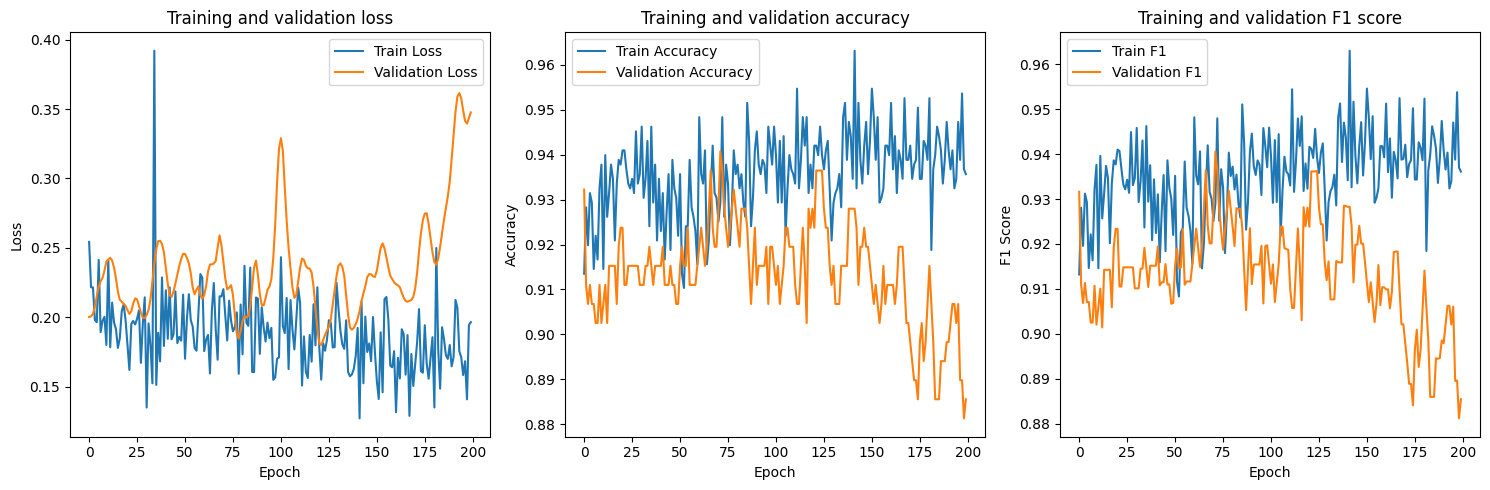

Validation Accuracy: 0.941, Validation F1: 0.941, Validation Loss: 0.228


In [75]:
# Plotting
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and validation accuracy")

# F1 score plot
plt.subplot(1, 3, 3)
plt.plot(train_f1s, label="Train F1")
plt.plot(val_f1s, label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Training and validation F1 score")

plt.tight_layout()
plt.savefig("plots/training_plot.png")
plt.show()

print(f'Validation Accuracy: {val_accs[val_accs.index(max(val_accs))]:.3f}, Validation F1: {val_f1s[val_accs.index(max(val_accs))]:.3f}, Validation Loss: {val_losses[val_accs.index(max(val_accs))]:.3f}')

## Test the classification

In [12]:
from IPython.display import clear_output
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from models import Simple1DCNN


model_path = f"param_autoencoder.pth"  # Path to save the model
model = Autoencoder_type1(dropout_rate=0.2).cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

model_class_path = "param_classifier.pth" 
featidx = list(range(0, 8))  # use all features
model_class = Simple1DCNN(num_sensors=len(featidx), num_classes=4).to('cuda')
model_class.load_state_dict(torch.load(model_class_path))

criterion = nn.CrossEntropyLoss()

val_losses = [], []
val_accs = [], []
val_f1s = [], []

# Validation
model_class.eval()
val_loss, val_total = 0, 0
val_correct = 0
all_val_preds, all_val_targets = [], []


with torch.no_grad():
    for batch in val_loader:
        X, y = batch
        X, y = (
            X.to('cuda'),
            y.to('cuda'),
        )
        val_batch_reshaped = X.cuda()        

        with torch.no_grad():
            _, latent_ = model(val_batch_reshaped)

        input_vl = latent_.squeeze(1).cuda()
        outputs = model_class(input_vl)
        loss = criterion(outputs, y)

        val_loss += loss.item()
        val_total += y.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == y).sum().item()

        # Store predictions and targets for F1 score
        all_val_preds.extend(predicted.cpu().numpy())
        all_val_targets.extend(y.cpu().numpy())

val_loss /= len(val_loader)
val_acc = val_correct / val_total
val_f1 = f1_score(all_val_targets, all_val_preds, average="weighted")

# print the results
print(
    f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}, Validation F1: {val_f1:.4f}"
)


Validation Loss: 0.2278, Validation Acc: 0.9407, Validation F1: 0.9406


## Sensor ablation impact on the classification accuracy

In [13]:
from sklearn.metrics import f1_score
import numpy as np

# Store performance metrics
sensor_accs = []
sensor_f1s = []

# Loop through each sensor index
for sensor_idx in range(8):
    print(f"\nAblating Sensor {sensor_idx}...")
    
    model_class.eval()
    val_loss, val_total = 0, 0
    val_correct = 0
    all_val_preds, all_val_targets = [], []

    with torch.no_grad():
        for batch in val_loader:
            X, y = batch
            X, y = X.to('cuda'), y.to('cuda')

            # Ablate the specific sensor (set its values to 0)
            X_ablate = X.clone()
            X_ablate[:, :, sensor_idx, :] = 0.0

            # Encode input
            _, latent_ = model(X_ablate)
            input_vl = latent_.squeeze(1)

            outputs = model_class(input_vl)
            _, predicted = torch.max(outputs.data, 1)

            val_correct += (predicted == y).sum().item()
            val_total += y.size(0)

            all_val_preds.extend(predicted.cpu().numpy())
            all_val_targets.extend(y.cpu().numpy())

    acc = val_correct / val_total
    f1 = f1_score(all_val_targets, all_val_preds, average='weighted')

    sensor_accs.append(acc)
    sensor_f1s.append(f1)

    print(f"Ablated Sensor {sensor_idx} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")



Ablating Sensor 0...
Ablated Sensor 0 - Accuracy: 0.7669, F1 Score: 0.7676

Ablating Sensor 1...
Ablated Sensor 1 - Accuracy: 0.8559, F1 Score: 0.8560

Ablating Sensor 2...
Ablated Sensor 2 - Accuracy: 0.8856, F1 Score: 0.8857

Ablating Sensor 3...
Ablated Sensor 3 - Accuracy: 0.9195, F1 Score: 0.9199

Ablating Sensor 4...
Ablated Sensor 4 - Accuracy: 0.9195, F1 Score: 0.9198

Ablating Sensor 5...
Ablated Sensor 5 - Accuracy: 0.9068, F1 Score: 0.9071

Ablating Sensor 6...
Ablated Sensor 6 - Accuracy: 0.9322, F1 Score: 0.9322

Ablating Sensor 7...
Ablated Sensor 7 - Accuracy: 0.8983, F1 Score: 0.8994
